# Set up Google Colab Enviorment with Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robertspecht","key":"9cdbe068722d0a283c15bea7e0958920"}'}

In [ ]:
! mkdir /content/drive/MyDrive/kaggle_skinCancer

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                                 title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20          10712        224  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           8312        170  1.0              
dataanalyst001/world-population-by-country-2024                     World Population by country 2024                     6KB  2024-07-04 09:47:58           1122         26  1.0              
ihelon/coffee-sales                          

In [ ]:
! kaggle competitions list

ref                                                                                     deadline             category             reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         $1,100,000        439           False  
https://www.kaggle.com/competitions/lmsys-chatbot-arena                                 2024-08-05 23:59:00  Research           $100,000       1177           False  
https://www.kaggle.com/competitions/isic-2024-challenge                                 2024-09-06 23:59:00  Research            $80,000        543            True  
https://www.kaggle.com/competitions/leash-BELKA                                         2024-07-08 23:59:00  Featured            $50,000       1976           False  
http

In [ ]:
! kaggle competitions download -c 'isic-2024-challenge'

 99% 1.99G/2.00G [00:20<00:00, 104MB/s] 
100% 2.00G/2.00G [00:20<00:00, 104MB/s]


In [ ]:
! unzip isic-2024-challenge.zip -d /content/drive/MyDrive/kaggle_skinCancer/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874656.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874659.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874663.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874742.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874751.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874803.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874805.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874832.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874878.jpg  
  inflating: /content/drive/MyDrive/kaggle_skinCancer/train-image/image/ISIC_9874897.jpg  
  inflating: /content/drive/MyDrive/kag

# Import the Libraries and Set up the Data

In [ ]:
!pip install h2o
# standard
import numpy as np
import pandas as pd
import time

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats

# H2O
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.3-py2.py3-none-any.whl size=265365897 sha256=2857d5e7dfd5c65ae8a4319b2f59ccc583f10f9bf4ce21d3a1dd2bf4d4103fe0
  Stored in directory: /root/.cache/pip/wheels/c4/63/41/baa115b5255e1db3e2383bce4e2e6181746aac0b42264c242f
Successfully built h2o


In [ ]:
# configs
pd.set_option('display.max_columns', None) # we want to display all columns in this notebook

# random seed
my_random_seed = 1

# aesthetics
default_color_1 = 'blue'
default_color_2 = 'green'
default_color_3 = 'red'

In [ ]:
# load data
df_train = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/train-metadata.csv', low_memory=False)
df_test = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/test-metadata.csv', low_memory=False)
df_sub = pd.read_csv('/content/drive/MyDrive/kaggle_skinCancer/sample_submission.csv')

# Data First Impressions

In [ ]:
df_train.head()

isic_id  target  patient_id  age_approx   sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0  male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0  male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0  male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0  male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0  male      anterior torso   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  \
0                    3.04  TBP tile: close-up     3D: white  20.244422   
1                    1.10  TBP tile: close-up     3D: white  31.712570   
2                    3.40  TBP tile: close-up        3D: XP  22.575830   
3                    3.22  TBP tile: close-up        3D: XP  14.242329   
4                    2.73  TBP tile: close-up     3D: white  24.725520   

   tbp_lv_Aext   tbp_lv_B  tbp_lv_Bext   tbp_lv_C  tbp_lv_Cext   tbp_lv_H  \
0    16.261975  26.922447    23.954773  33.684638    28.953117  53.058545   
1    25.364740  26.331000    24.549290  41.219030    35.299260  39.702910   
2    17.128170  37.970460    33.485410  44.174920    37.611800  59.265850   
3    12.164757  21.448144    21.121356  25.746200    24.374023  56.414429   
4    20.057470  26.464900    25.710460  36.217980    32.608740  46.946070   

   tbp_lv_Hext   tbp_lv_L  tbp_lv_Lext  tbp_lv_areaMM2  \
0    55.828924  54.367448    62.025701        3.152561   
1    44.064040  48.861520    55.362360        0.919497   
2    62.909730  53.961180    61.670520        3.265153   
3    60.060388  18.649518    23.314841        6.079940   
4    52.041180  46.276310    54.855740        2.101708   

   tbp_lv_area_perim_ratio  tbp_lv_color_std_mean  tbp_lv_deltaA  \
0                27.476170                0.00000       3.982447   
1                12.235290                0.00000       6.347830   
2                24.184620                0.00000       5.447655   
3                14.889242                0.51452       2.077572   
4                19.902560                0.00000       4.668053   

   tbp_lv_deltaB  tbp_lv_deltaL  tbp_lv_deltaLB  tbp_lv_deltaLBnorm  \
0       2.967674      -7.658253        8.360566            5.784302   
1       1.781713      -6.500838        6.839008            4.987244   
2       4.485044      -7.709336        9.092376            6.290359   
3       0.326788      -4.665323        4.783413            6.400196   
4       0.754434      -8.579431        9.148495            6.531302   

   tbp_lv_eccentricity       tbp_lv_location tbp_lv_location_simple  \
0             0.901302     Right Leg - Upper              Right Leg   
1             0.639885           Head & Neck            Head & Neck   
2             0.932147  Torso Back Top Third             Torso Back   
3             0.654458  Torso Front Top Half            Torso Front   
4             0.946448  Torso Front Top Half            Torso Front   

   tbp_lv_minorAxisMM  tbp_lv_nevi_confidence  tbp_lv_norm_border  \
0            1.543016            2.628592e-03            7.091360   
1            0.821918            1.334303e-07            2.116402   
2            1.194905            2.959177e-04            4.798335   
3            2.481328            2.198945e+01            1.975874   
4            0.929916            1.378832e-03            3.658854   

   tbp_lv_norm_color  tbp_lv_perimeterMM  tbp_lv_radial_color_std_max  \
0           0.000000            9.307003                      0.00000   
1           0.000000            3.354148                      0.00000   
2           0.000000            8.886309                      0.00000   
3           1.771705            9.514499                      0.66469   
4           0.000000            6.467562                      0.00000   

   tbp_lv_stdL  tbp_lv_stdLExt  tbp_lv_symm_2axis  tbp_lv_symm_2axis_angle  \
0     2.036195        2.637780           0.590476                       85   
1     0.853227 

In [ ]:
df_train.shape

(401059, 55)

In [ ]:
df_test.shape

(3, 44)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [ ]:
df_train.describe()

target     age_approx  clin_size_long_diam_mm       tbp_lv_A  \
count  401059.000000  398261.000000           401059.000000  401059.000000   
mean        0.000980      58.012986                3.930827      19.974007   
std         0.031288      13.596165                1.743068       3.999489   
min         0.000000       5.000000                1.000000      -2.487115   
25%         0.000000      50.000000                2.840000      17.330821   
50%         0.000000      60.000000                3.370000      19.801910   
75%         0.000000      70.000000                4.380000      22.304628   
max         1.000000      85.000000               28.400000      48.189610   

         tbp_lv_Aext       tbp_lv_B    tbp_lv_Bext       tbp_lv_C  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       14.919247      28.281706      26.913015      34.786341   
std         3.529384       5.278676       4.482994       5.708469   
min        -9.080269      -0.730989       9.237066       3.054228   
25%        12.469740      24.704372      23.848125      31.003148   
50%        14.713930      28.171570      26.701704      34.822580   
75%        17.137175      31.637429      29.679913      38.430298   
max        37.021680      54.306900      48.372700      58.765170   

         tbp_lv_Cext       tbp_lv_H    tbp_lv_Hext       tbp_lv_L  \
count  401059.000000  401059.000000  401059.000000  401059.000000   
mean       30.921279      54.653689      60.996869      42.289976   
std         4.829345       5.520849       5.631909      10.864572   
min        11.846520      -1.574164      28.436490       4.223007   
25%        27.658285      51.566273      57.297630      34.303345   
50%        30.804893      55.035632      61.109173      42.343770   
75%        33.963868      58.298184      64.905025      50.405051   
max        54.305290     105.875784     130.983300      87.548888   

         tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
count  401059.000000   401059.000000            401059.000000   
mean       51.199529        8.539975                19.084517   
std        12.100527        9.679312                 5.357863   
min        17.702260        0.431601                10.761634   
25%        42.274506        4.109589                15.426205   
50%        51.425557        5.685870                17.423950   
75%        60.495607        9.119910                21.011340   
max        98.588250      334.152700                87.205340   

       tbp_lv_color_std_mean  tbp_lv_deltaA  tbp_lv_deltaB  tbp_lv_deltaL  \
count          401059.000000  401059.000000  401059.000000  401059.000000   
mean                1.070408       5.054760       1.368691      -8.909552   
std                 0.762918       2.642928       2.215871       3.463362   
min                 0.000000     -13.819850     -18.088106     -38.756140   
25%                 0.574909       3.413108       0.111030     -10.675470   
50%                 0.931402       4.643926       1.593945      -8.132223   
75%                 1.412154       6.274246       2.850638      -6.397103   
max                 9.952932      32.137590      12.643930      -1.590631   

       tbp_lv_deltaLB  tbp_lv_deltaLBnorm  tbp_lv_eccentricity  \
count   401059.000000       401059.000000        401059.000000   
mean         9.455766            7.538922             0.741238   
std          3.466703            2.404951             0.143857   
min          2.952675            3.001138             0.027667   
25%          6.952377            5.748160             0.656627   
50%          8.699932            6.946320             0.768215   
75%         11.243486            8.748403             0.853175   
max         39.197720           30.487456             0.974960   

       tbp_lv_minorAxisMM  tbp_lv_nevi_confidence  tbp_lv_norm_border  \
count       401059.000000           401059.000000       401059.000000   
mean             2.539773               38.520

In [ ]:
df_test.describe()

age_approx  clin_size_long_diam_mm   tbp_lv_A  tbp_lv_Aext   tbp_lv_B  \
count    3.000000                3.000000   3.000000     3.000000   3.000000   
mean    48.333333                2.793333  21.235613    16.534205  30.055107   
std     15.275252                0.330051   4.037983     5.955101   1.508777   
min     35.000000                2.520000  16.648670     9.657964  28.384120   
25%     40.000000                2.610000  19.726500    14.797672  29.423900   
50%     45.000000                2.700000  22.804330    19.937380  30.463680   
75%     55.000000                2.930000  23.529085    19.972325  30.890600   
max     65.000000                3.160000  24.253840    20.007270  31.317520   

       tbp_lv_Bext   tbp_lv_C  tbp_lv_Cext   tbp_lv_H  tbp_lv_Hext   tbp_lv_L  \
count     3.000000   3.000000     3.000000   3.000000     3.000000   3.000000   
mean     27.650733  36.939135    32.498746  54.900061    59.695153  40.234463   
std       0.679182   1.795292     2.930254   6.153928     9.525959  17.875819   
min      27.043640  35.467806    29.169579  51.220960    53.505430  24.979850   
25%      27.283979  35.938953    31.404790  51.347845    54.210420  30.399650   
50%      27.524318  36.410100    33.640000  51.474730    54.915410  35.819450   
75%      27.954279  37.674800    34.163330  56.739612    62.790014  47.861770   
max      28.384240  38.939500    34.686660  62.004494    70.664619  59.904090   

       tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
count     3.000000        3.000000                 3.000000   
mean     46.871437        3.121286                20.443077   
std      19.118920        0.895504                 2.148809   
min      31.114600        2.120473                18.957821   
25%      36.236620        2.758491                19.211110   
50%      41.358640        3.396510                19.464400   
75%      54.749856        3.621693                21.185705   
max      68.141071        3.846876                22.907010   

       tbp_lv_color_std_mean  tbp_lv_deltaA  tbp_lv_deltaB  tbp_lv_deltaL  \
count               3.000000       3.000000       3.000000       3.000000   
mean                0.237461       4.701409       2.404372      -6.636973   
std                 0.230883       2.123160       1.258232       1.417283   
min                 0.000000       2.797056       1.340481      -8.236981   
25%                 0.125618       3.556761       1.709957      -7.185864   
50%                 0.251236       4.316465       2.079433      -6.134747   
75%                 0.356192       5.653585       2.936317      -5.836969   
max                 0.461149       6.990705       3.793202      -5.539191   

       tbp_lv_deltaLB  tbp_lv_deltaLBnorm  tbp_lv_eccentricity  \
count        3.000000            3.000000             3.000000   
mean         7.209592            6.124481             0.828647   
std          1.693005            0.698937             0.143078   
min          6.041092            5.446997             0.664465   
25%          6.238824            5.765193             0.779621   
50%          6.436557            6.083388             0.894776   
75%          7.793842            6.463223             0.910737   
max          9.151127            6.843057             0.926698   

       tbp_lv_minorAxisMM  tbp_lv_nevi_confidence  tbp_lv_norm_border  \
count            3.000000            3.000000e+00            3.000000   
mean             1.580365            7.590582e-02            4.575493   
std              0.579789            1.170750e-01            0.765336   
min              1.032666            8.052259e-13            3.968912   
25%              1.276726            8.490520e-03            4.145556   
50%              1.520786            1.698104e-02            4.322201   
75%              1.854215            1.138587e-01            4.878783   
max              2.187644            2.107364e-01            5.435366   

       tbp_lv_norm_color  tbp_lv_perimete

In [ ]:
df_train.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

# Exploring the Data


In [ ]:
# define features and target

# categorical
features_cat =['sex', 'anatom_site_general', 'image_type', 'tbp_tile_type','tbp_lv_location', 'tbp_lv_location_simple', 'attribution', 'copyright_license']

# numerical
features_num = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext','tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext',
                'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
                'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
                'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
                'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']

# target
target = 'target'

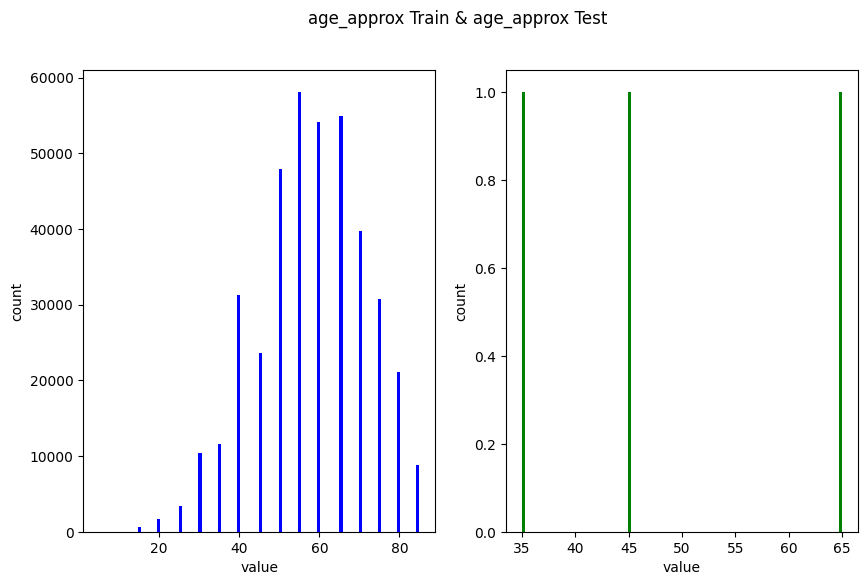

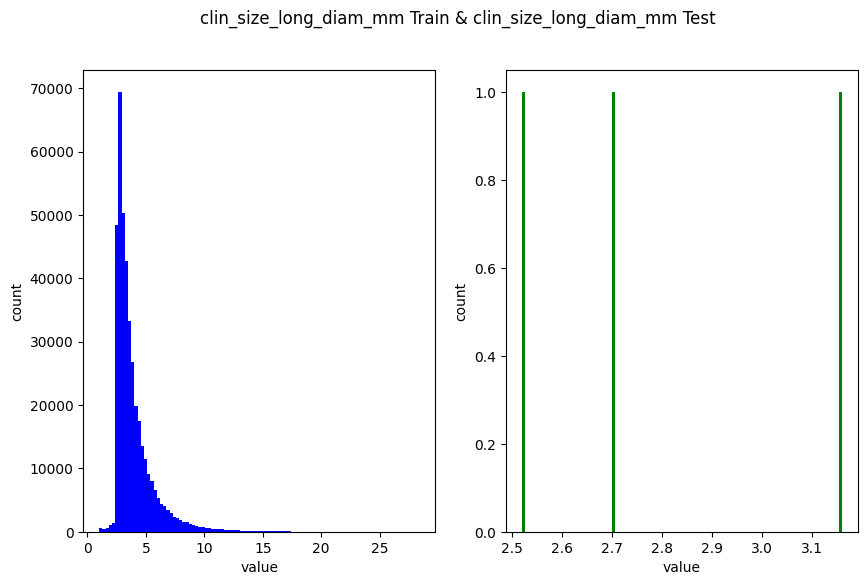

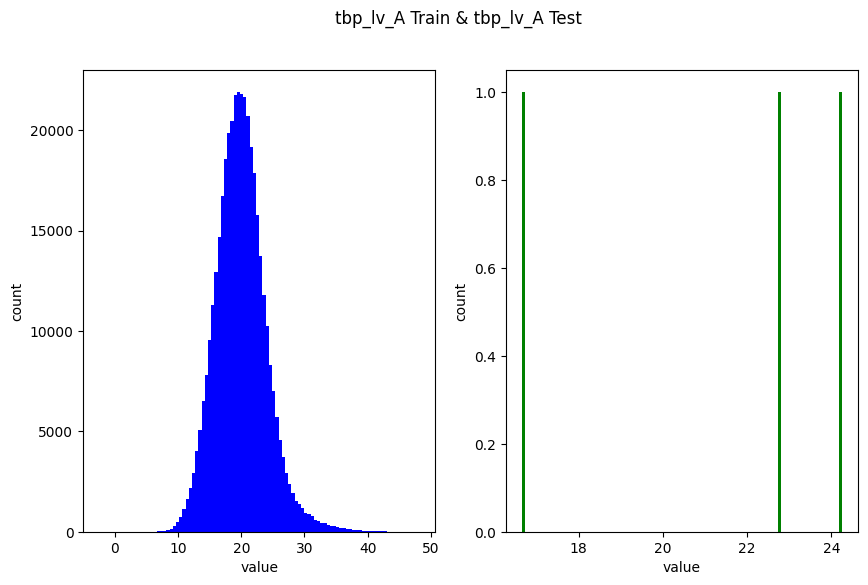

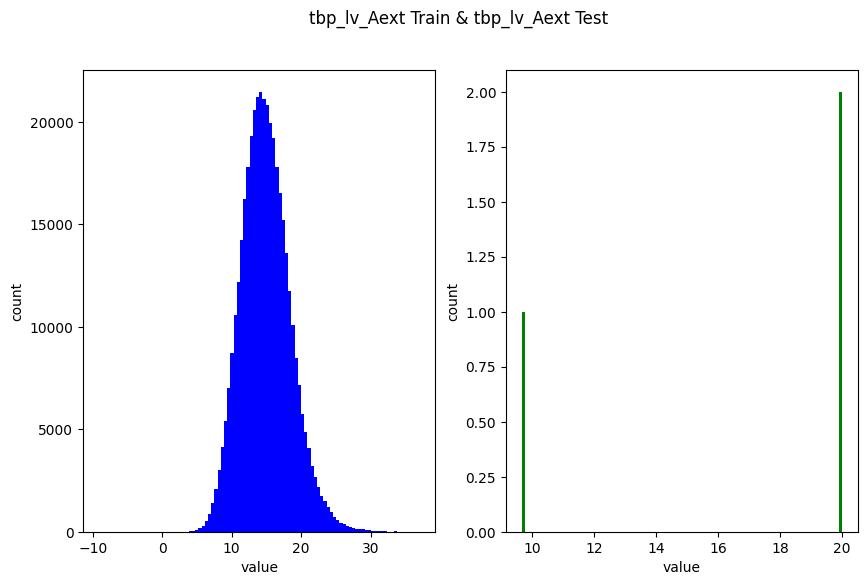

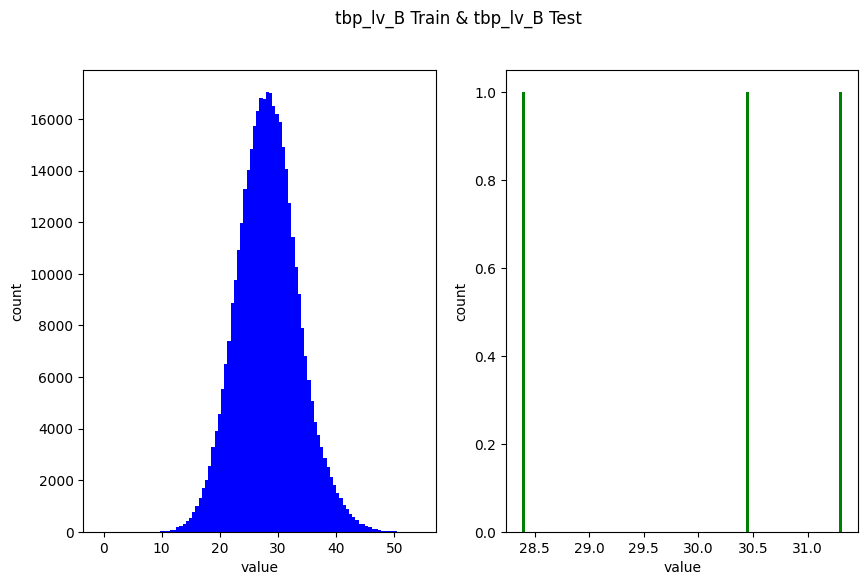

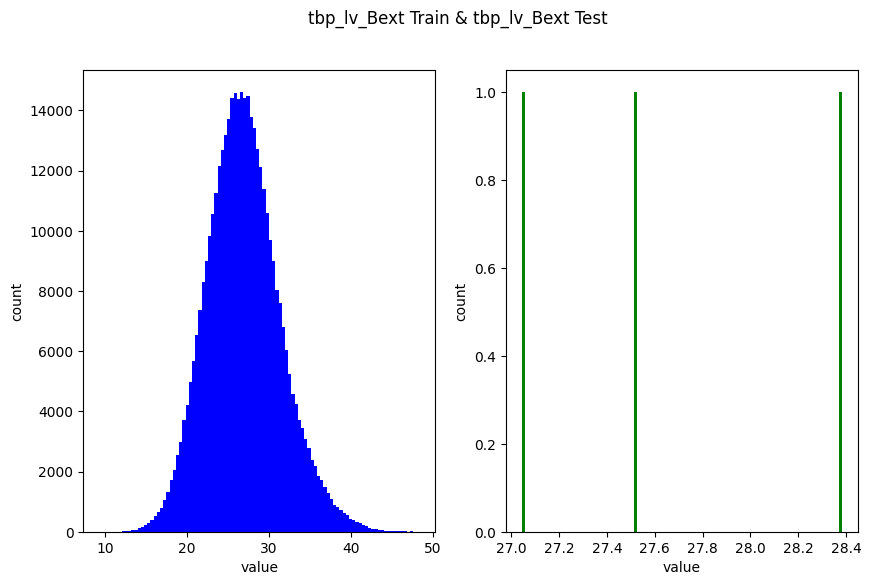

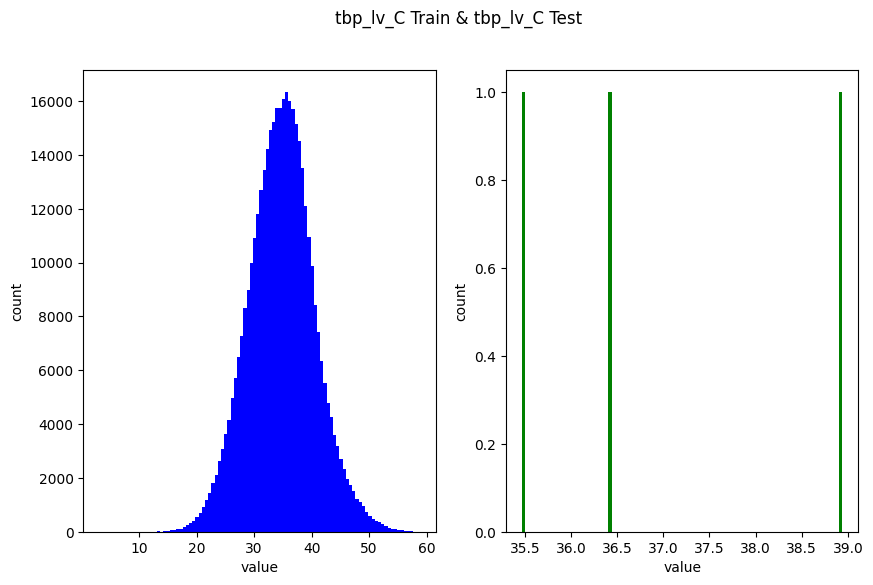

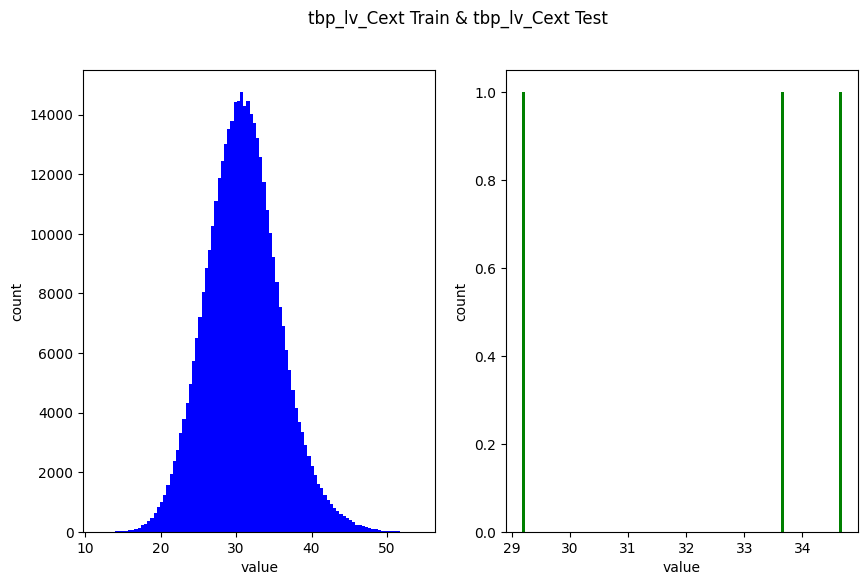

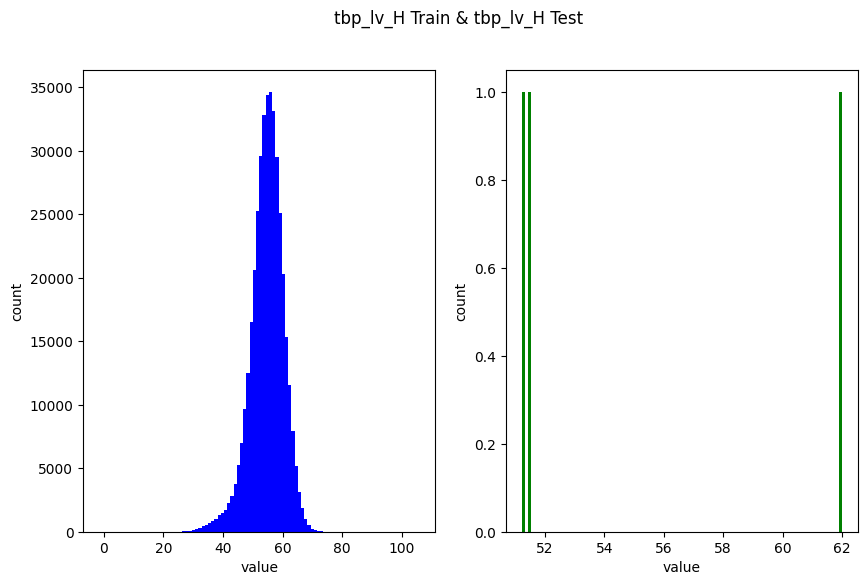

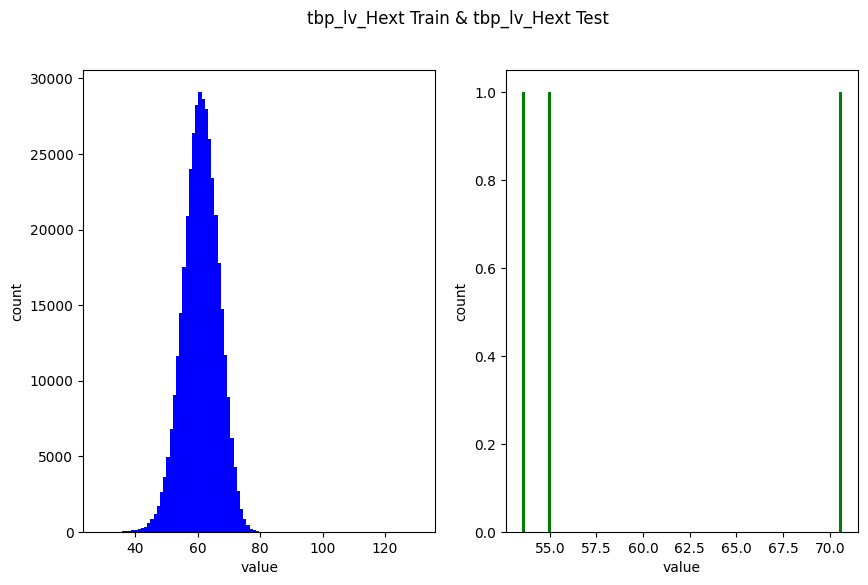

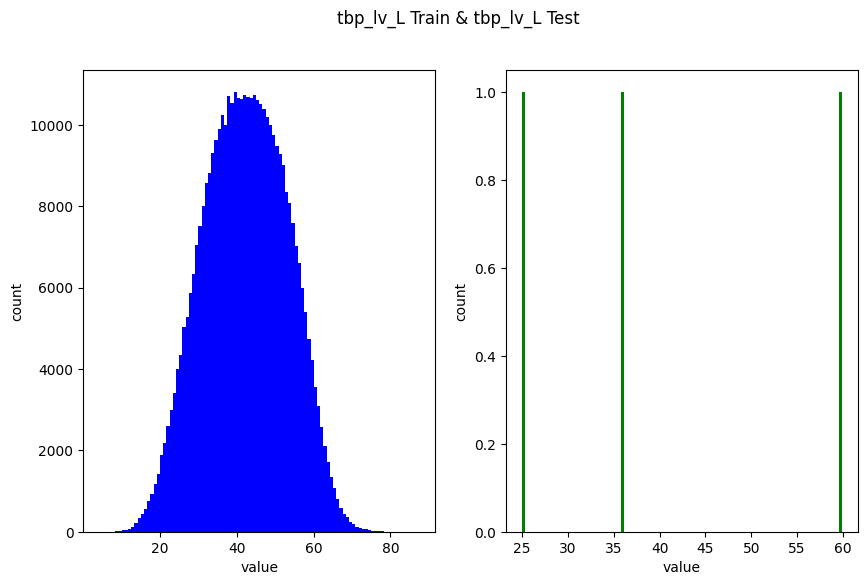

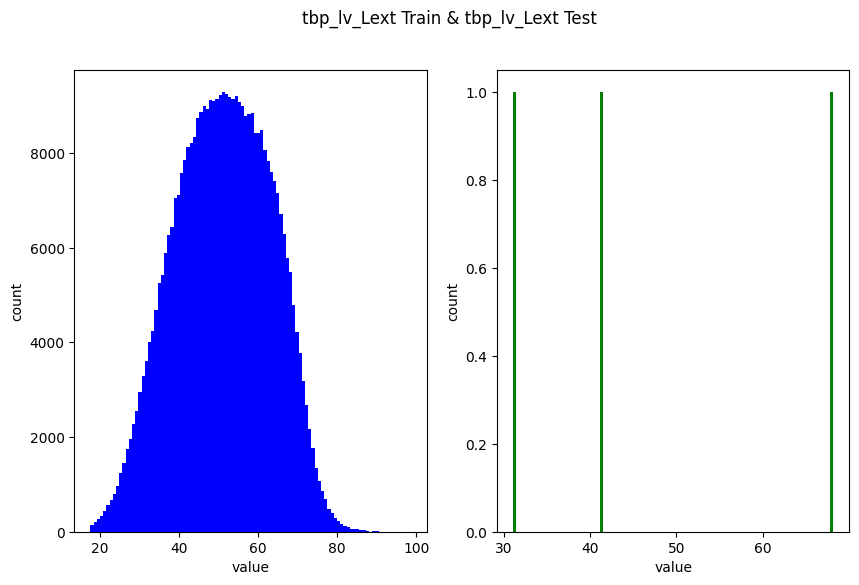

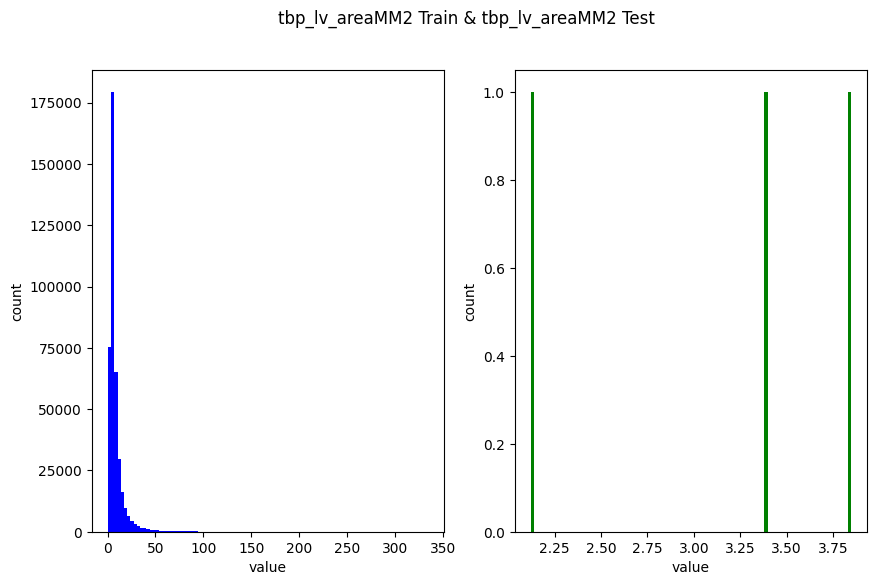

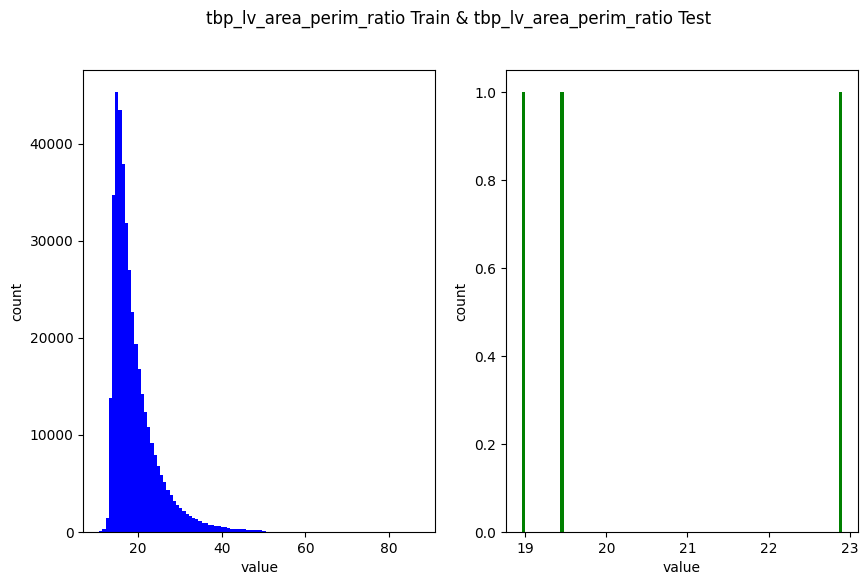

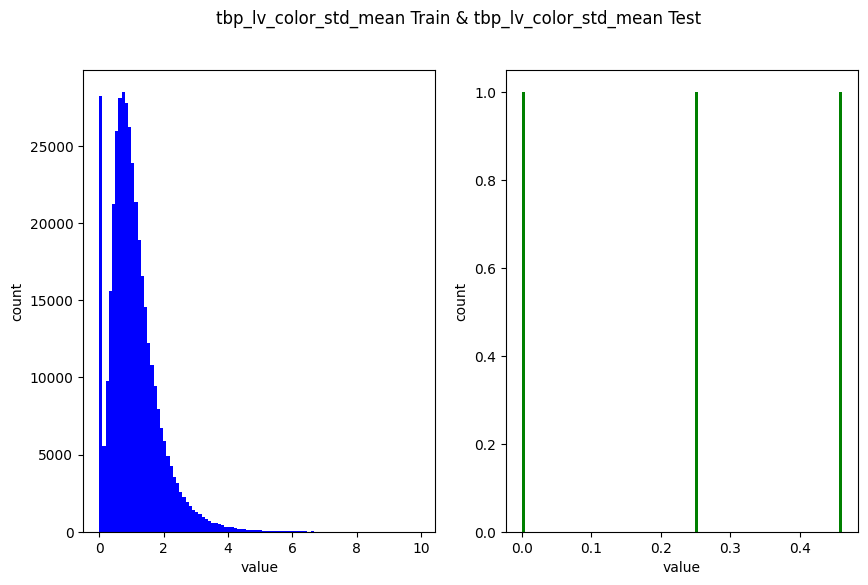

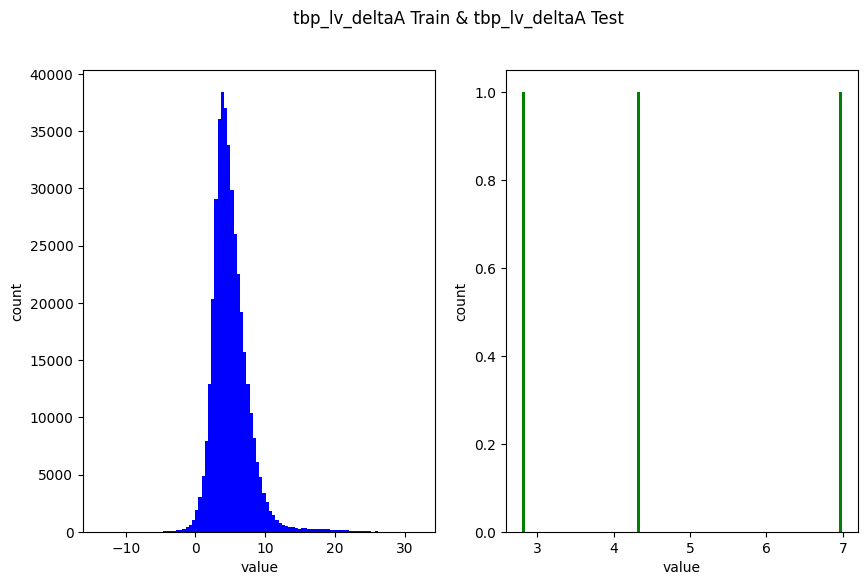

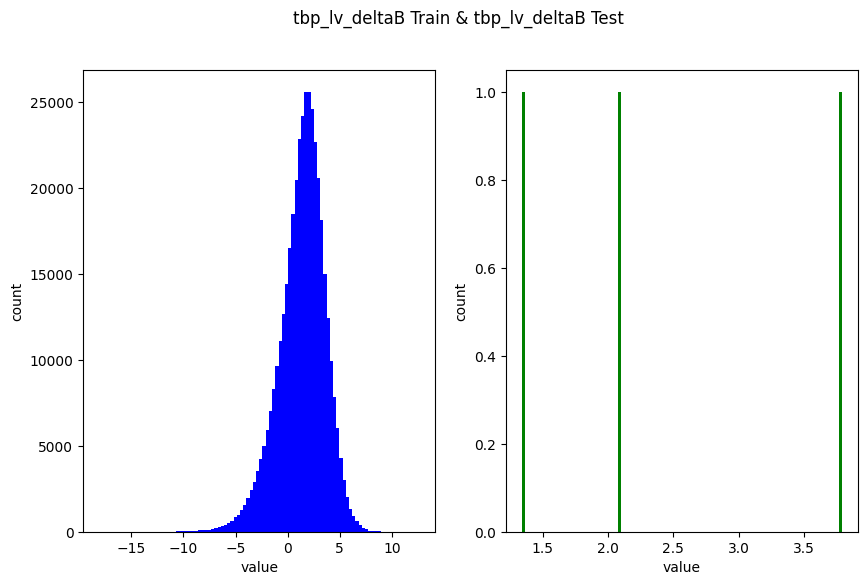

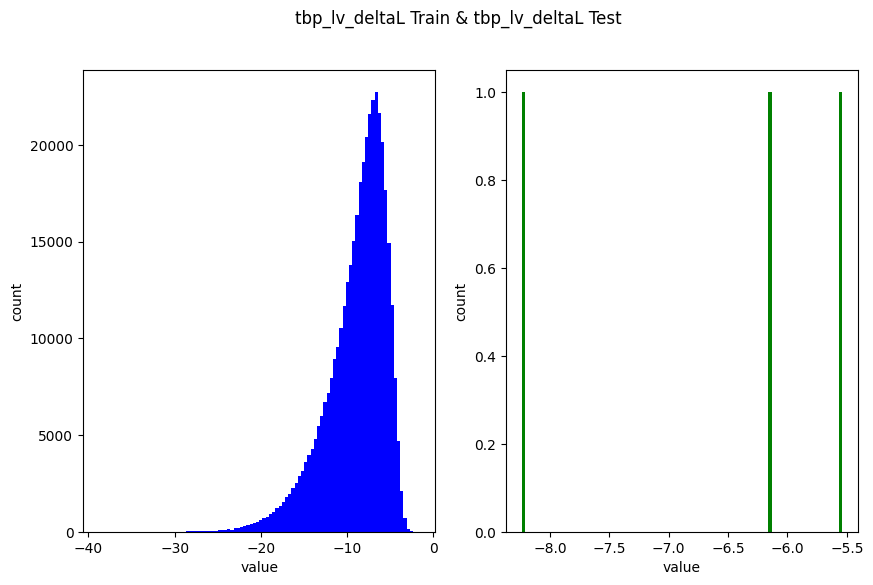

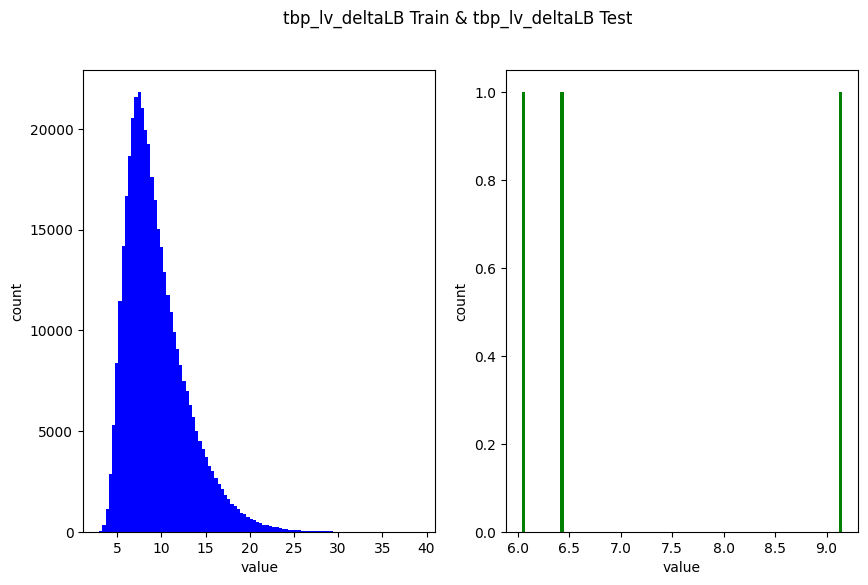

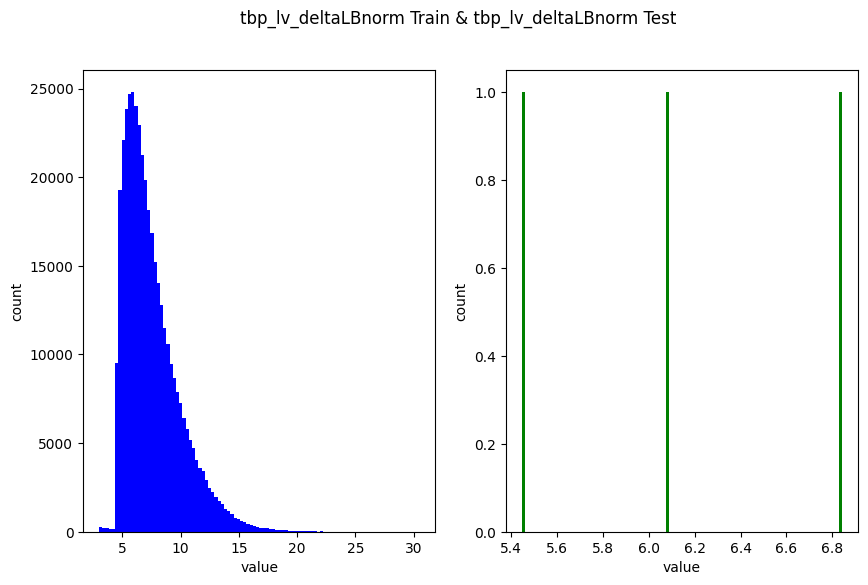

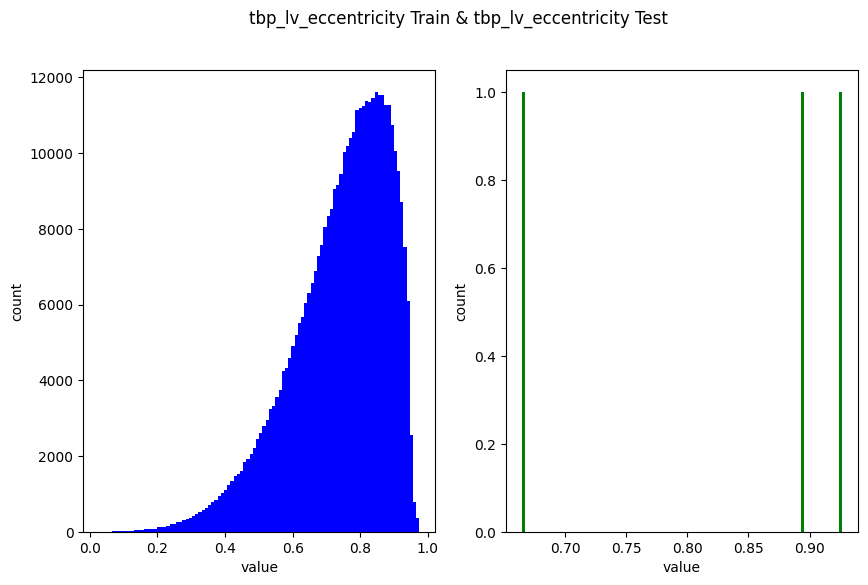

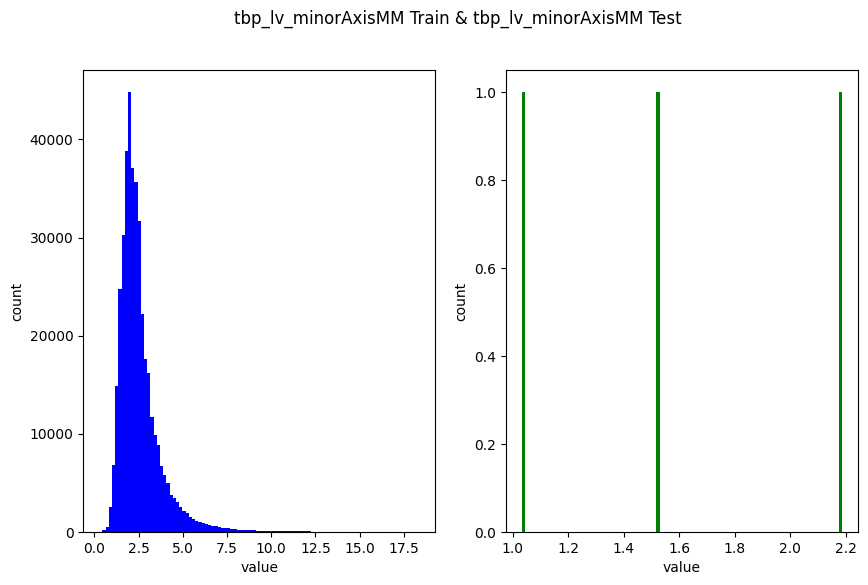

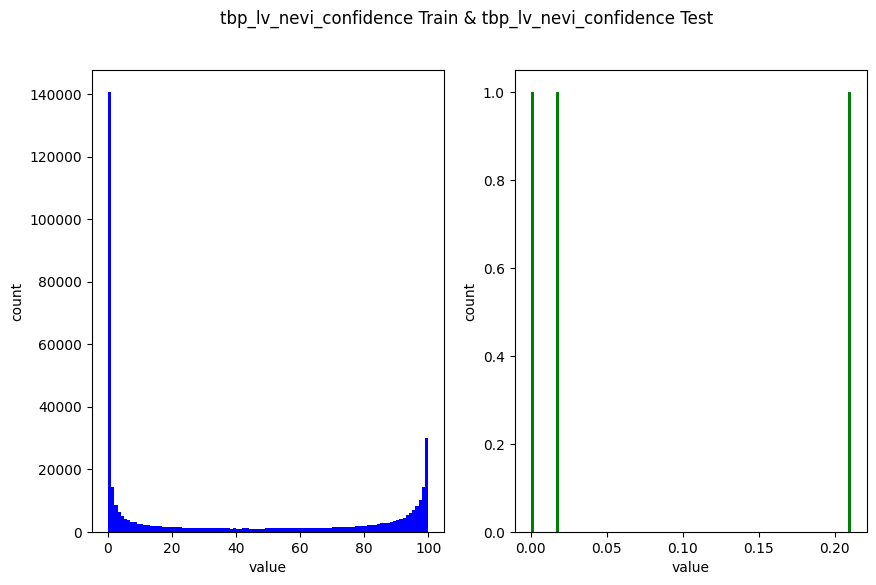

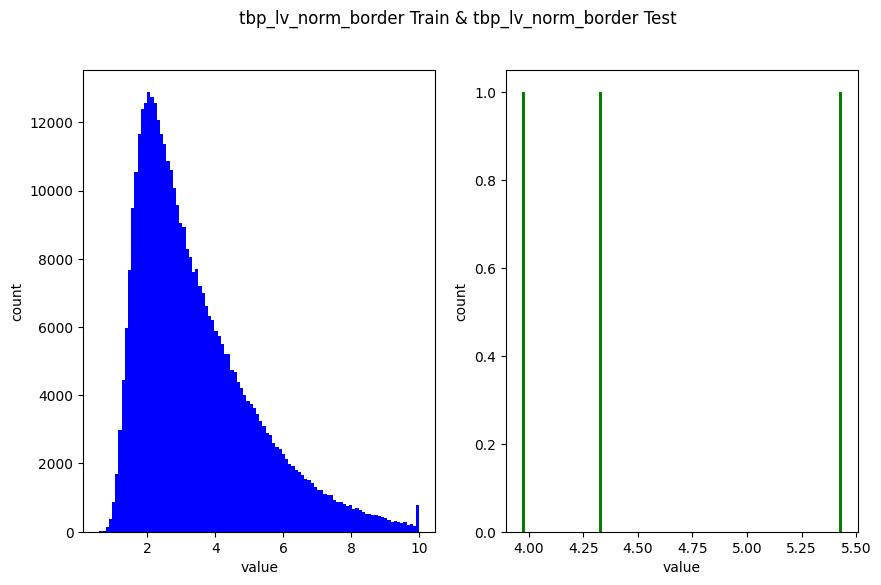

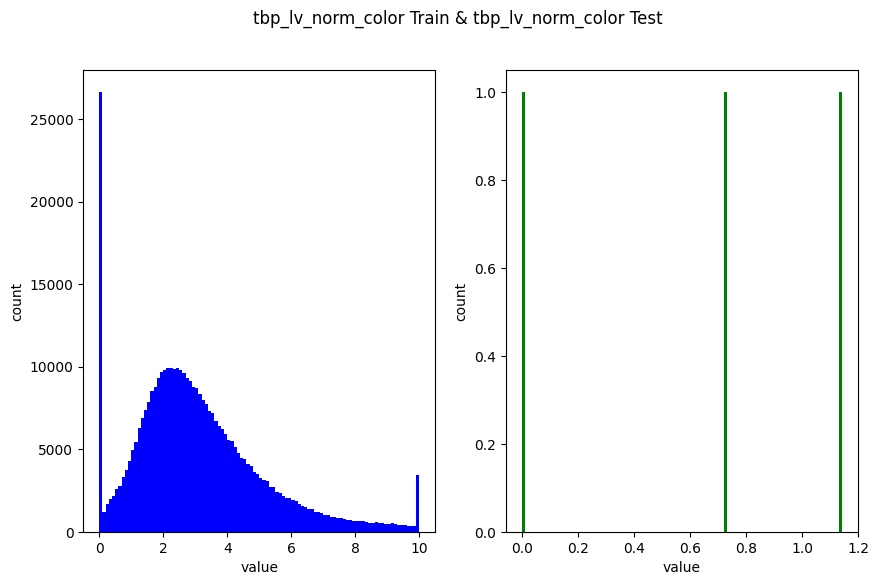

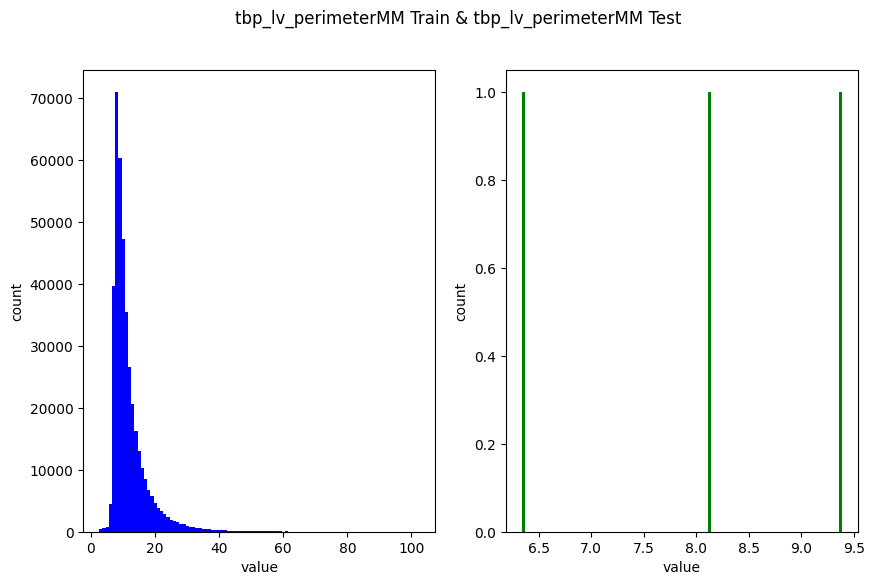

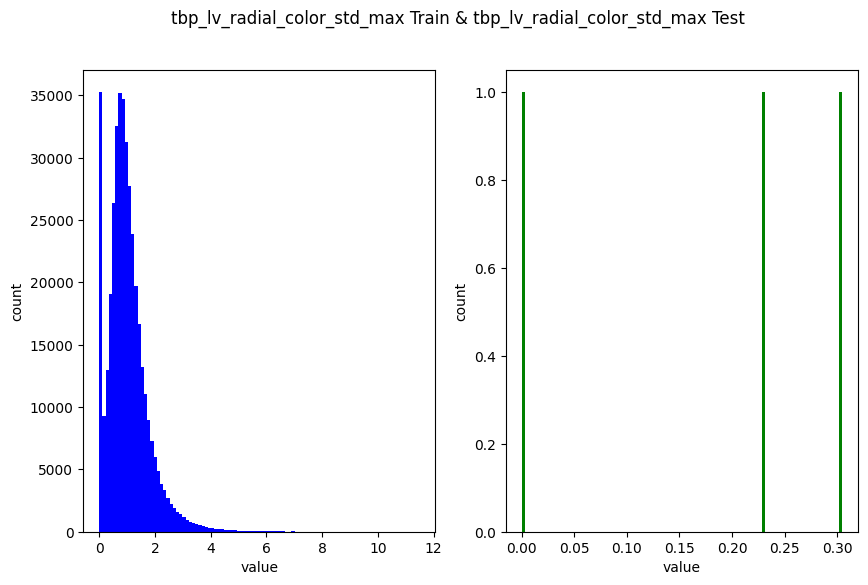

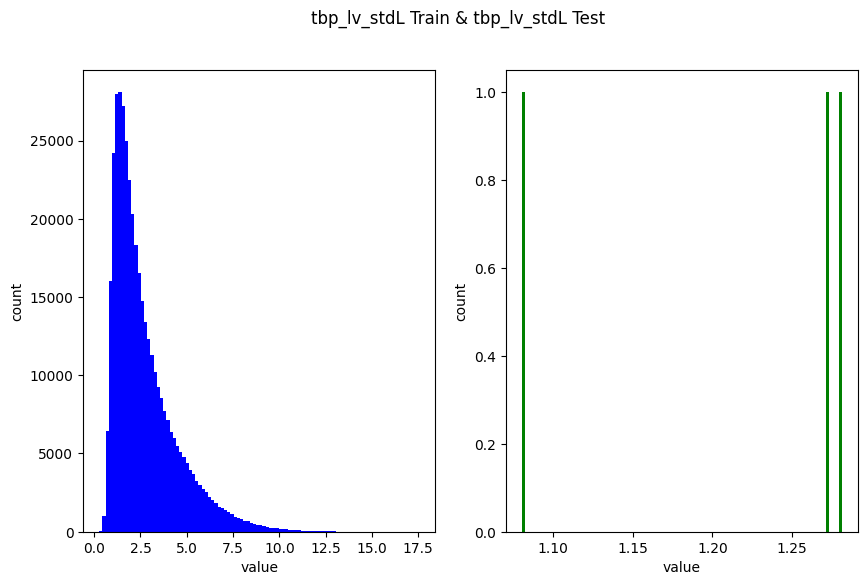

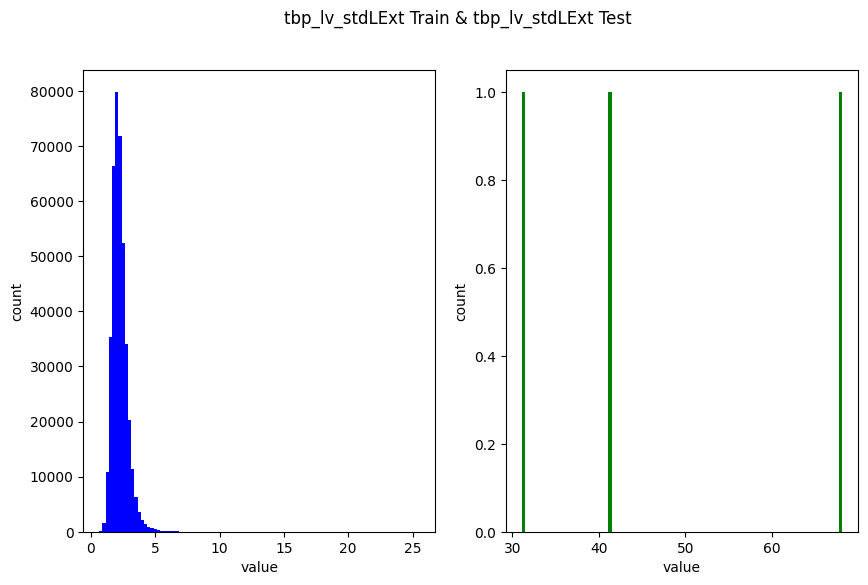

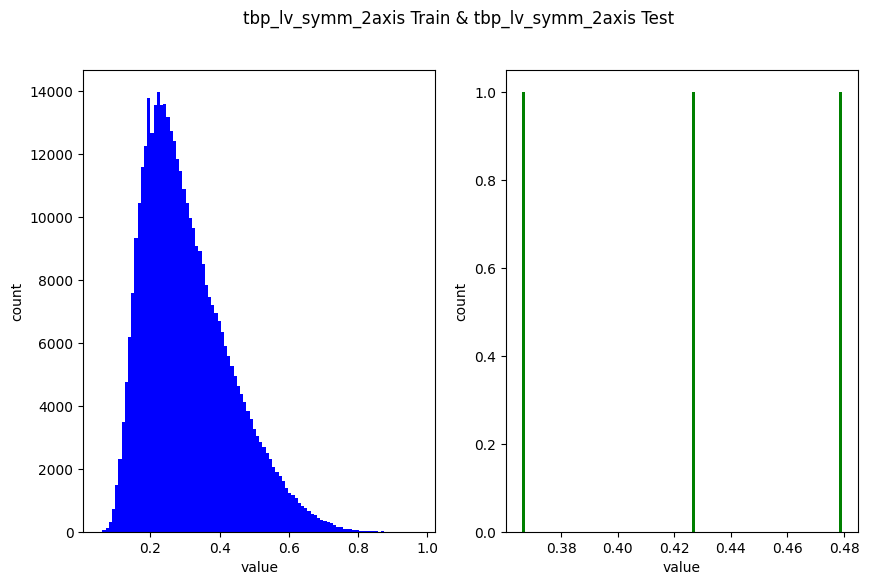

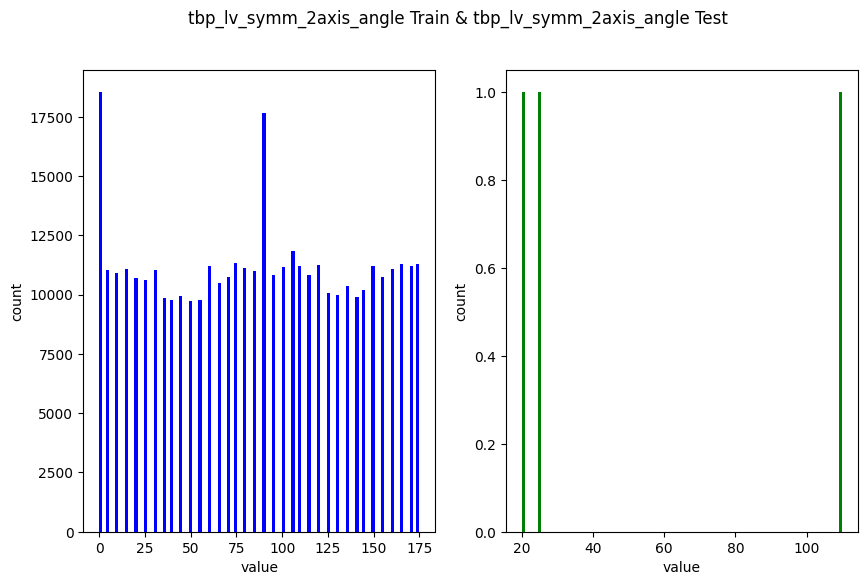

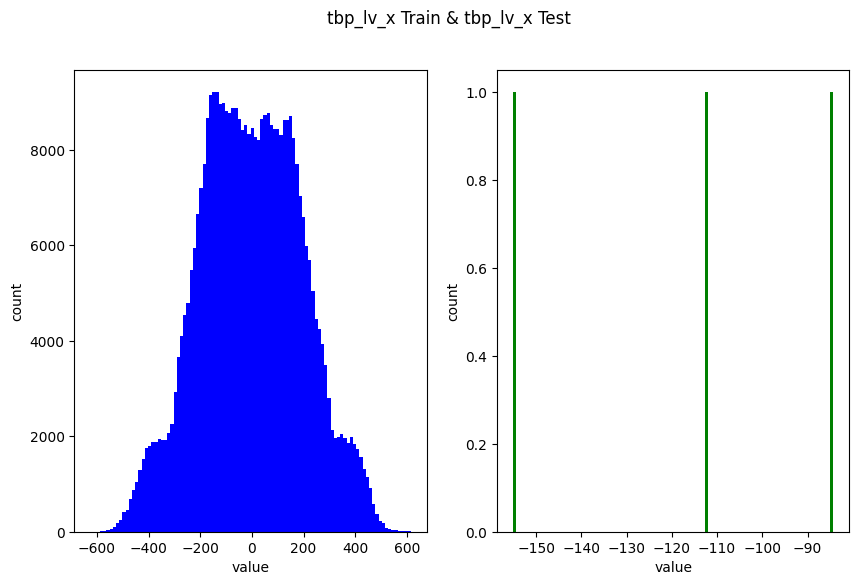

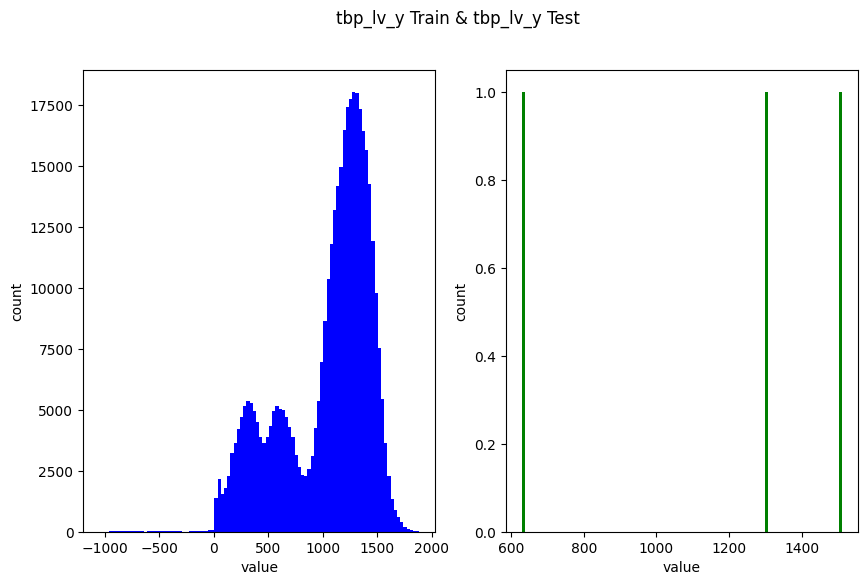

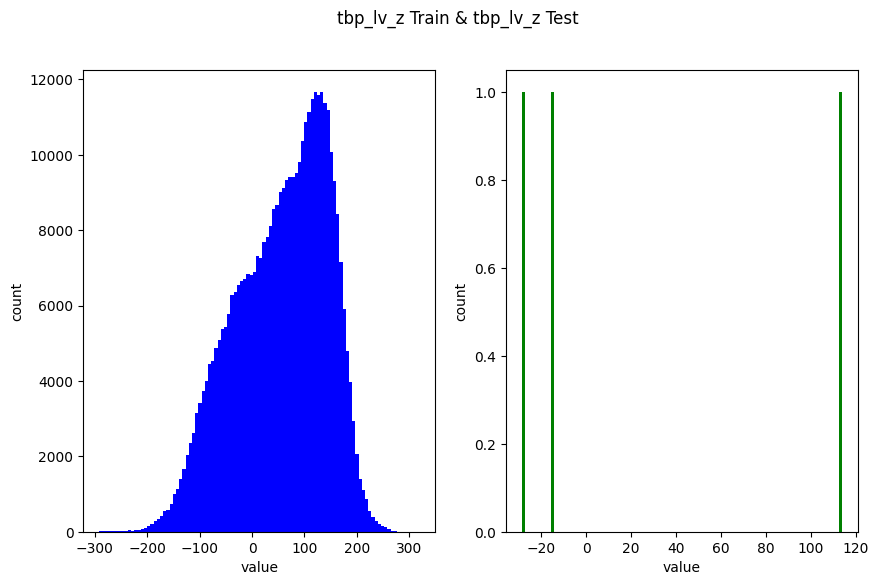

In [ ]:
for feature in features_num:
  plt.figure(figsize = (10,6))
  plot1 = plt.subplot(1,2,1)
  plot1.hist(df_train[feature],bins =100, color=default_color_1)
  plot1.figure.suptitle(feature + ' Train & ' + feature + ' Test')
  plot1.set(xlabel = 'value', ylabel = 'count')
  plot2 = plt.subplot(1,2,2)
  plot2.hist(df_test[feature],bins =100, color=default_color_2)
  plot2.set(xlabel = 'value', ylabel = 'count')
  plt.show()
  print()
  print()



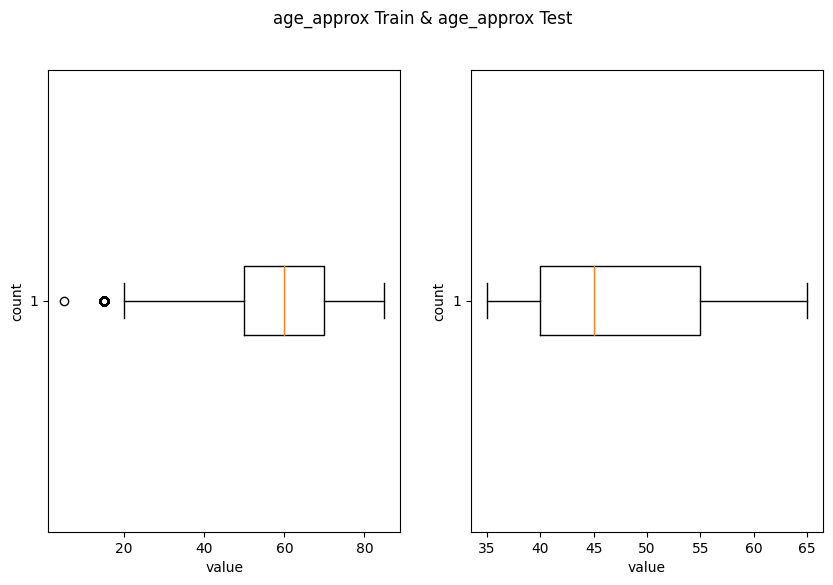

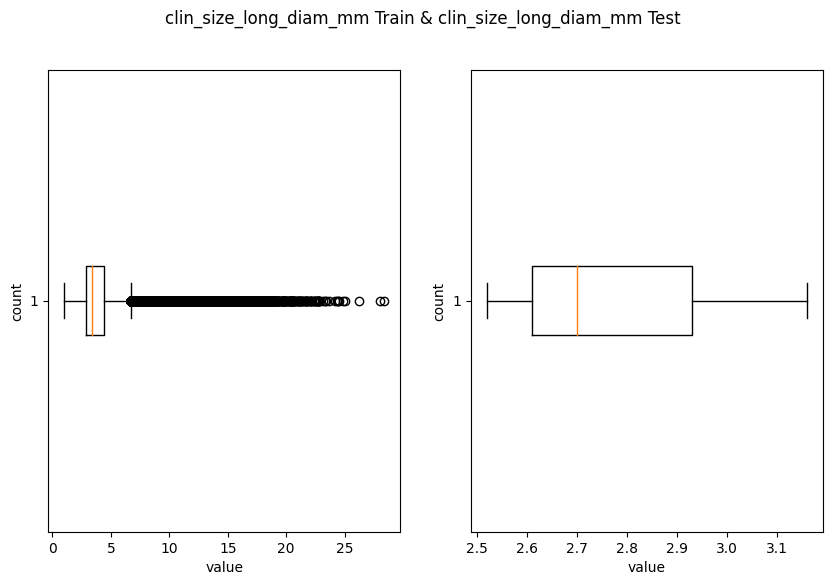

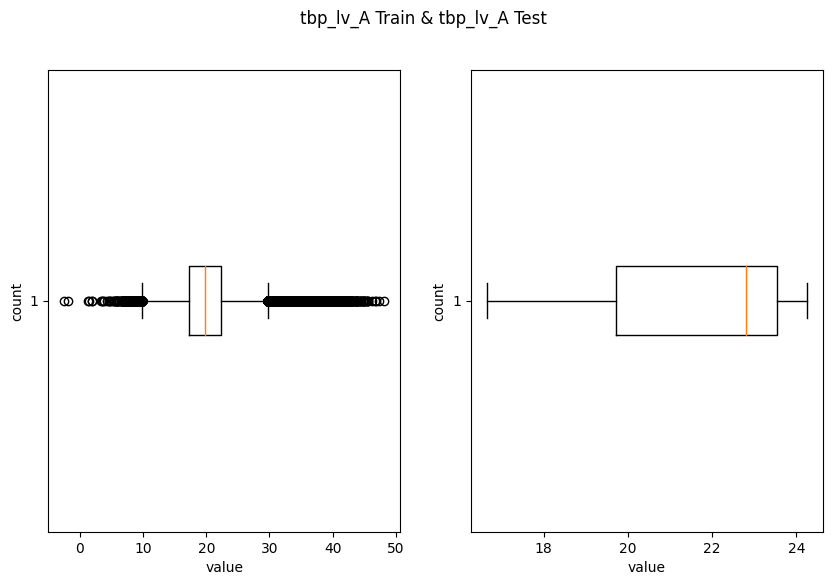

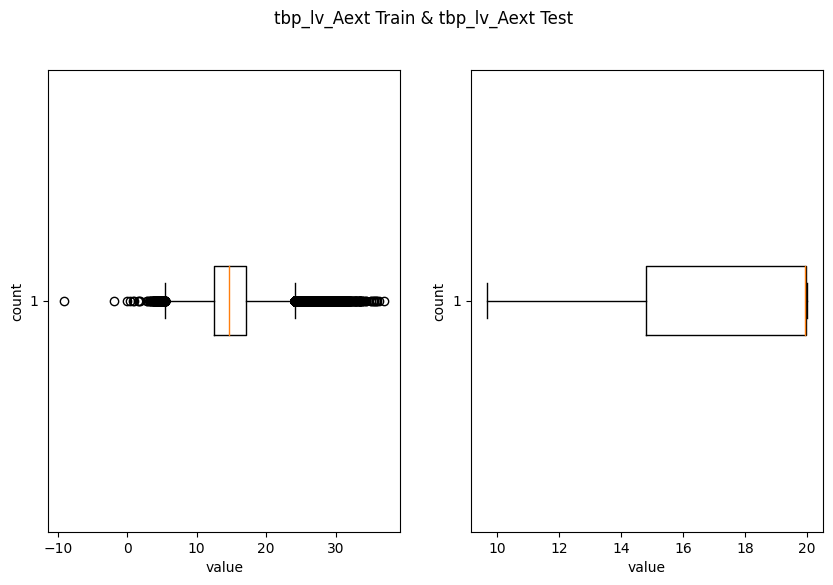

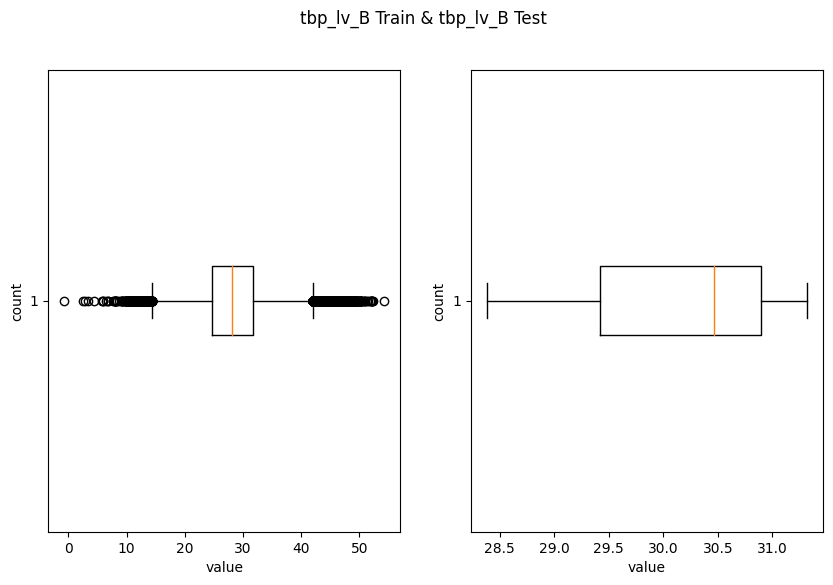

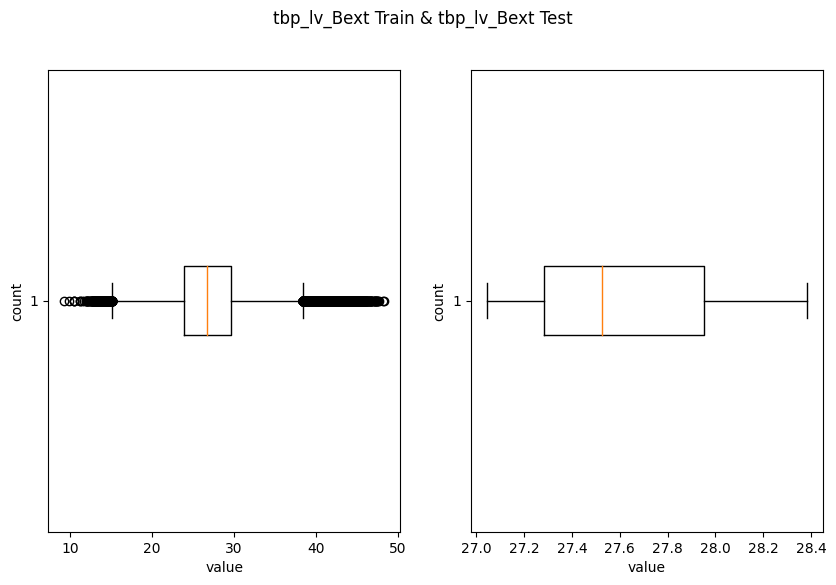

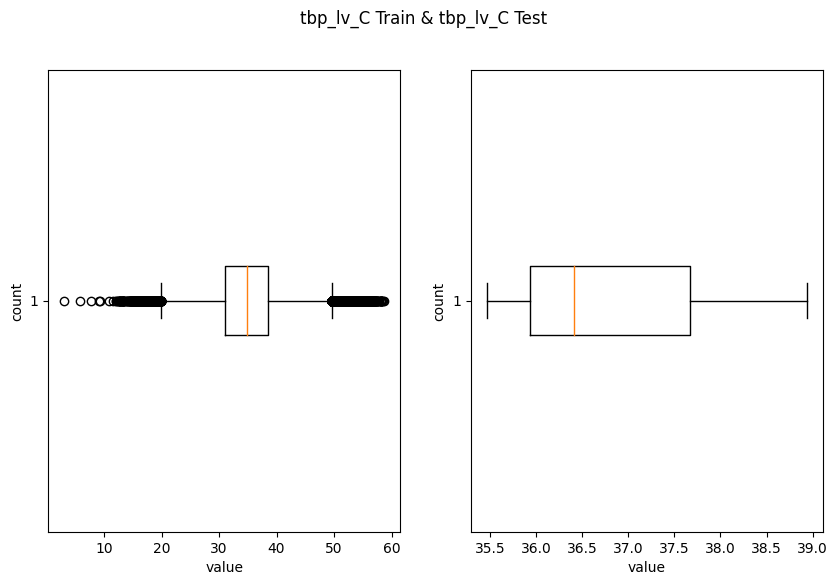

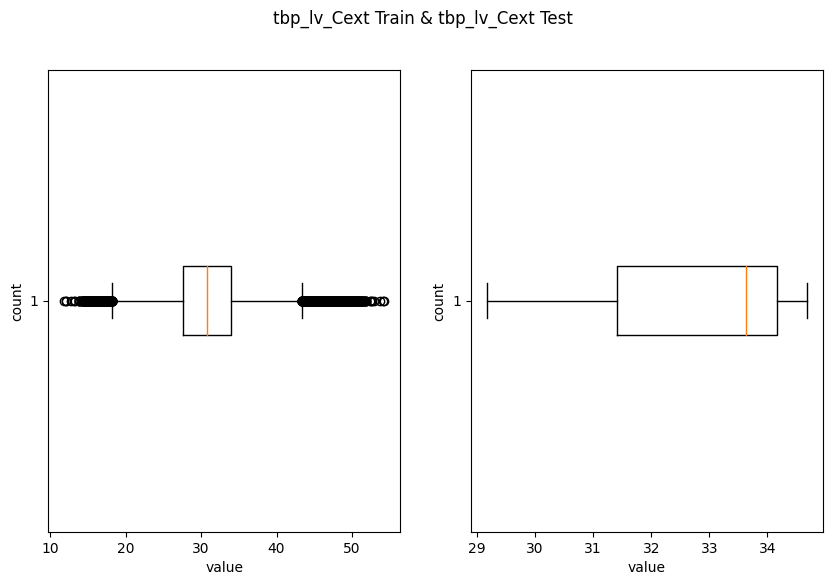

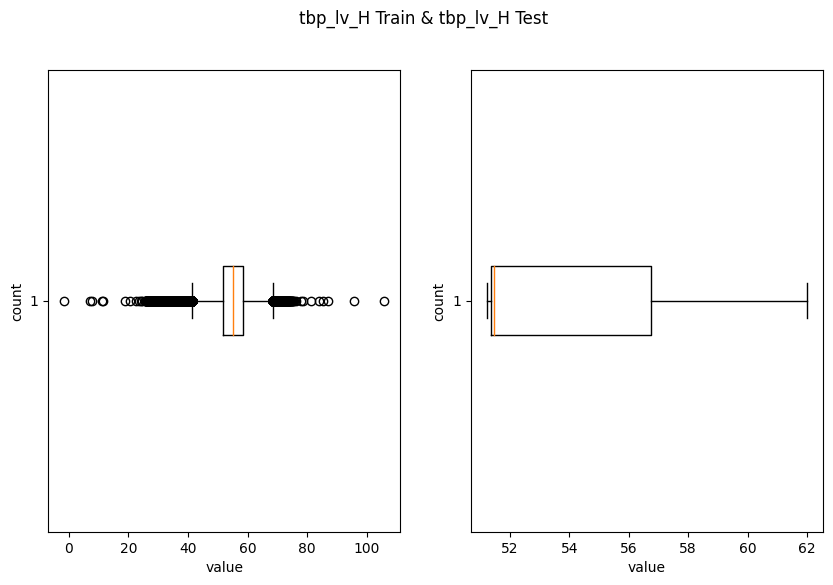

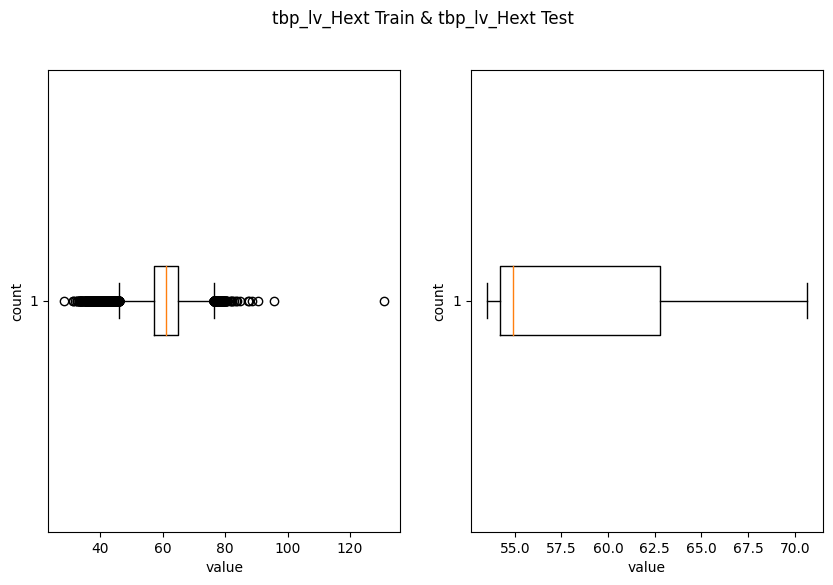

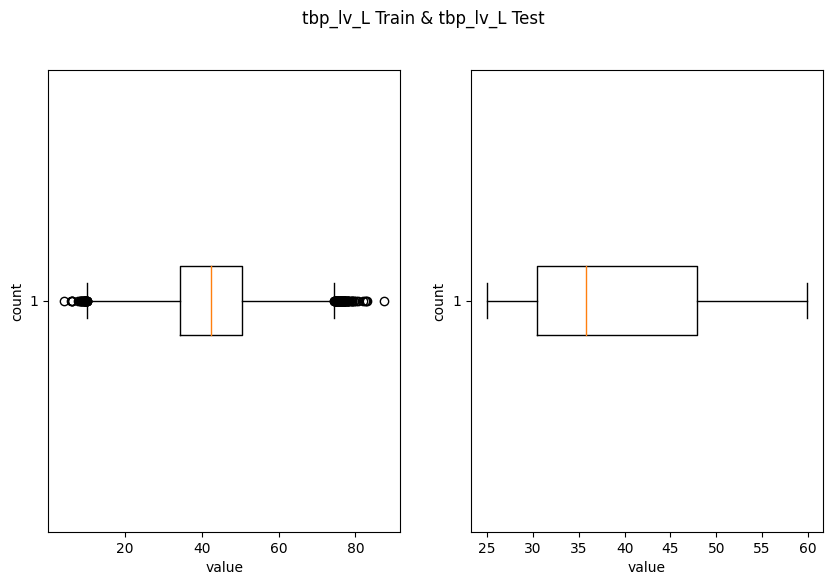

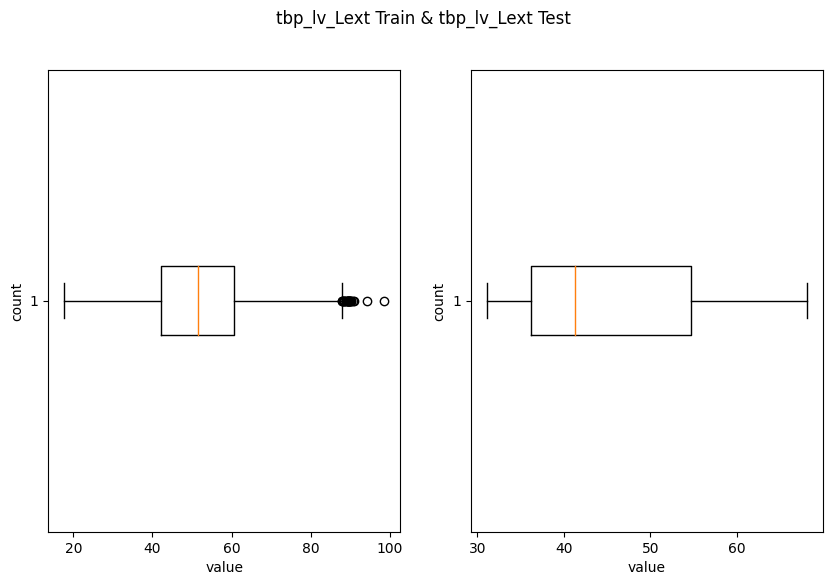

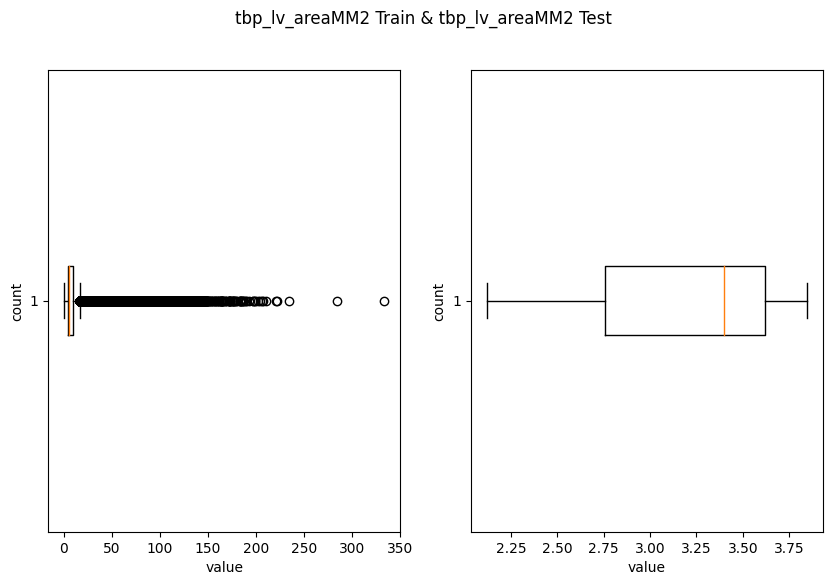

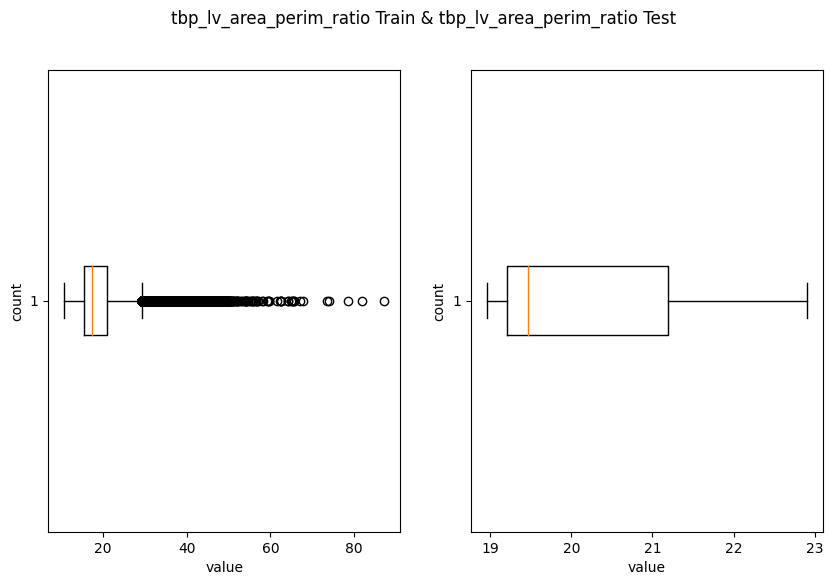

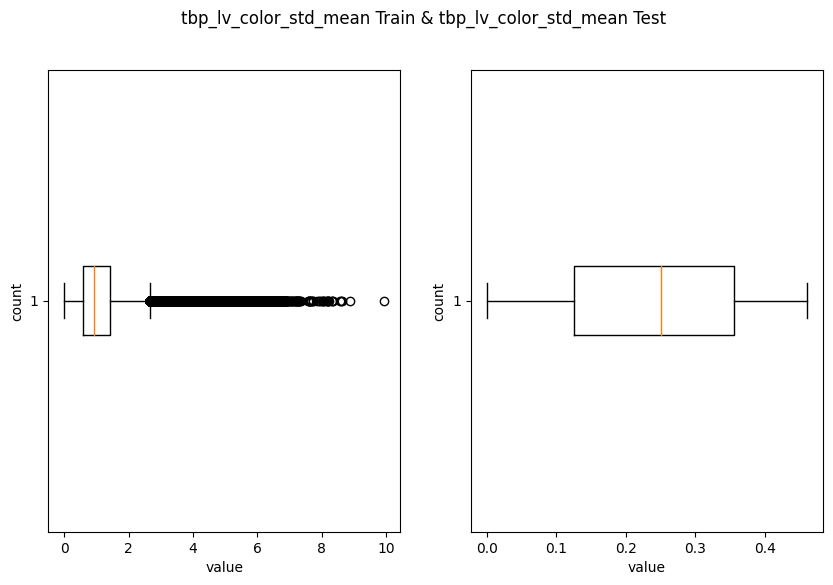

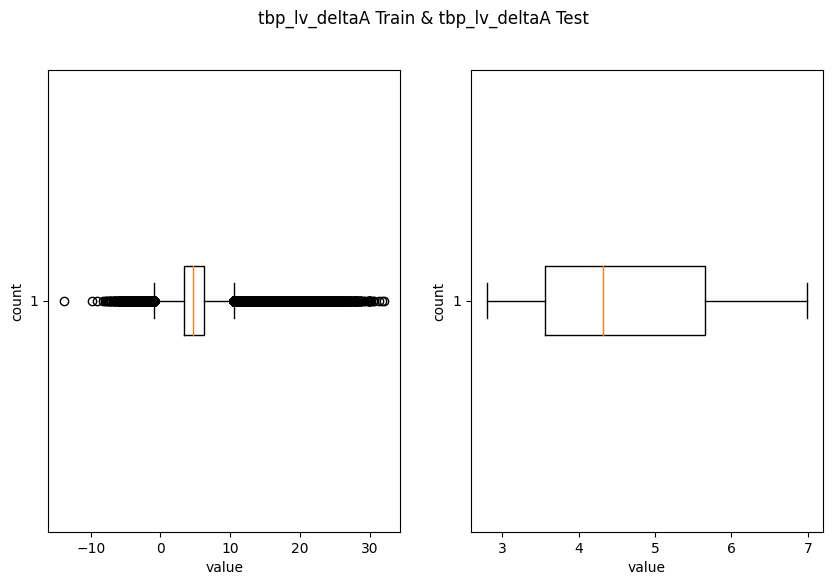

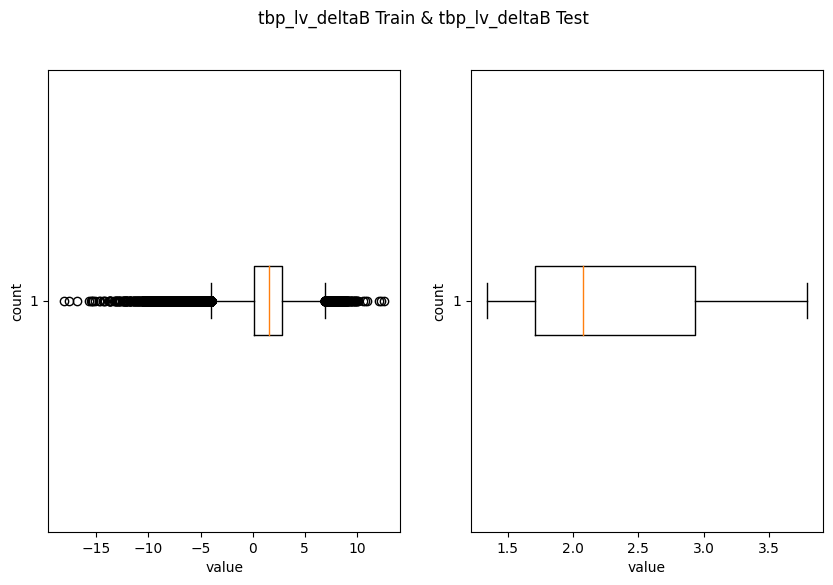

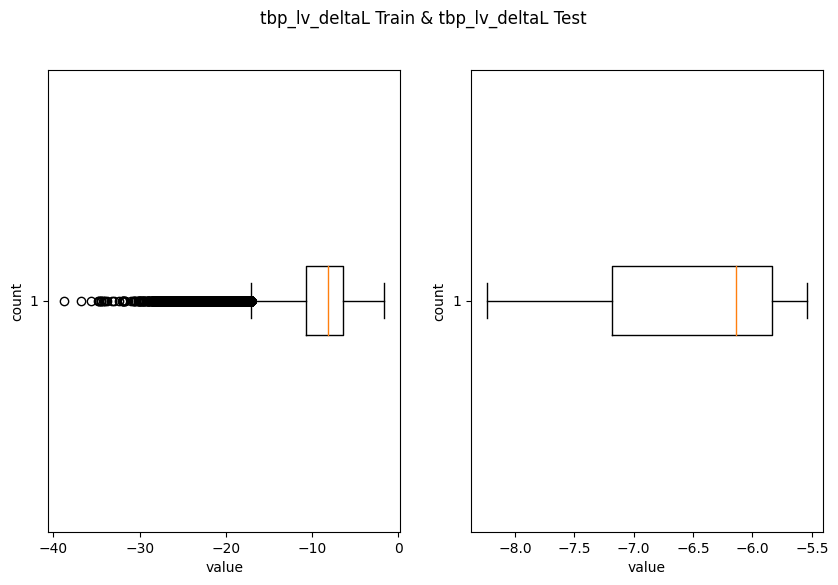

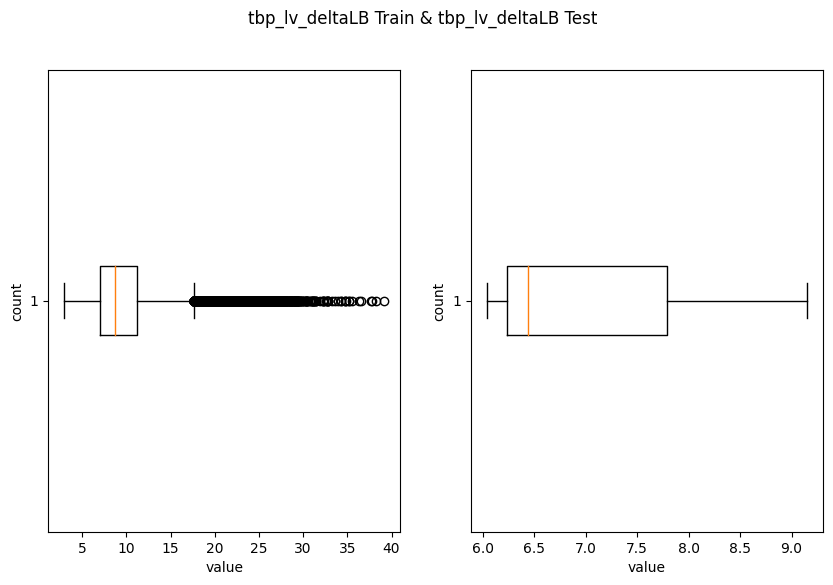

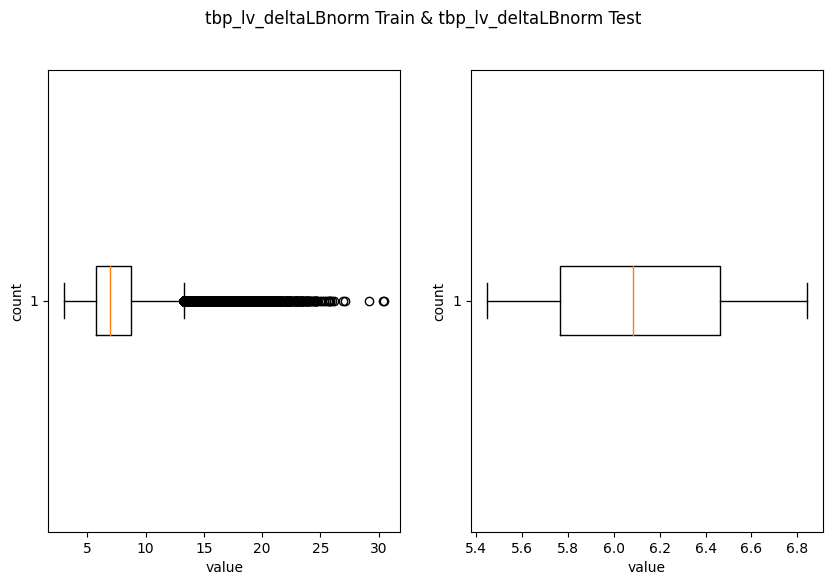

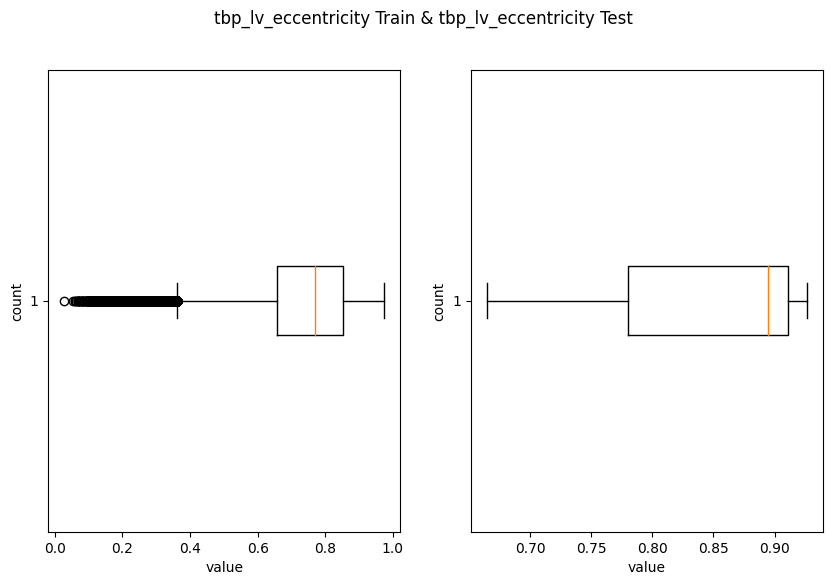

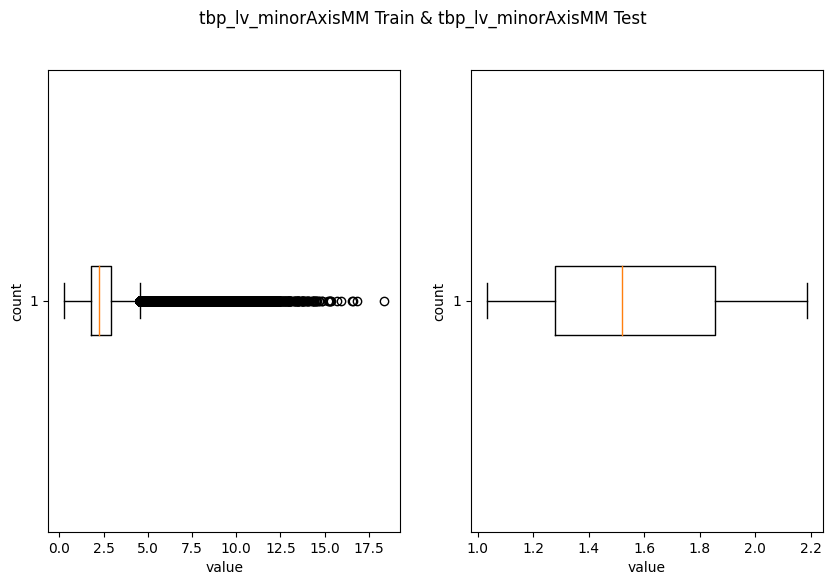

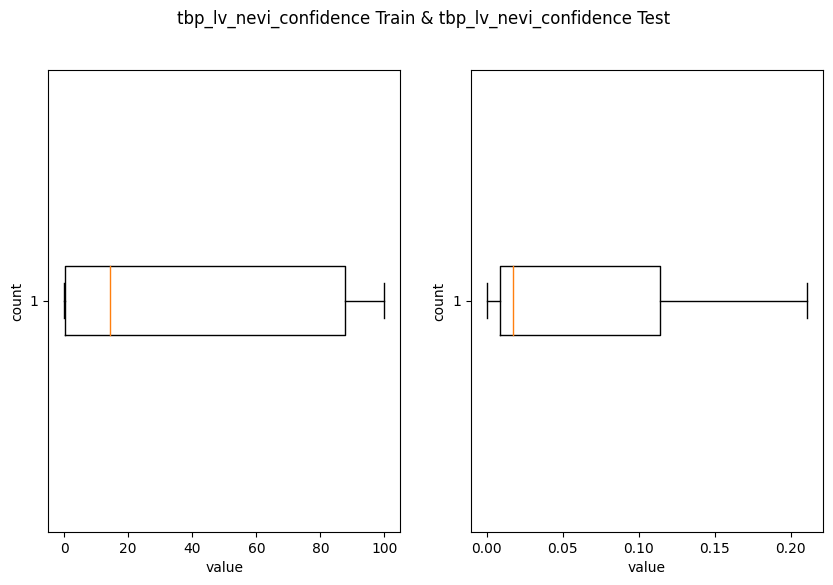

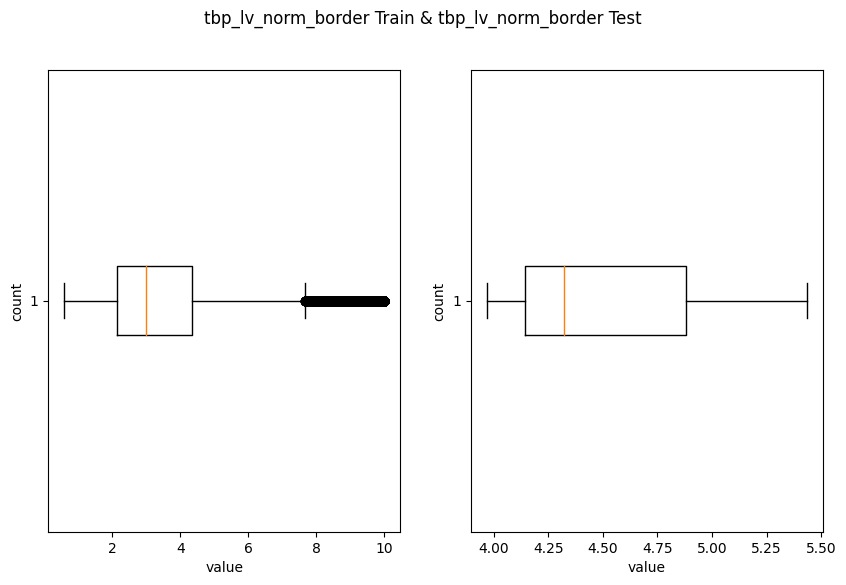

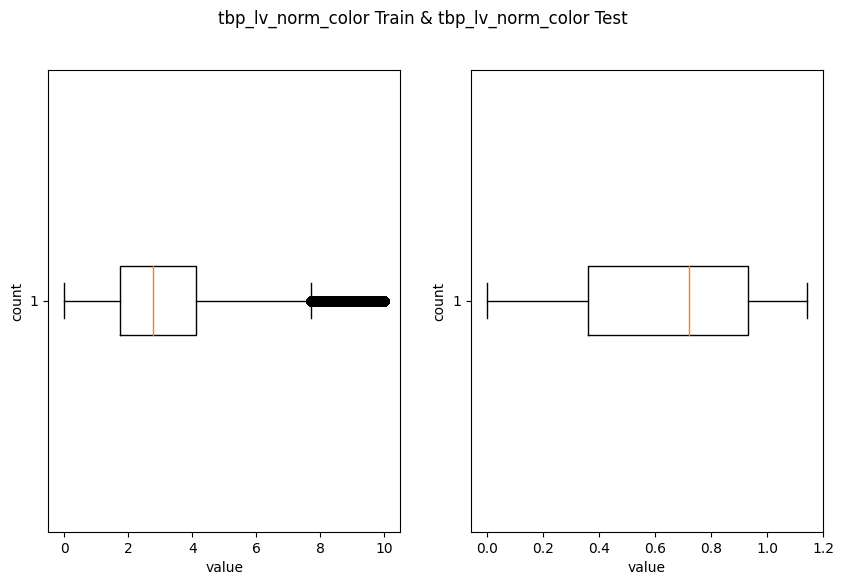

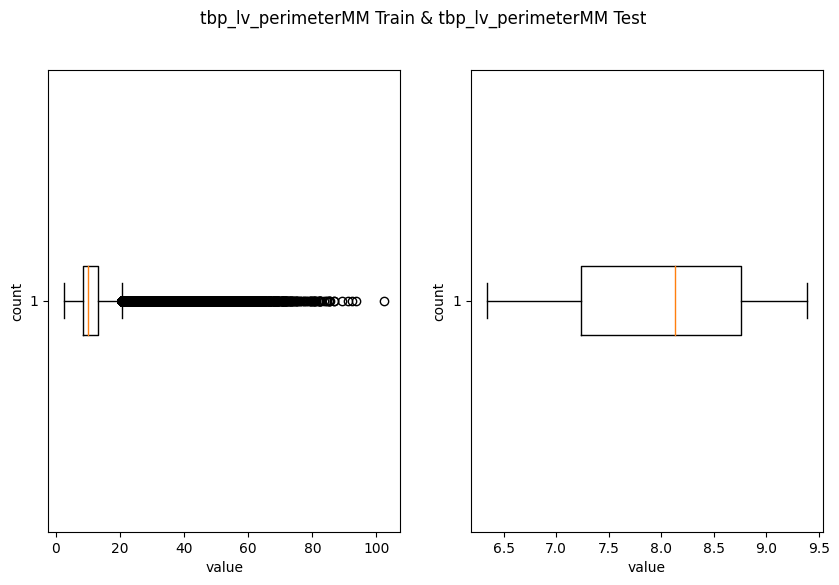

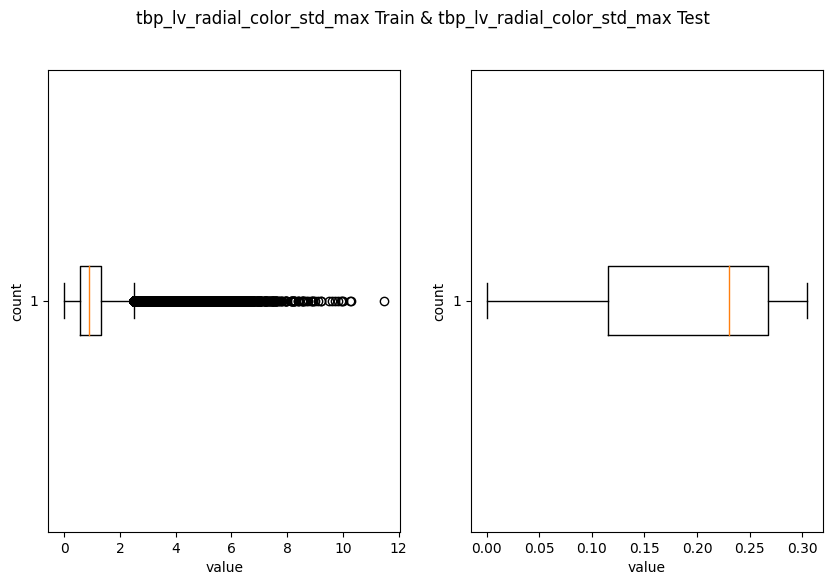

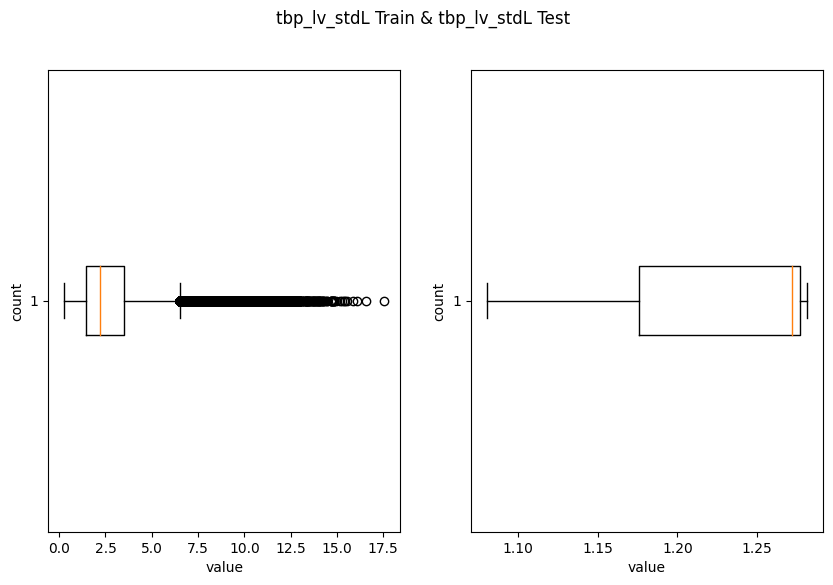

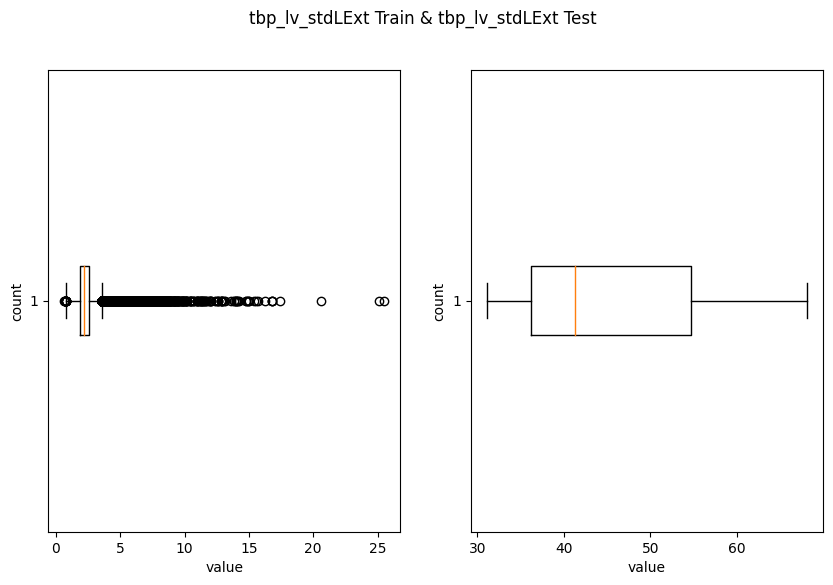

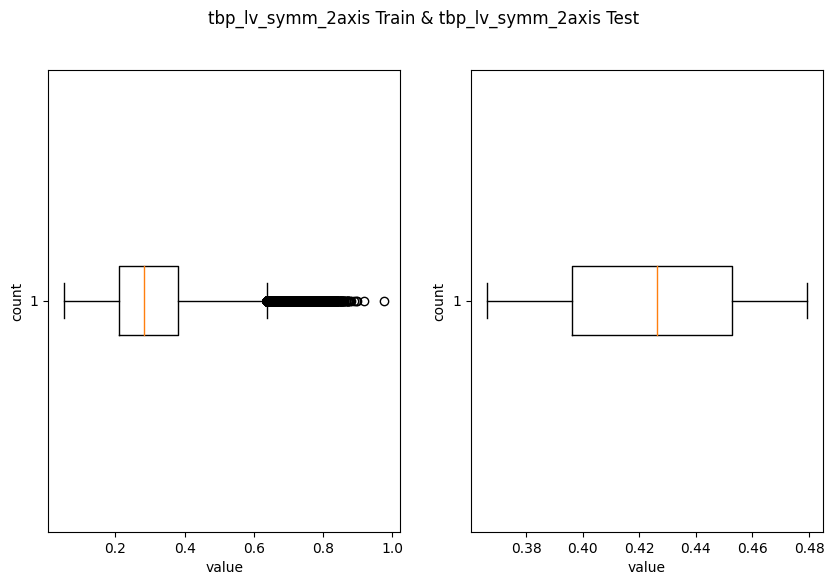

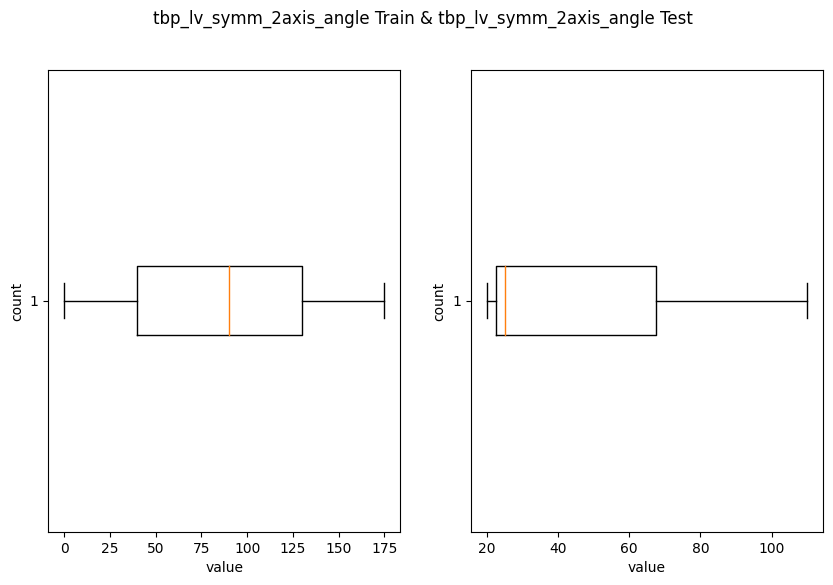

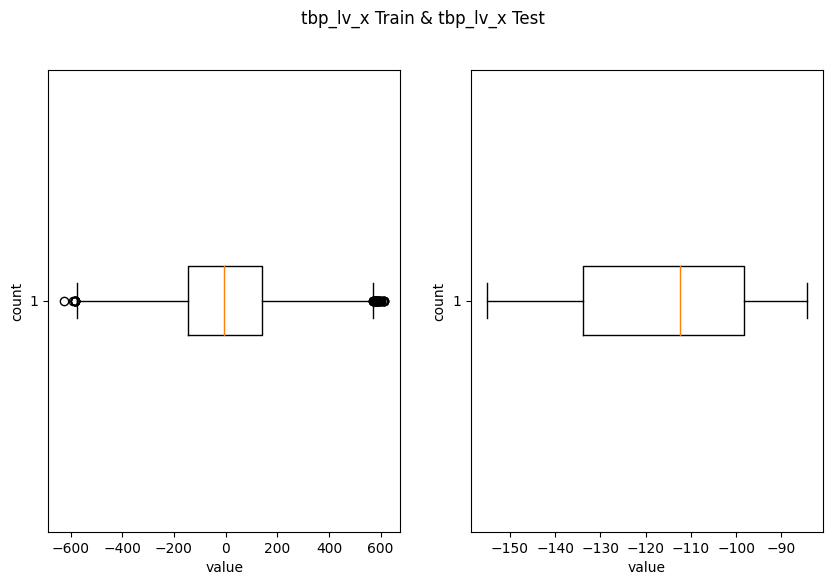

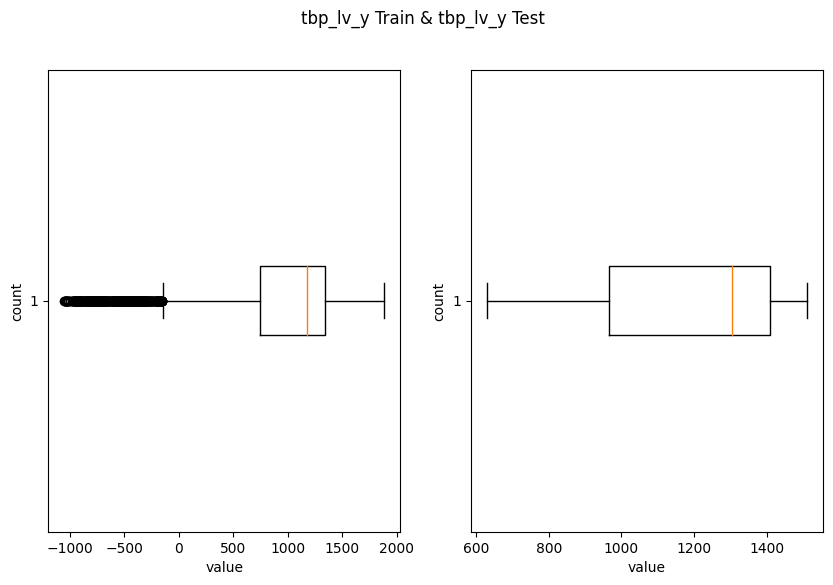

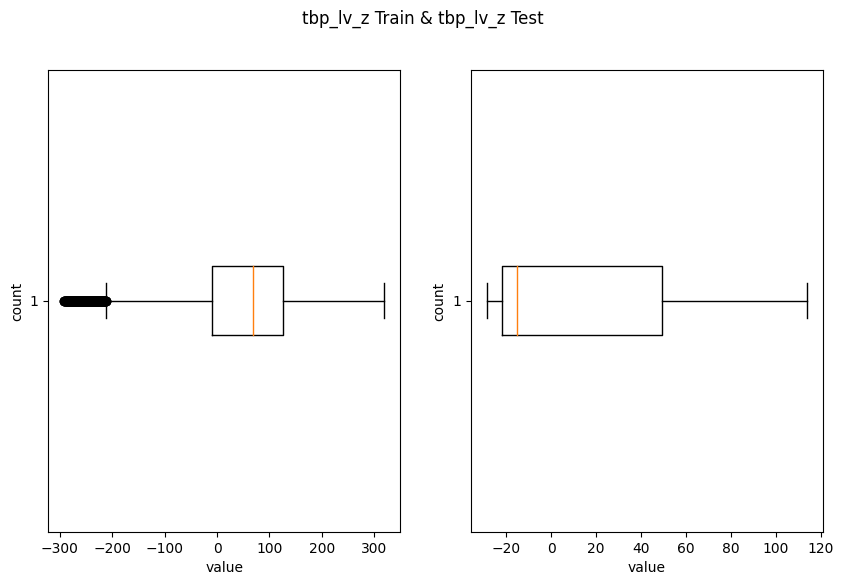

In [ ]:
for feature in features_num:
  plt.figure(figsize = (10,6))
  plot1 = plt.subplot(1,2,1)
  plot1.boxplot(df_train[feature].dropna(), vert = False)
  plot1.figure.suptitle(feature + ' Train & ' + feature + ' Test')
  plot1.set(xlabel = 'value', ylabel = 'count')
  plot2 = plt.subplot(1,2,2)
  plot2.boxplot(df_test[feature].dropna(), vert = False)
  plot2.set(xlabel = 'value', ylabel = 'count')
  plt.show()
  print()
  print()

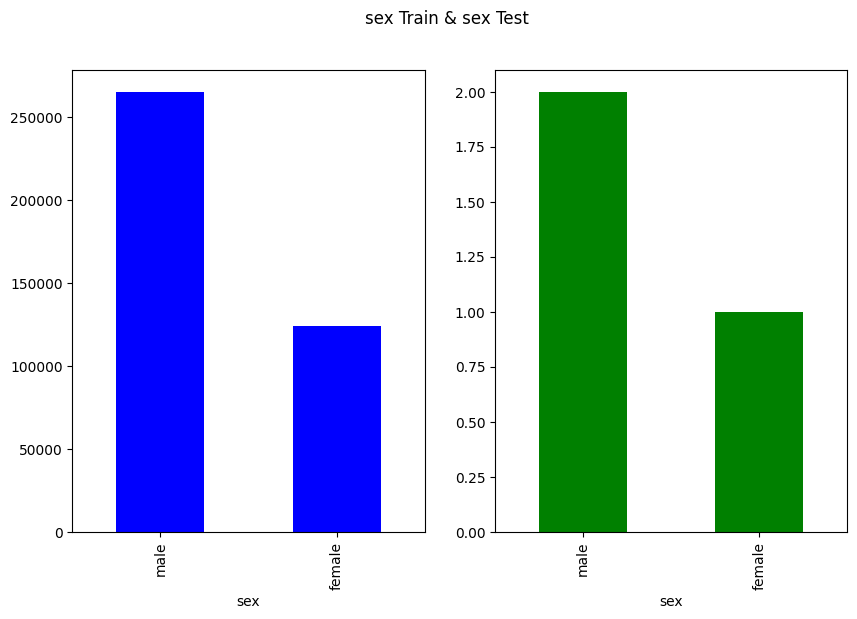

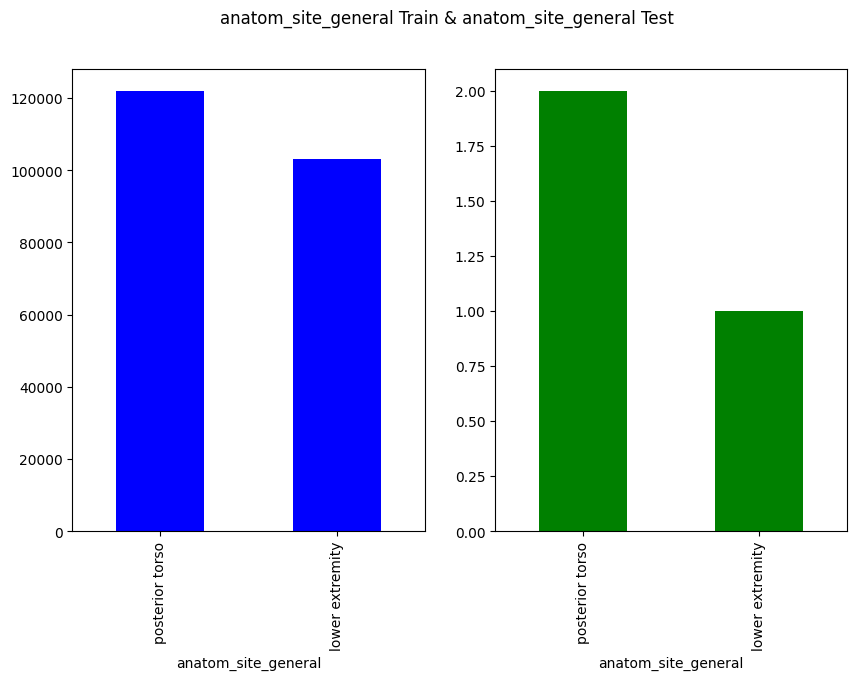

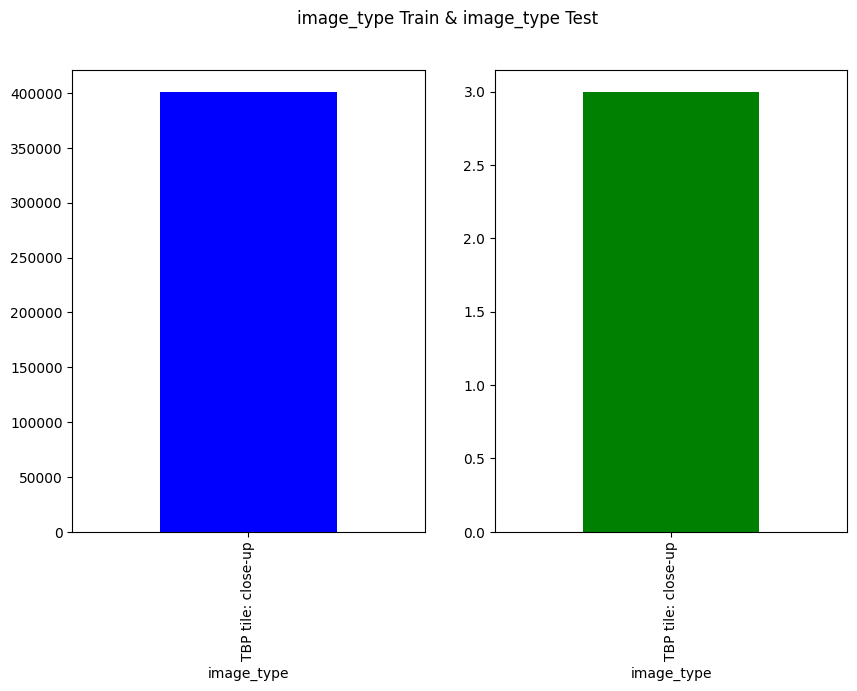

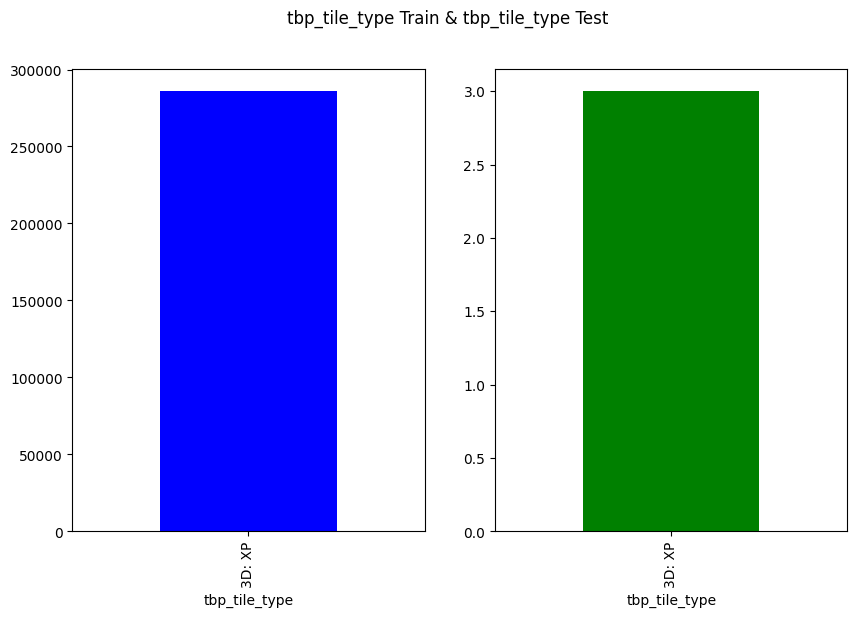

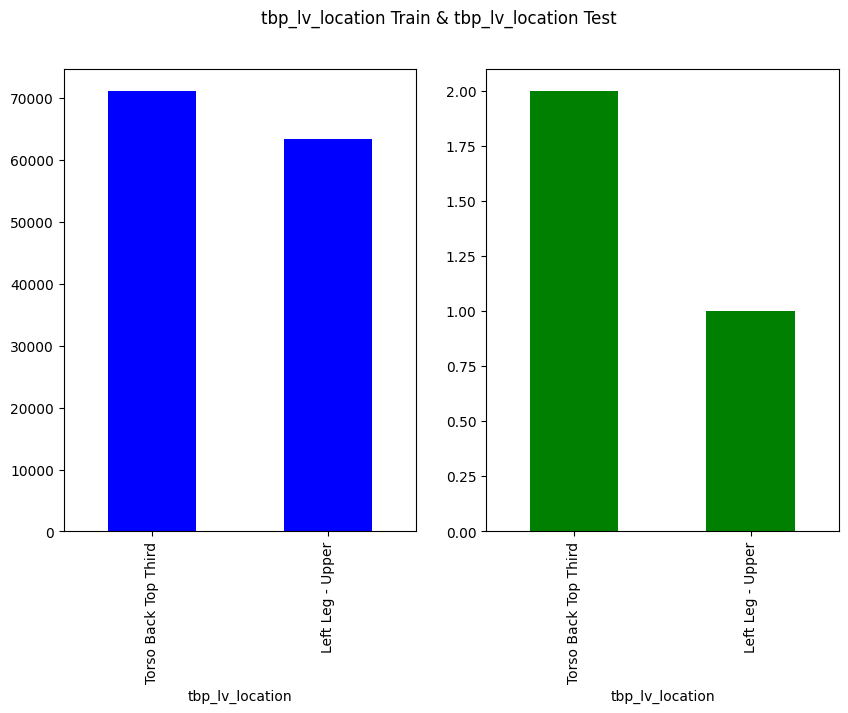

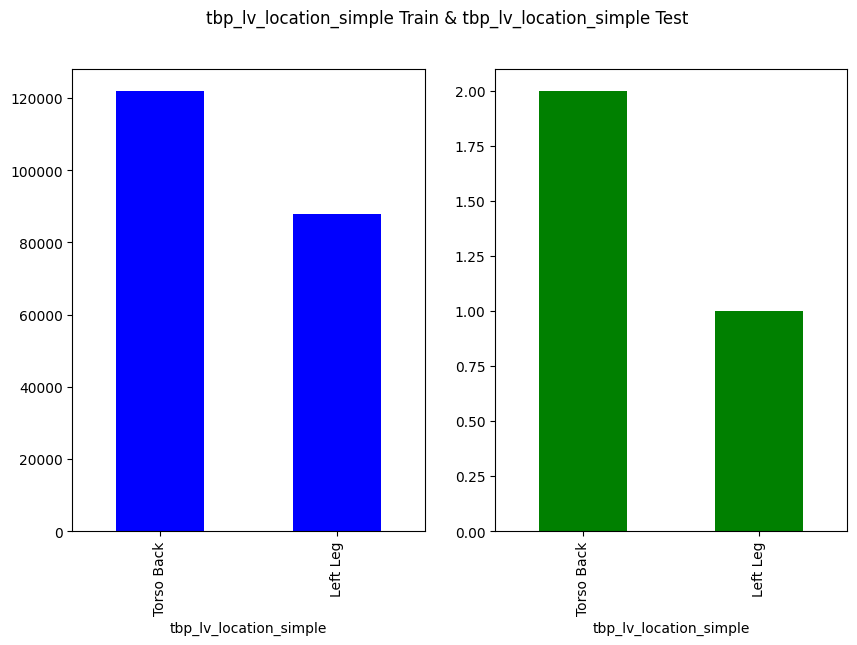

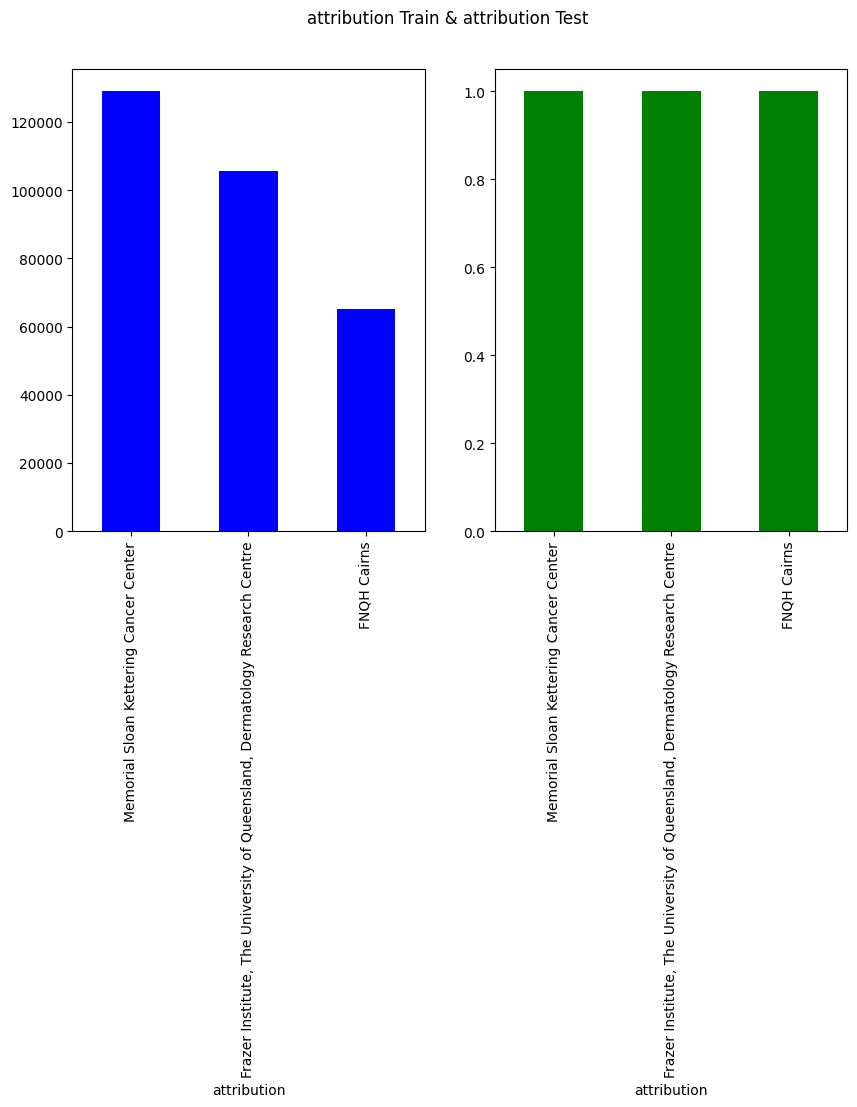

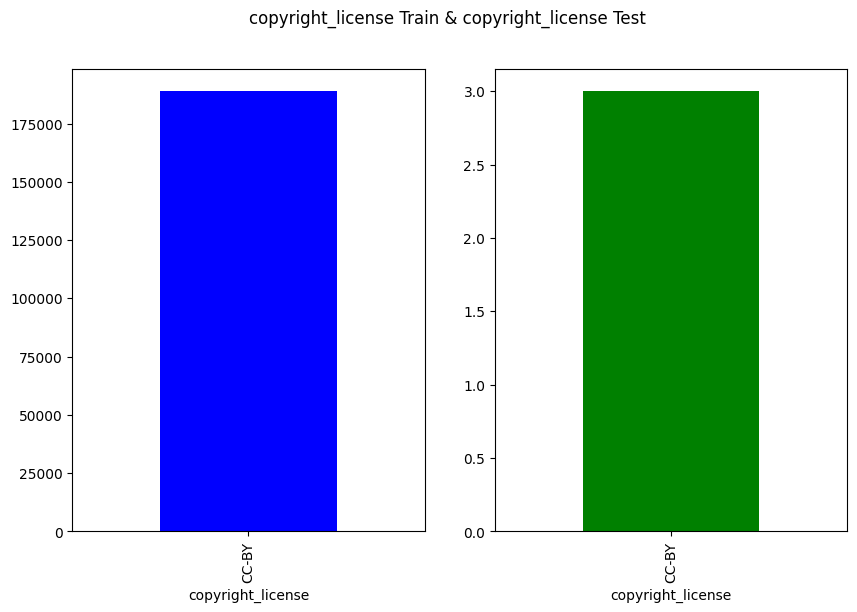

In [ ]:
for feature in features_cat:
  plt.figure(figsize = (10,6))
  plot1 = plt.subplot(1,2,1)
  df_train[feature].value_counts().plot(kind = 'bar', color = default_color_1)
  plot1.figure.suptitle(feature + ' Train & ' + feature + ' Test')
  plot2 = plt.subplot(1,2,2, sharex = plot1)
  df_test[feature].value_counts().plot(kind = 'bar', color = default_color_2)
  plt.show()
  print()
  print()

In [ ]:
# dropping non-relevant features
features_cat.remove('image_type')
features_cat.remove('tbp_tile_type')
features_cat.remove('copyright_license')

# Setting up the Train Set

In [ ]:
features_num_train = ['mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']
features_cat_train = ['iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index']

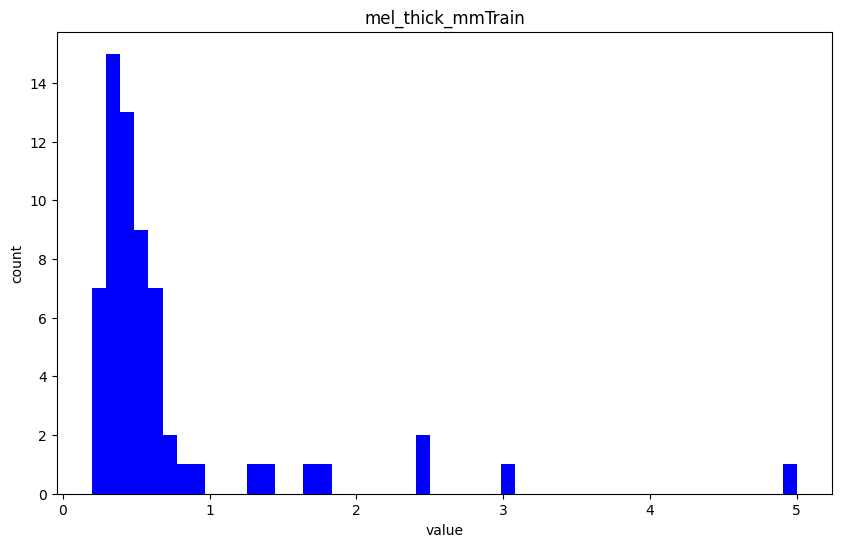

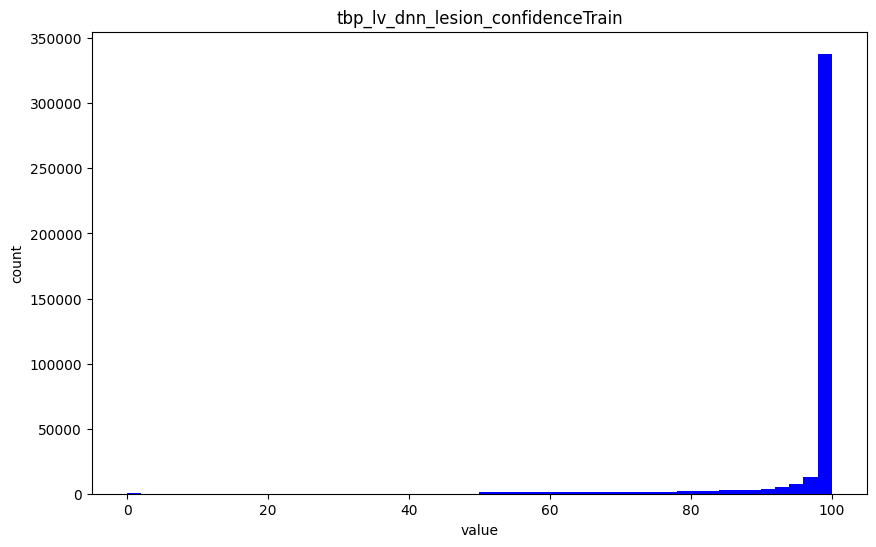

In [ ]:
for feature in features_num_train:
  plt.figure(figsize = (10,6))
  plt.hist(df_train[feature], bins = 50, color = default_color_1)
  plt.title(feature + 'Train')
  plt.xlabel('value')
  plt.ylabel('count')
  plt.show()

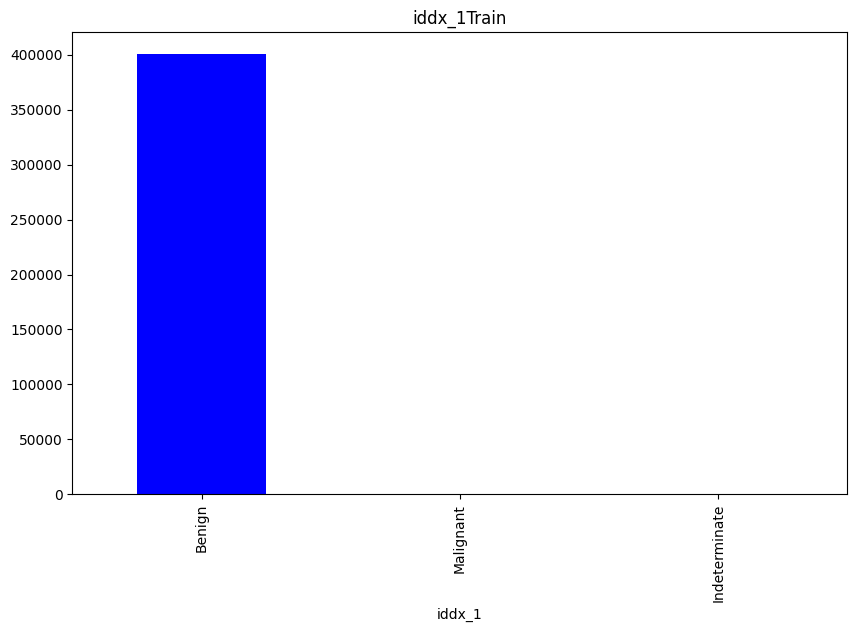

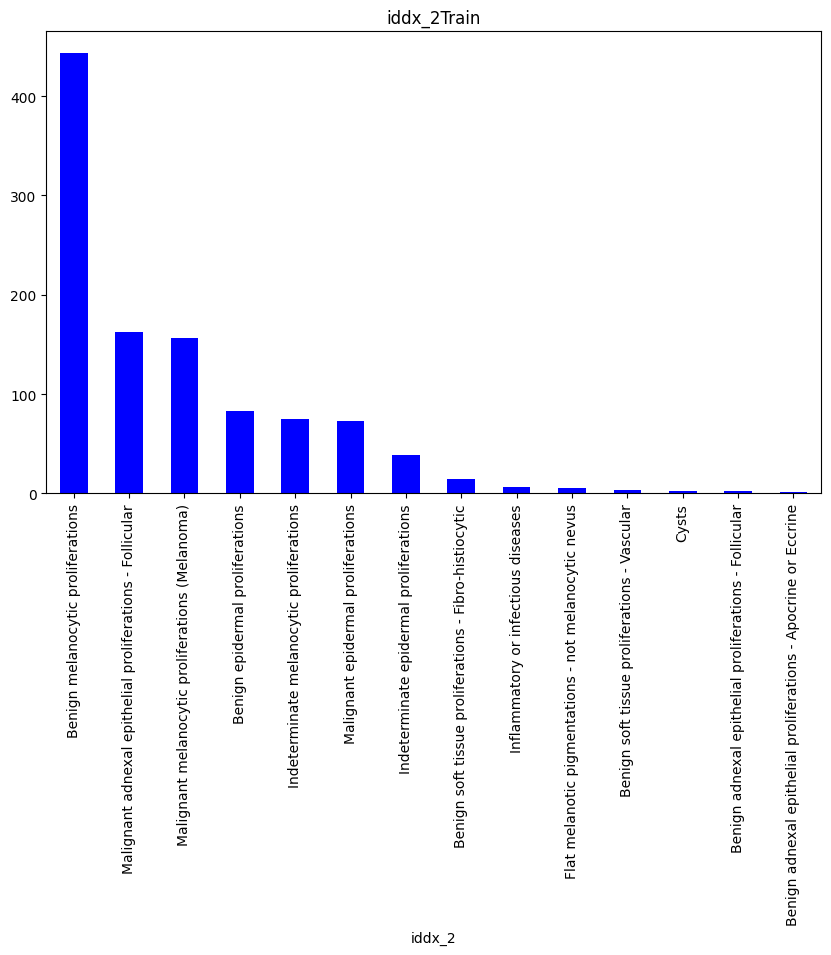

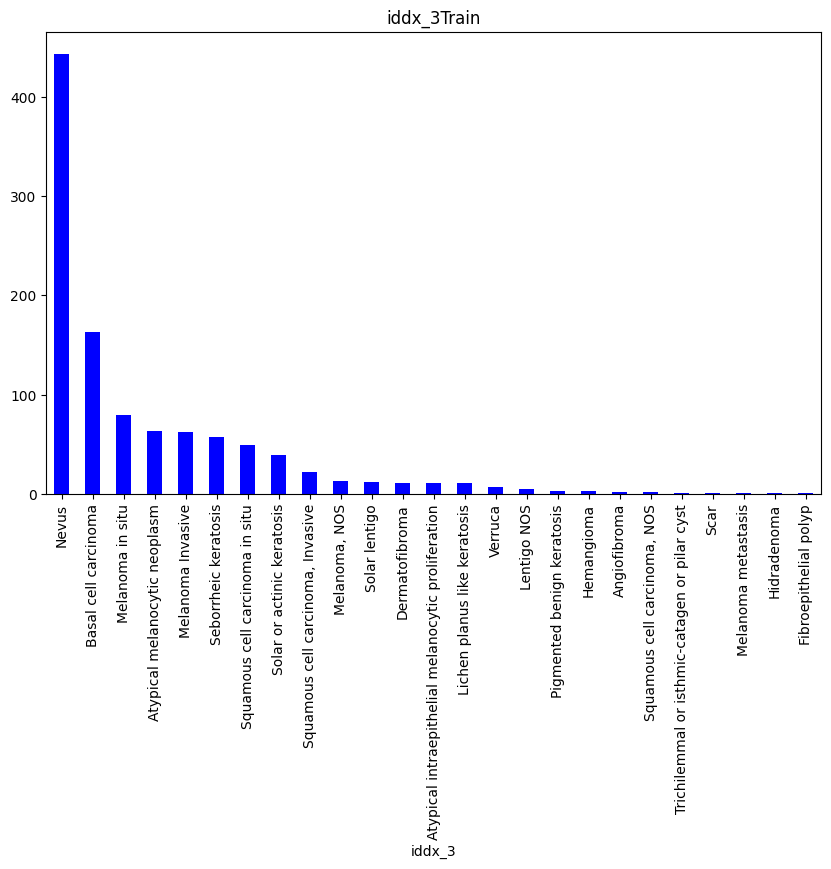

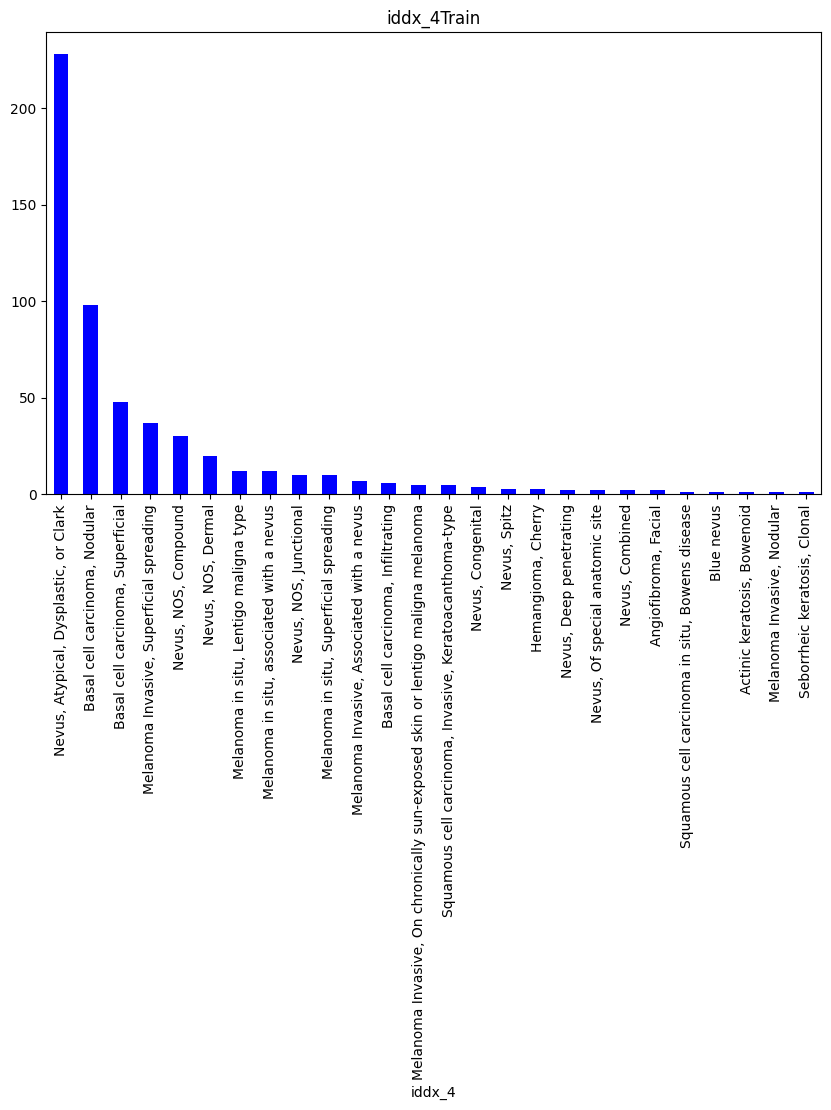

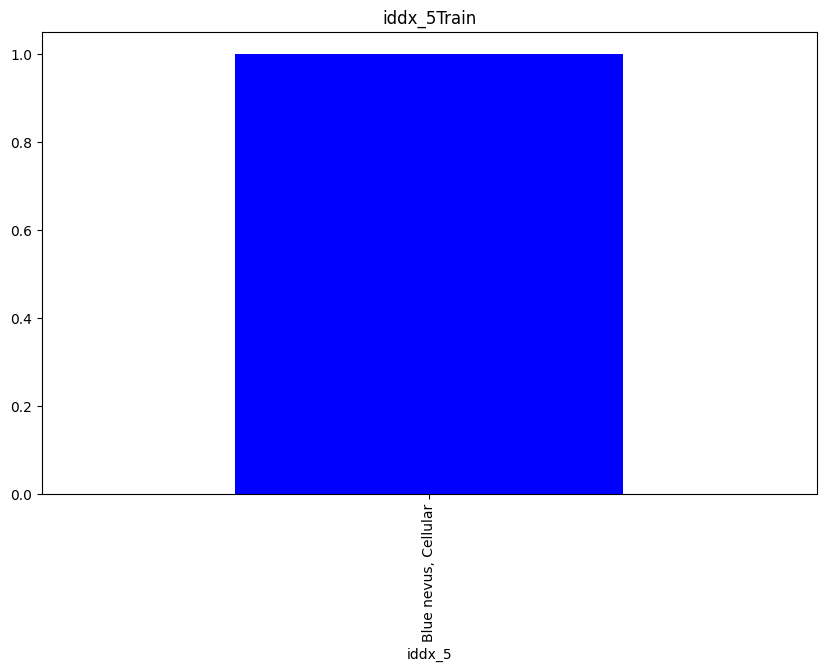

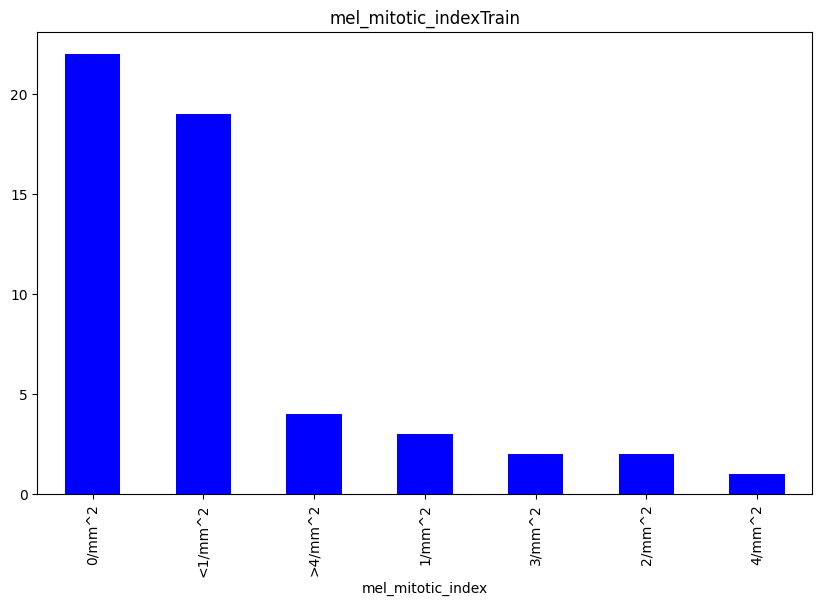

In [ ]:
for feature in features_cat_train:
  plt.figure(figsize = (10,6))
  df_train[feature].value_counts().plot(kind = 'bar', color = default_color_1)
  plt.title(feature + 'Train')
  plt.show()
  print()
  print()

# Discovering Correlation in Train Set

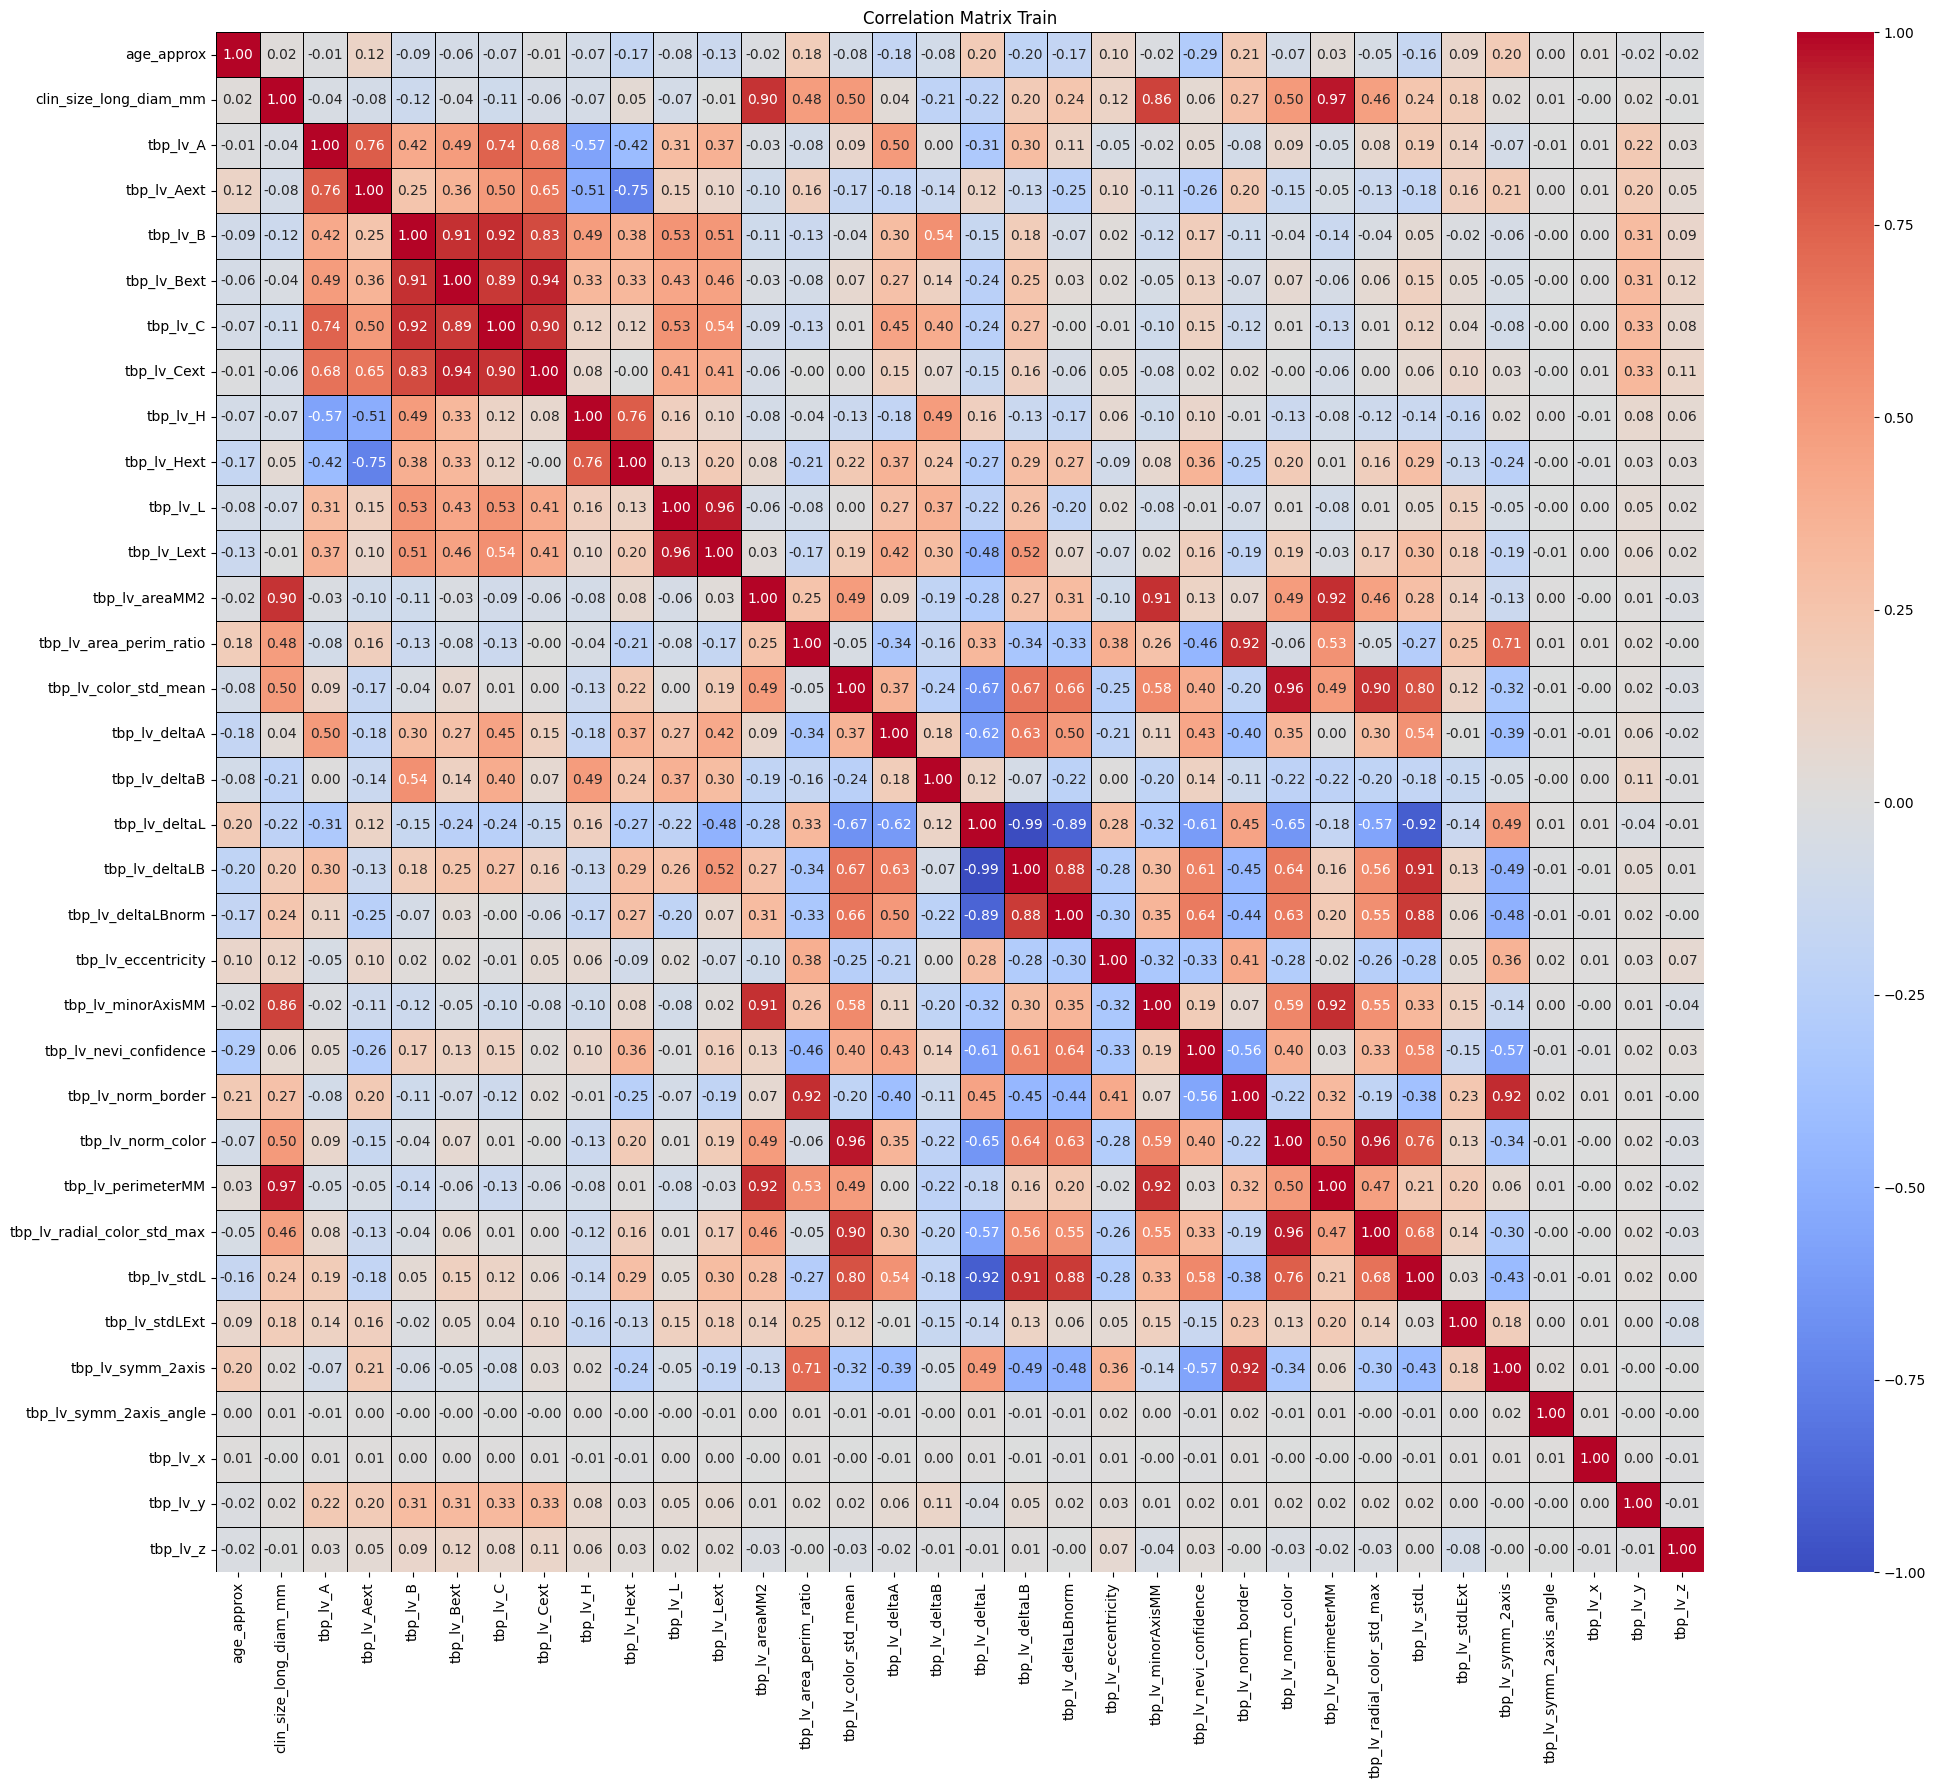

In [ ]:
#Spearson Correlation
corr = df_train[features_num].corr()
plt.figure(figsize = (24, 20))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmax = +1, vmin = -1, linewidths = 0.5, linecolor = 'black', fmt = '.2f')
plt.title('Correlation Matrix Train')
plt.show()

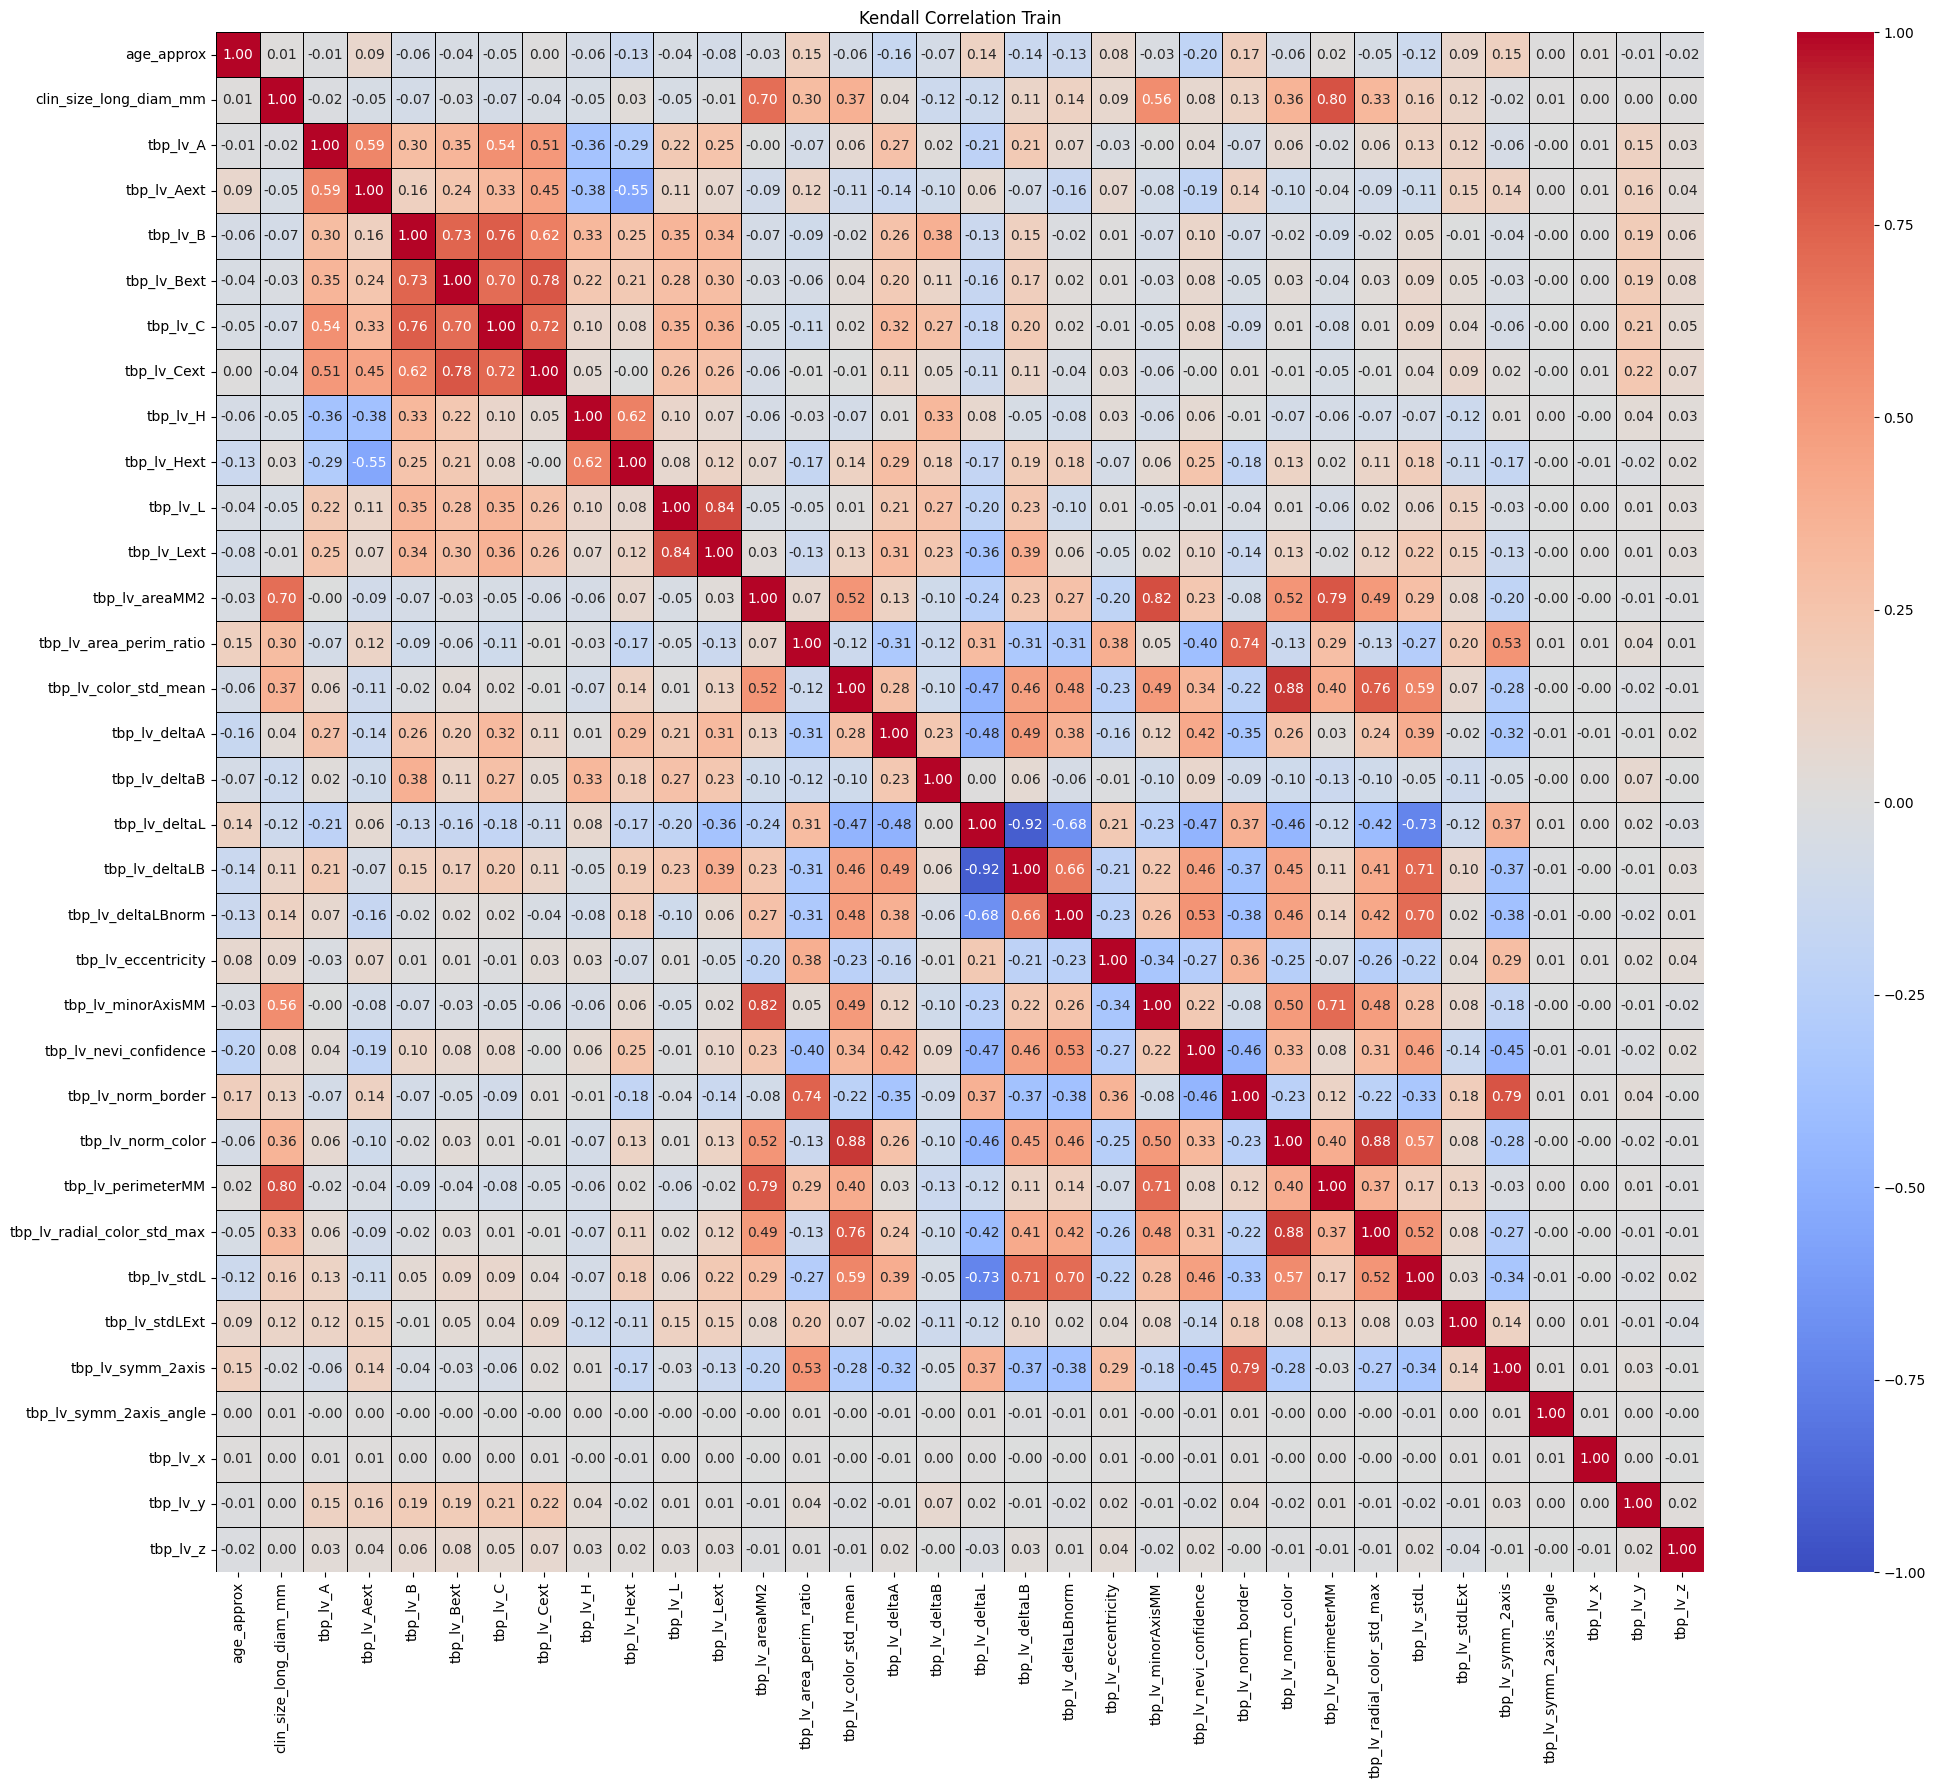

In [ ]:
#Kendall Correlation

corr_matrix = df_train[features_num].corr(method = 'kendall')
plt.figure(figsize = (24,20))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmax = +1, vmin = -1, linewidths = .5, linecolor = 'black', fmt = '.2f')
plt.title('Kendall Correlation Train')
plt.show()


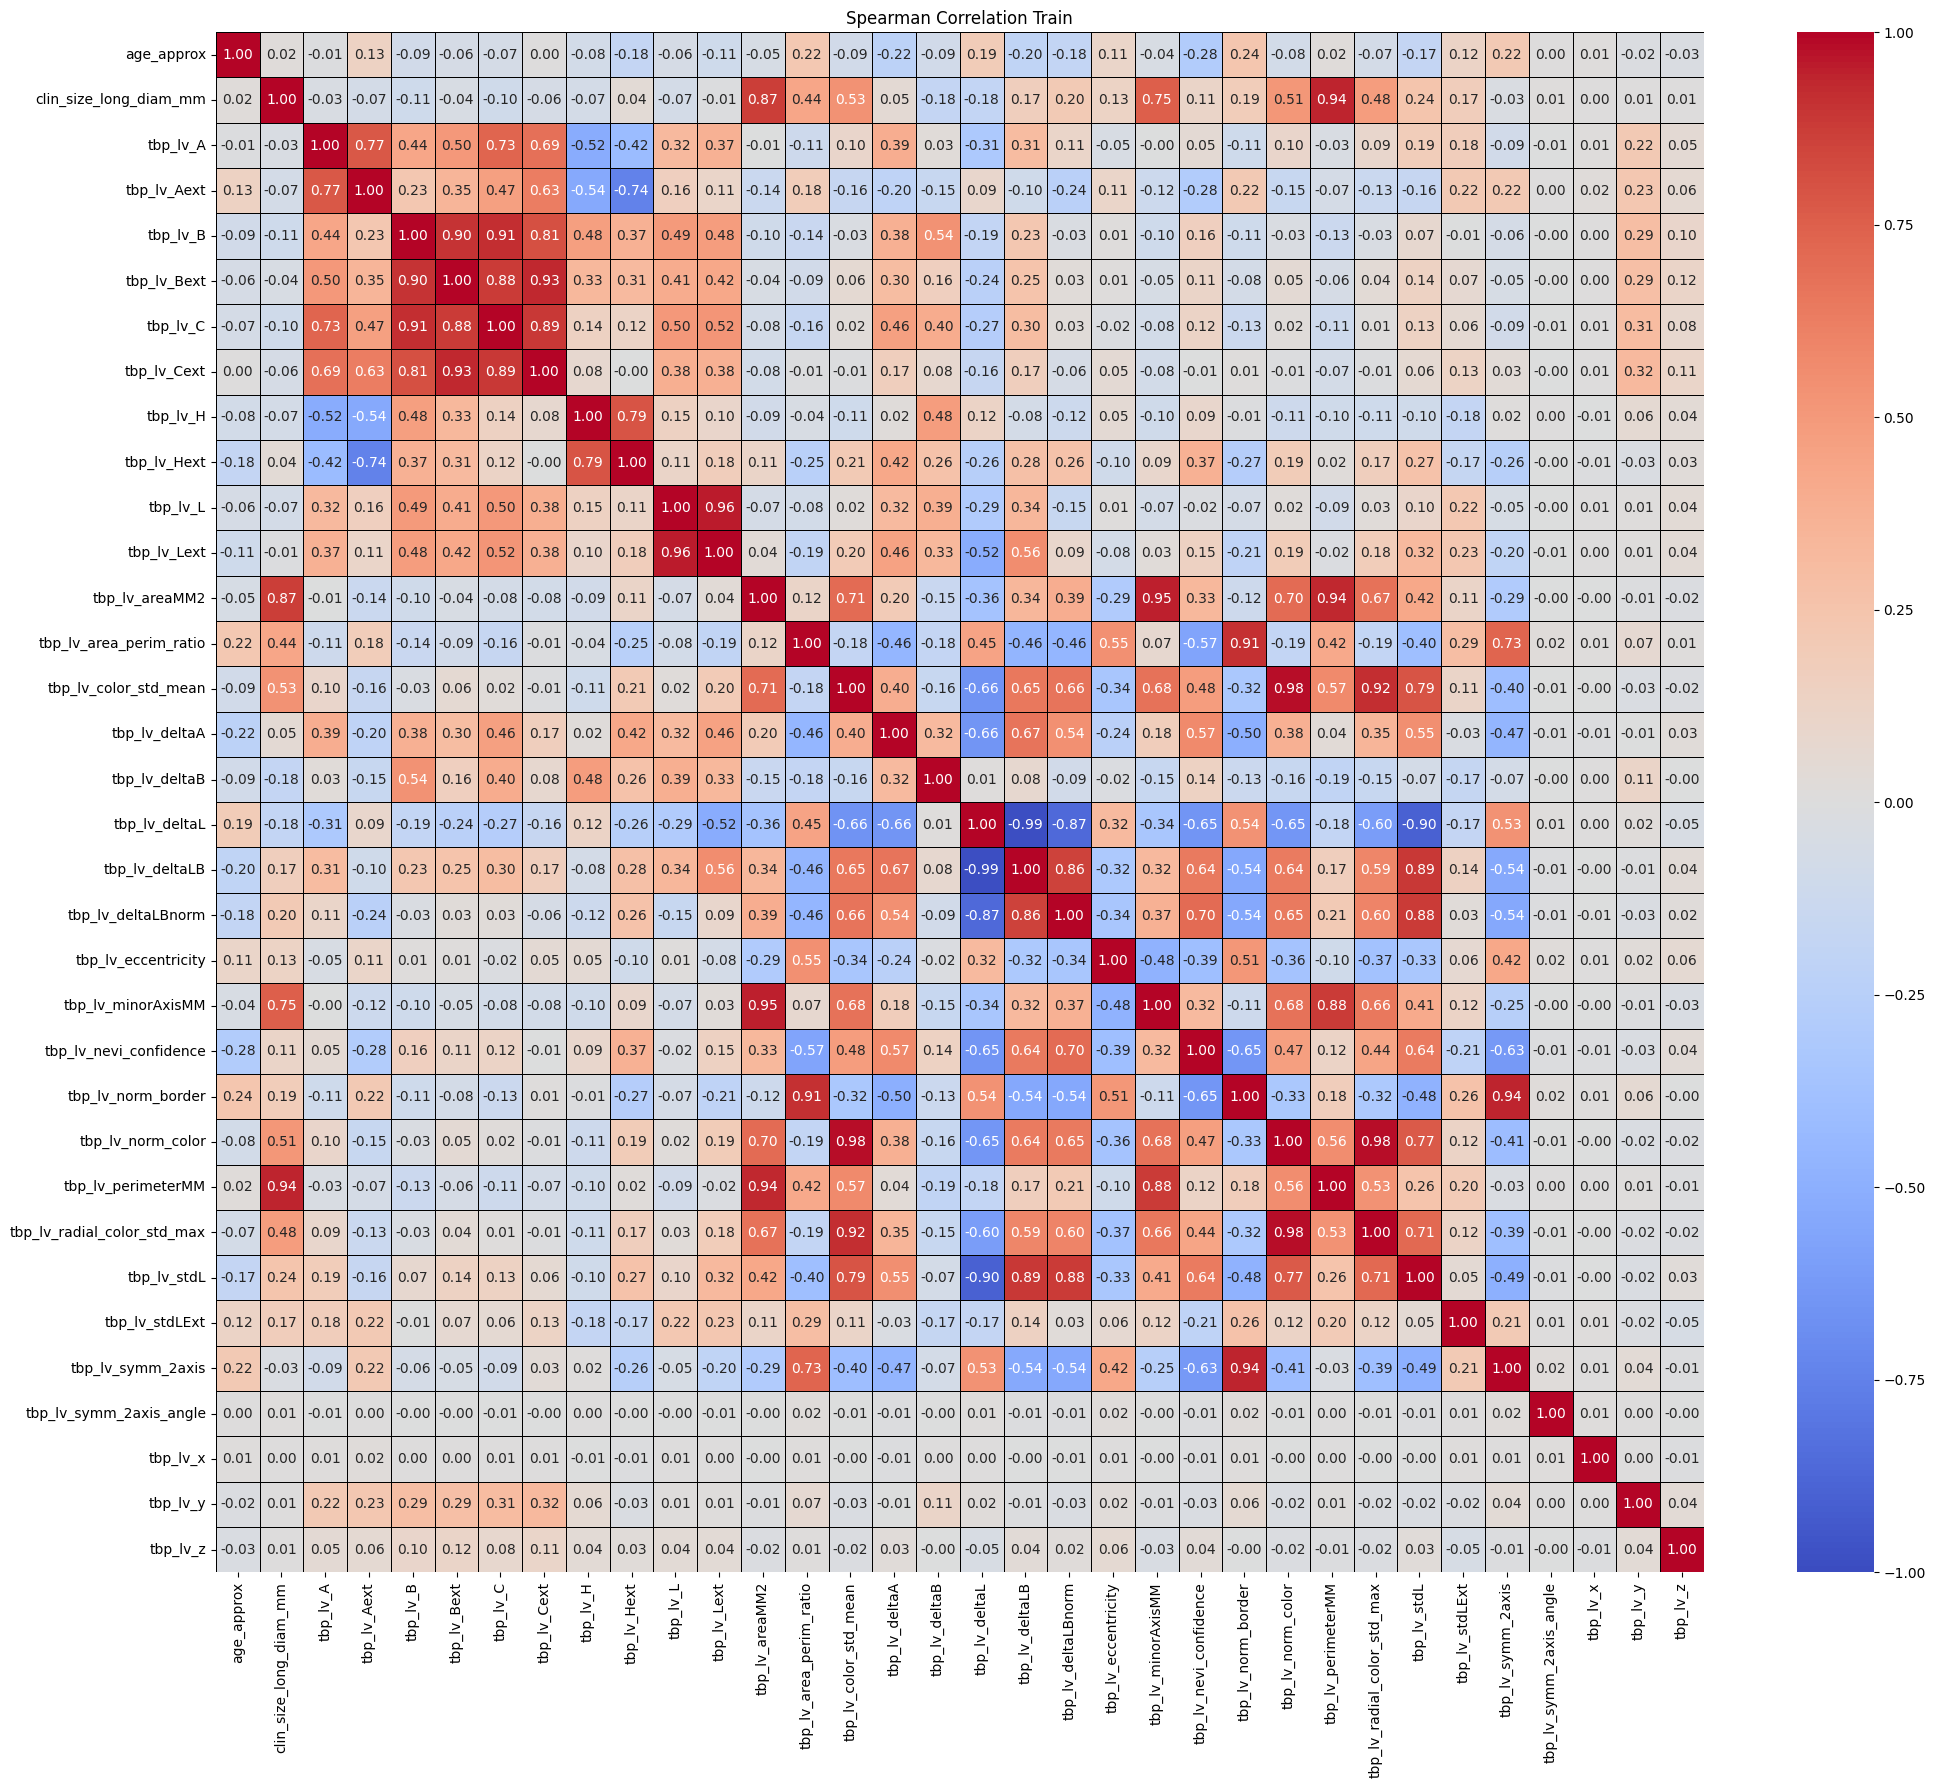

In [ ]:
#Spearman Correlation

spearman_corr = df_train[features_num].corr(method = 'spearman')
plt.figure(figsize = (24,20))
sns.heatmap(spearman_corr, annot = True, cmap = 'coolwarm', vmax = + 1, vmin = -1, linewidths = 0.5, linecolor = 'black', fmt = '.2f')
plt.title('Spearman Correlation Train')
plt.show()

# Target vs Features

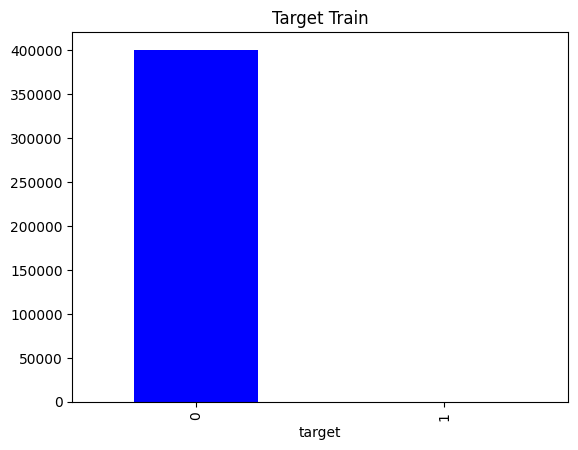

In [ ]:
df_train[target].value_counts().plot(kind = 'bar', color = default_color_1)
plt.title('Target Train')
plt.show()

In [ ]:
df_train[target].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

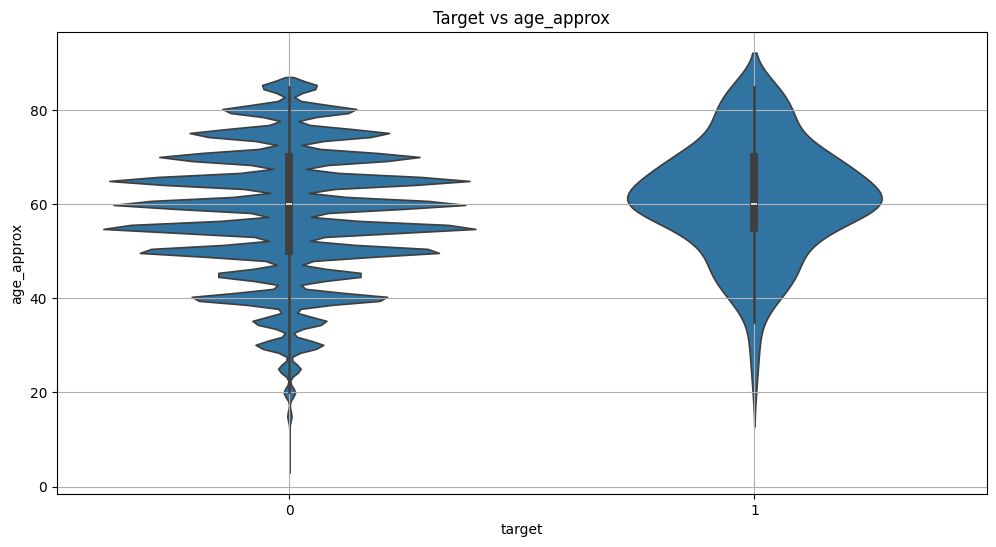

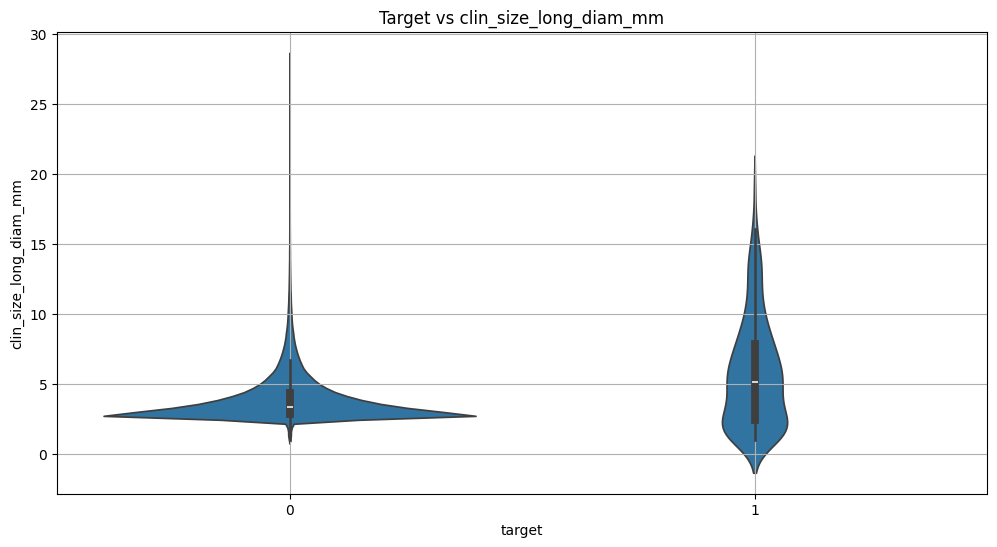

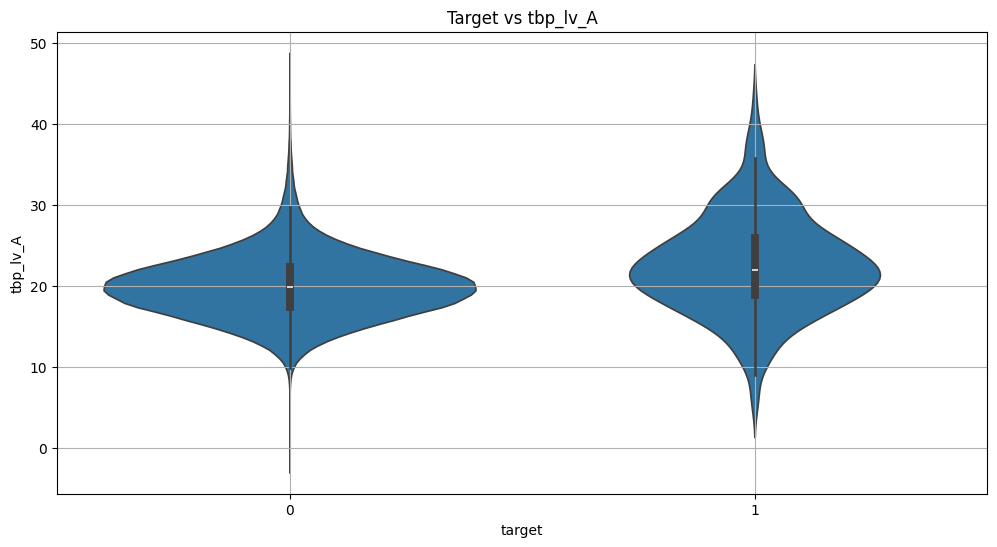

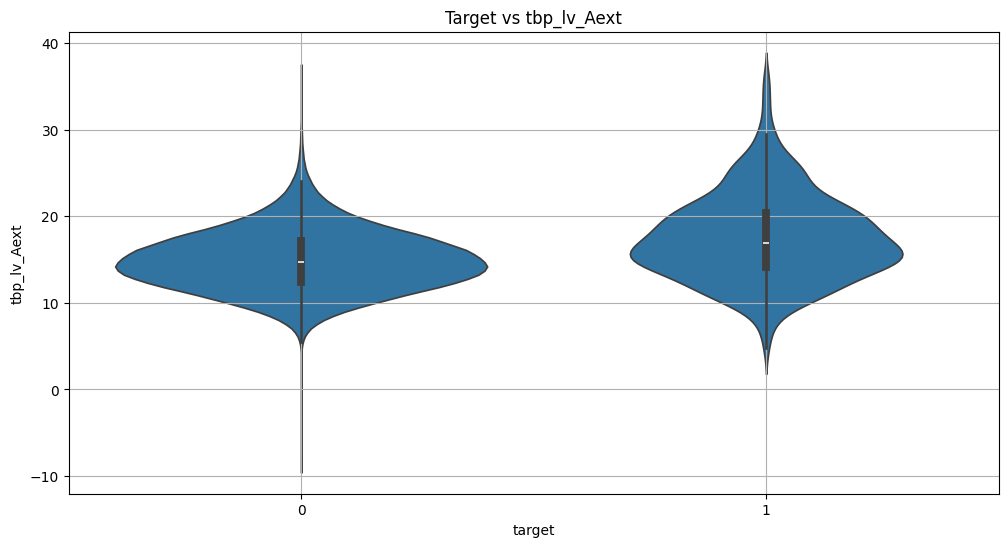

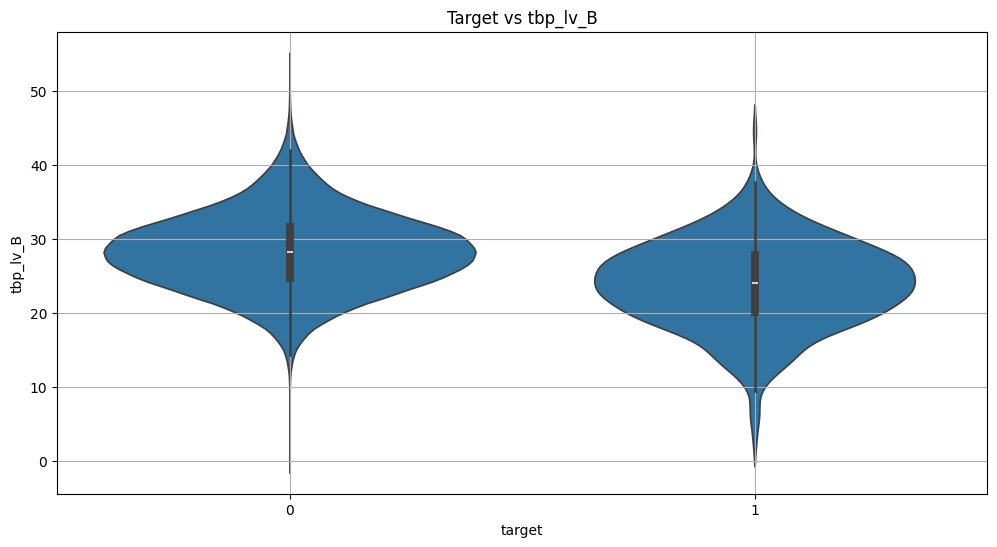

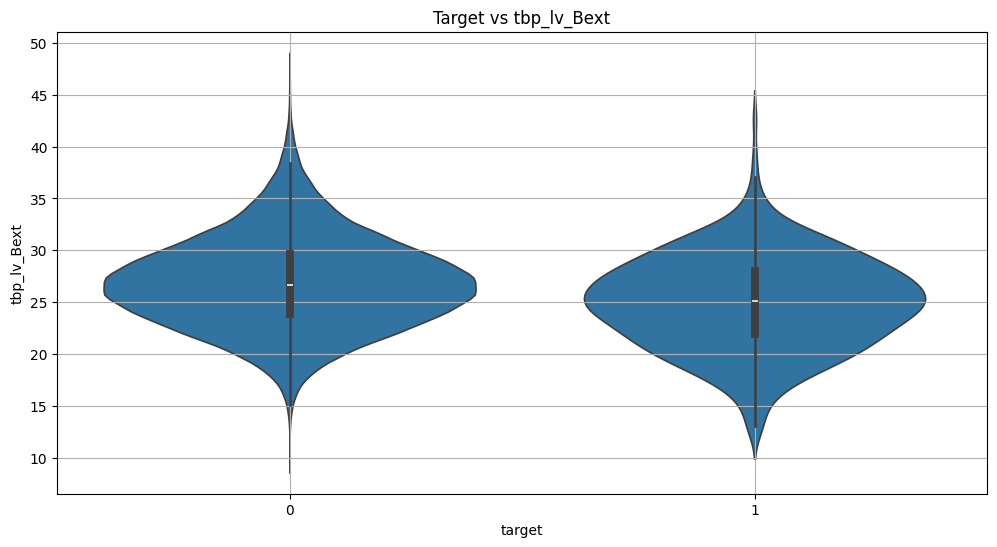

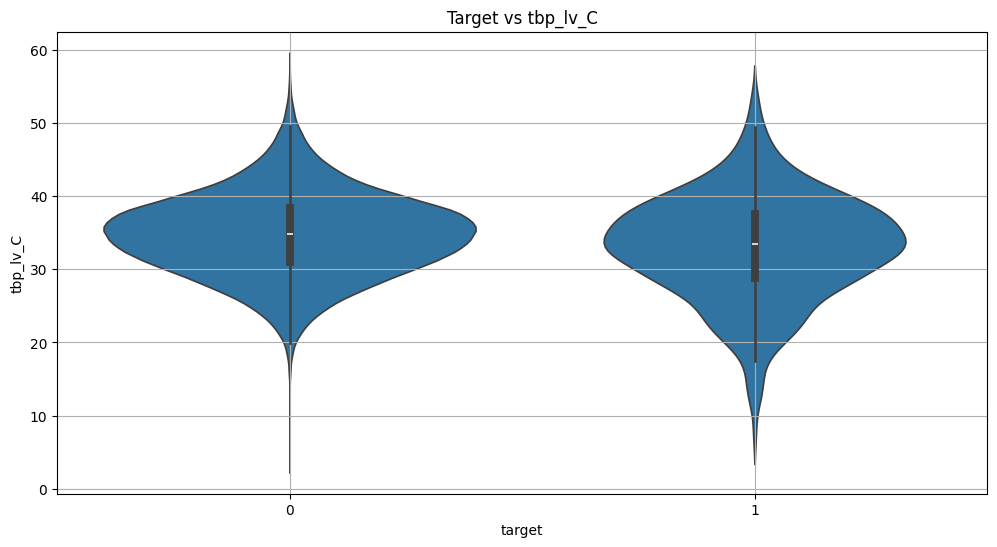

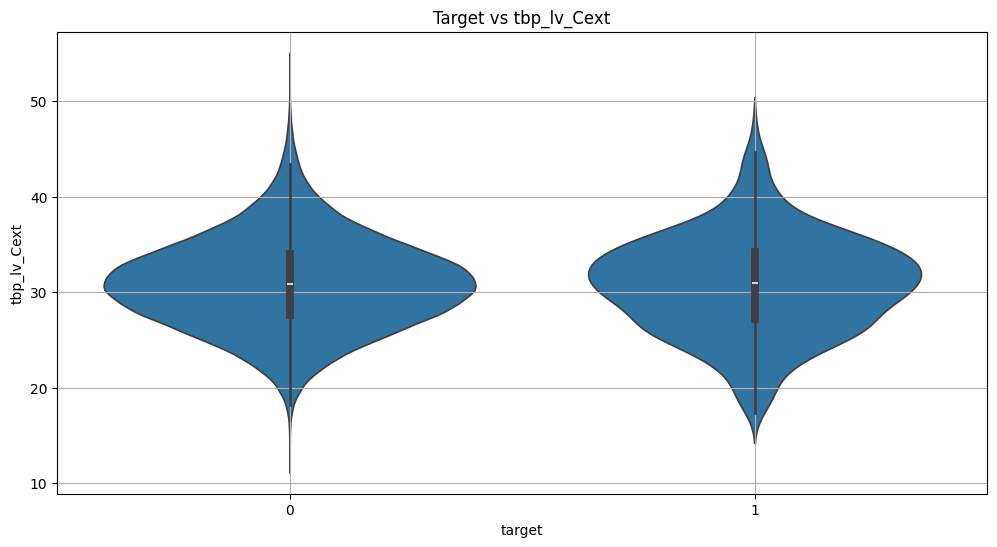

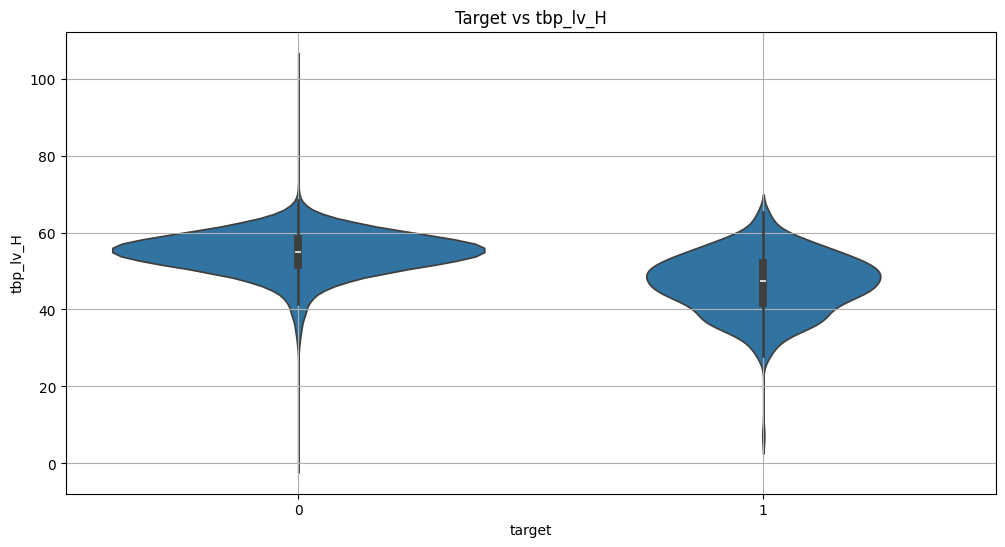

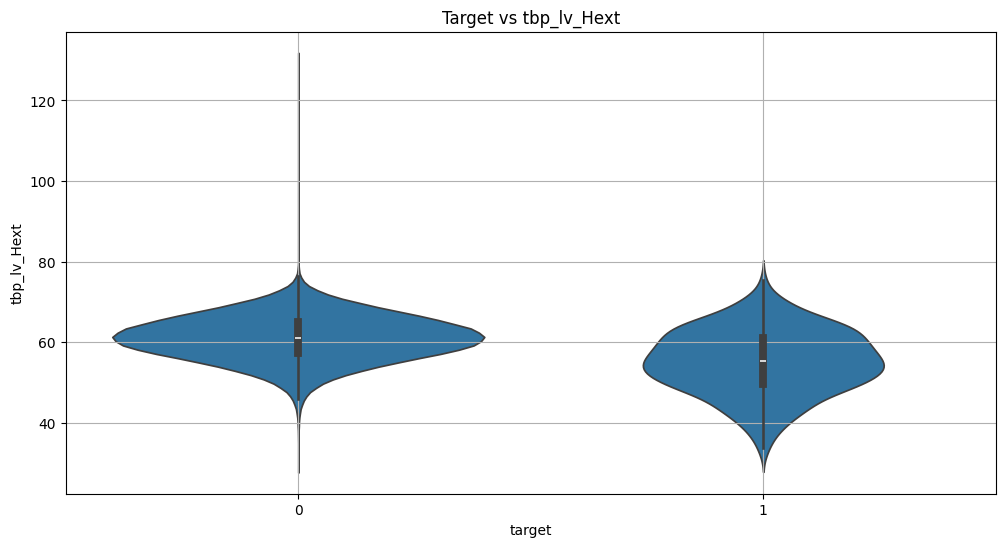

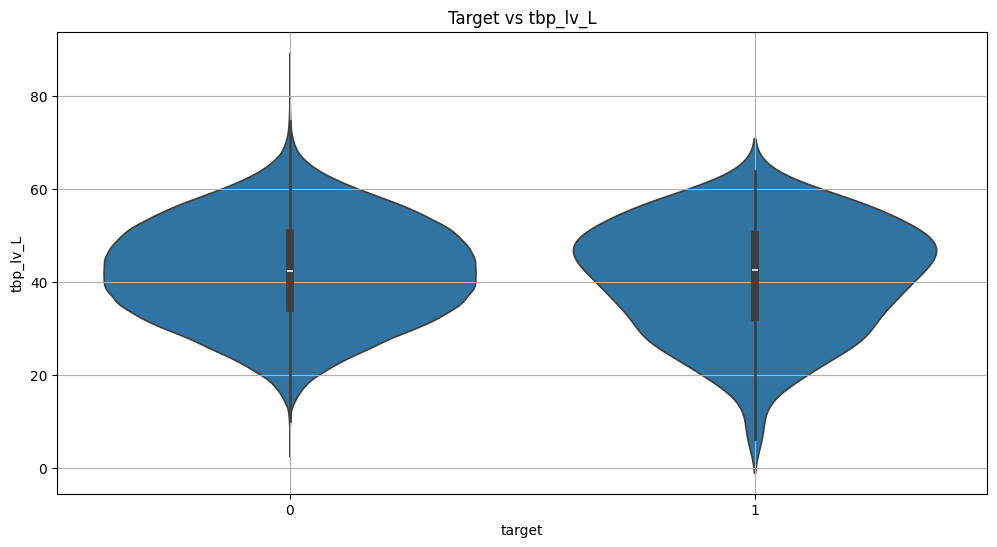

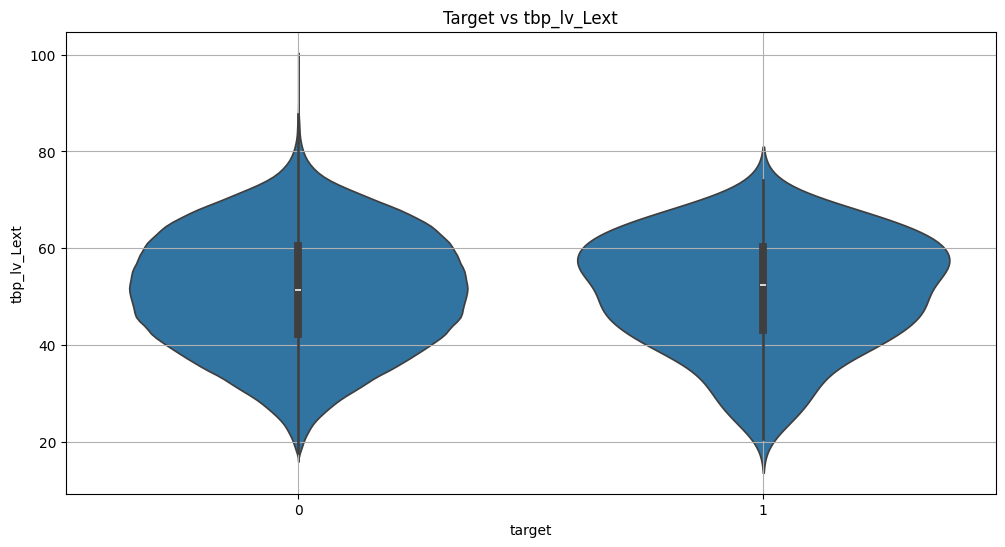

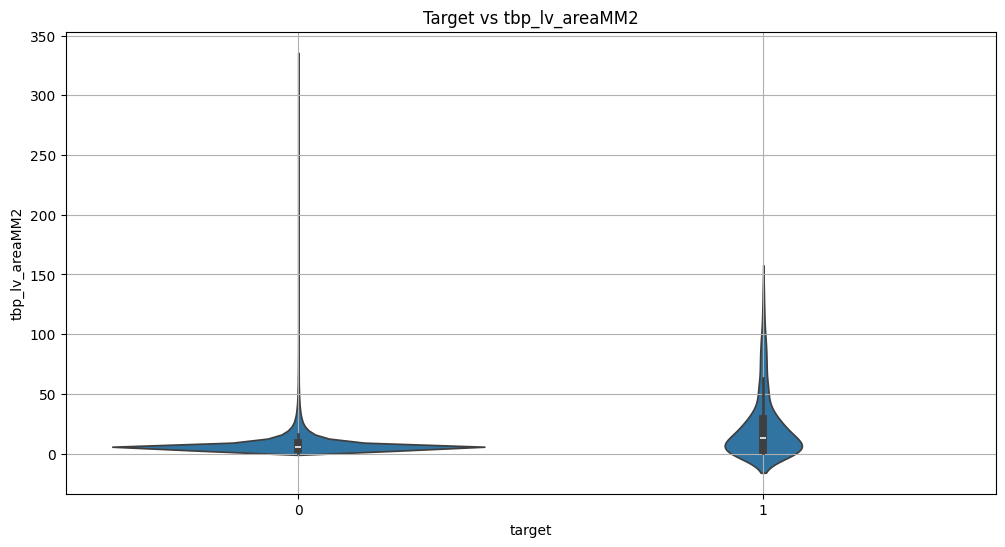

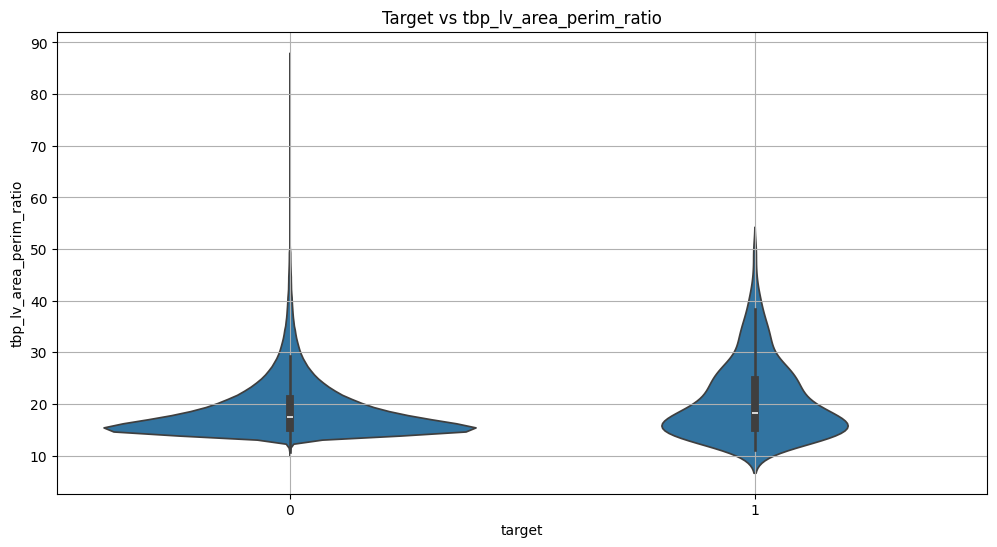

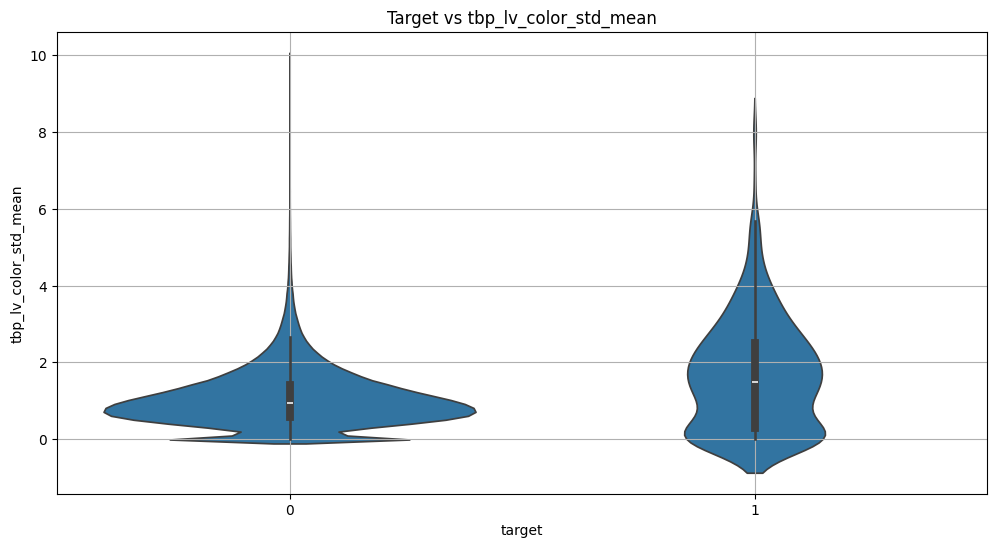

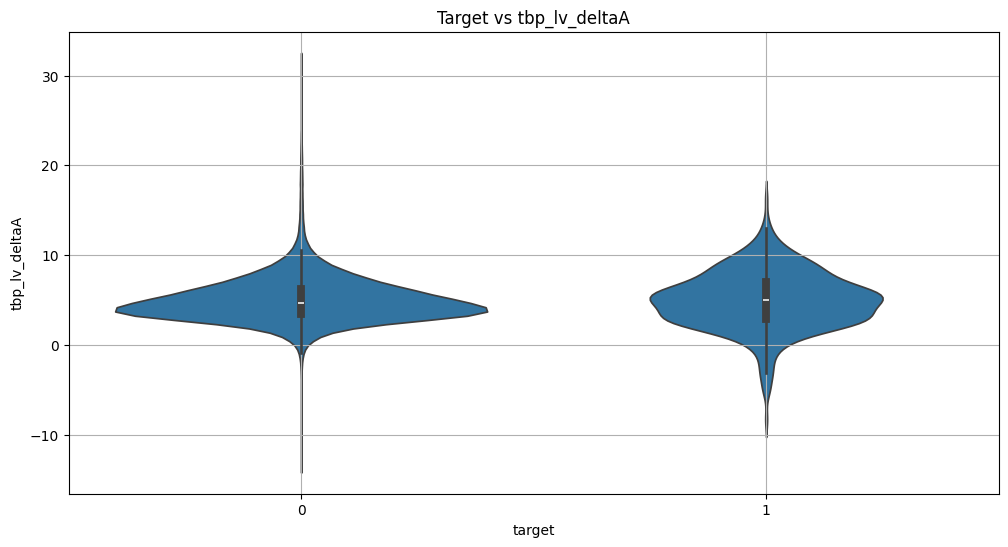

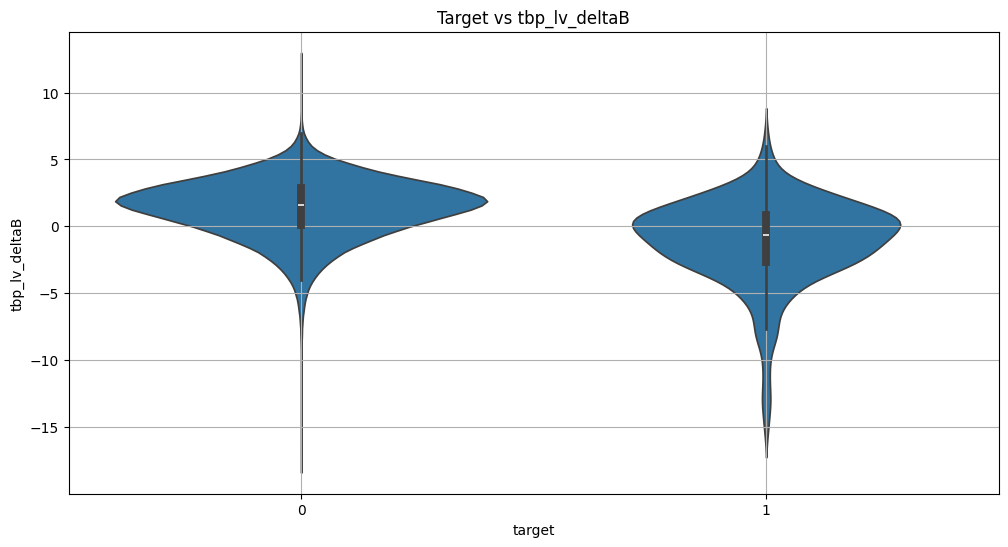

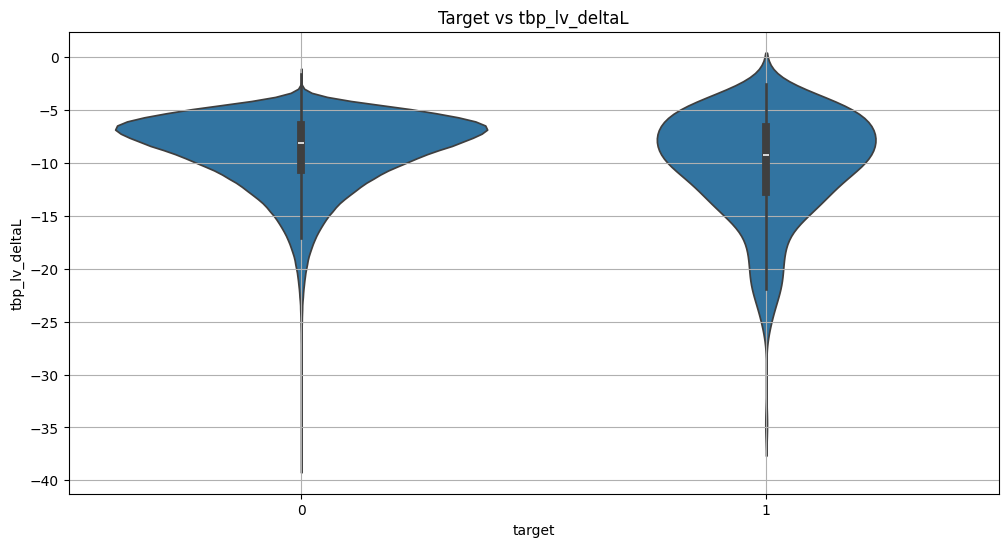

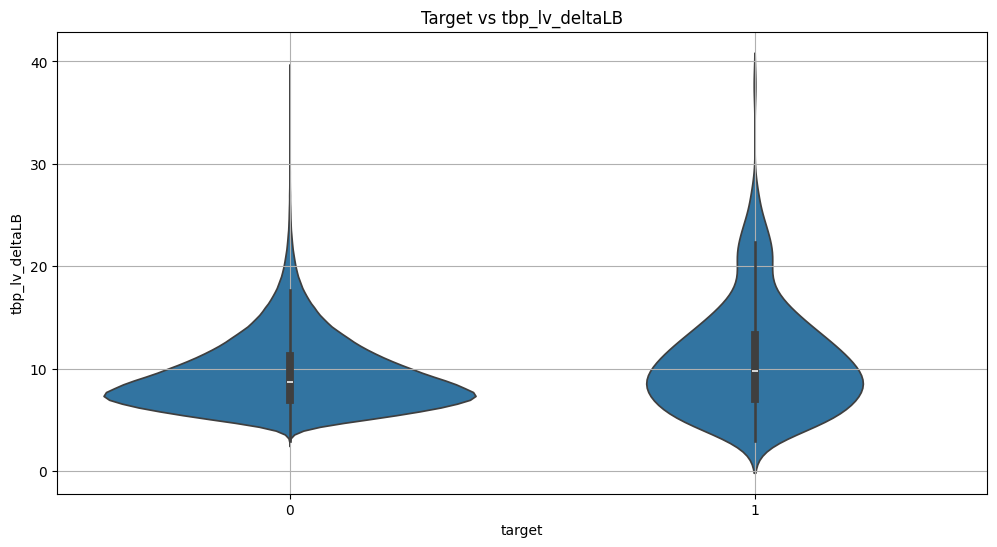

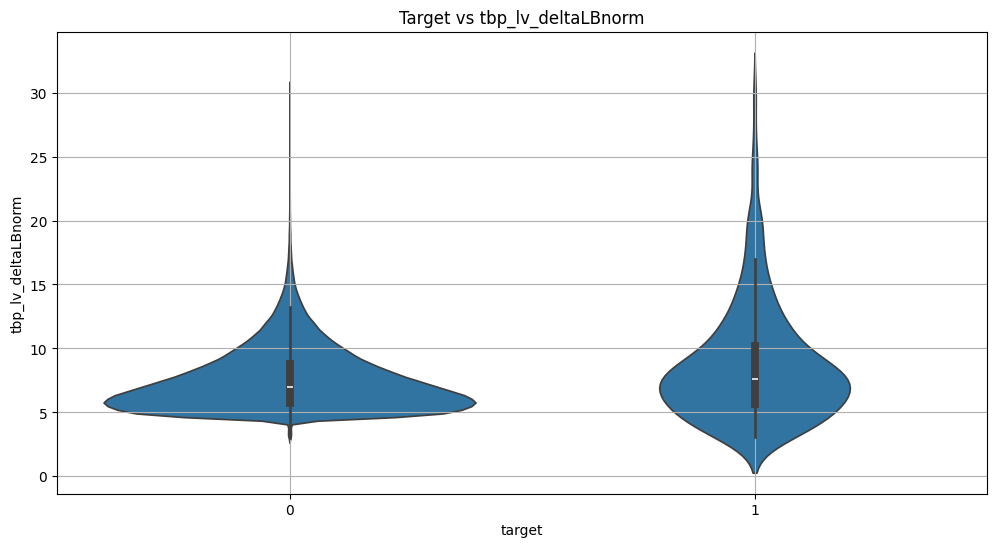

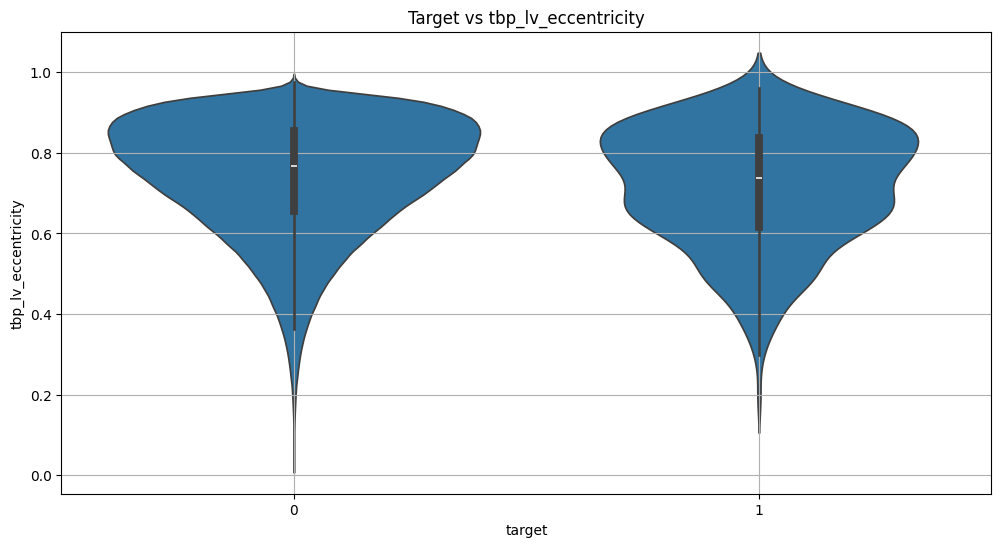

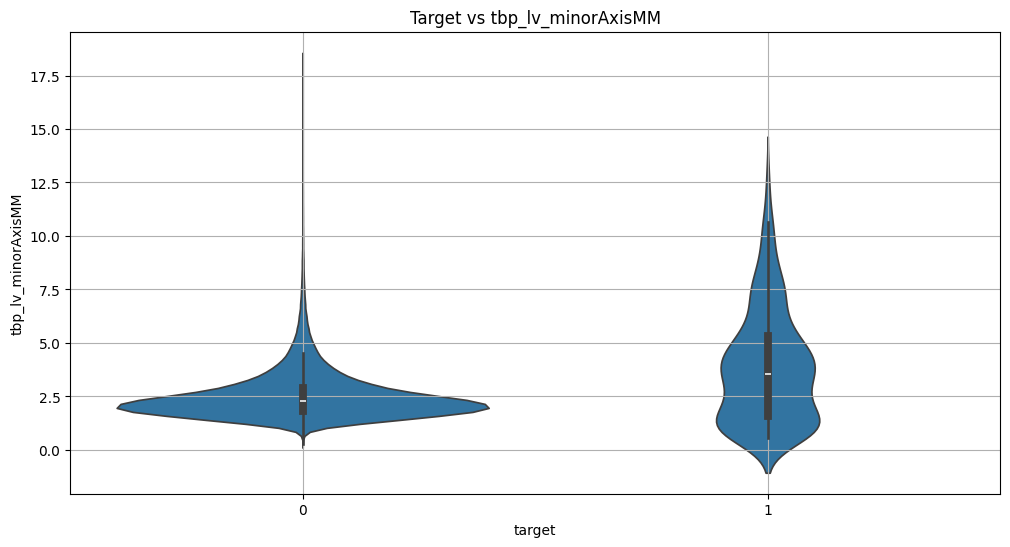

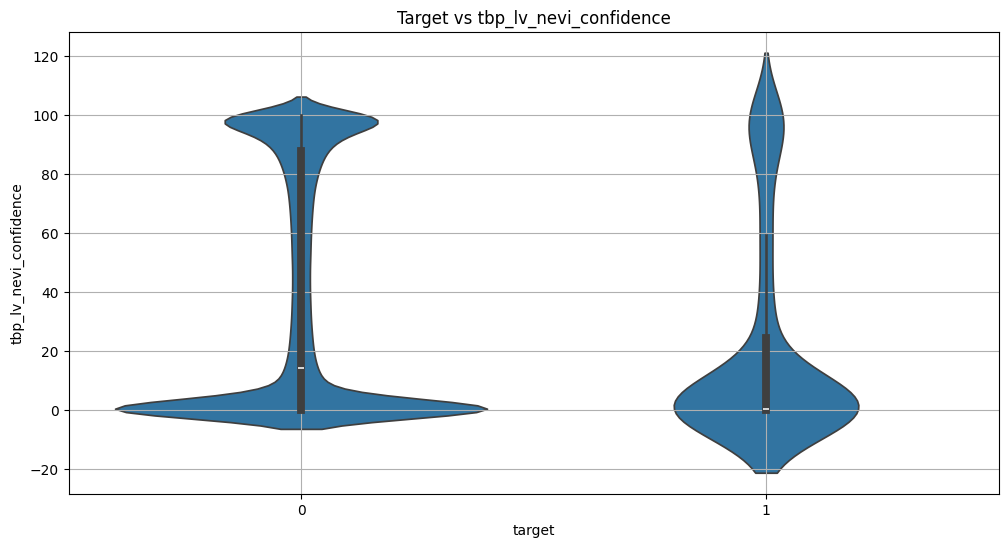

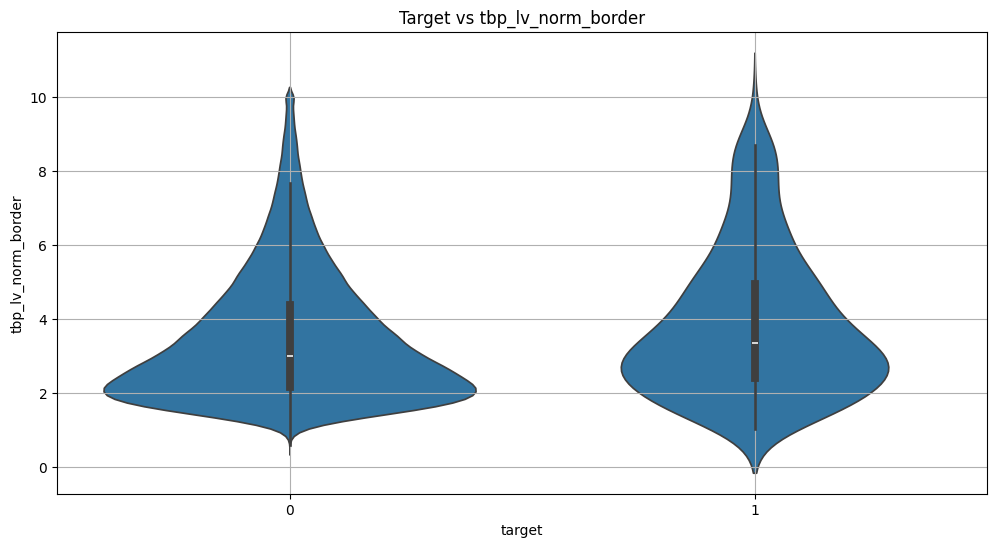

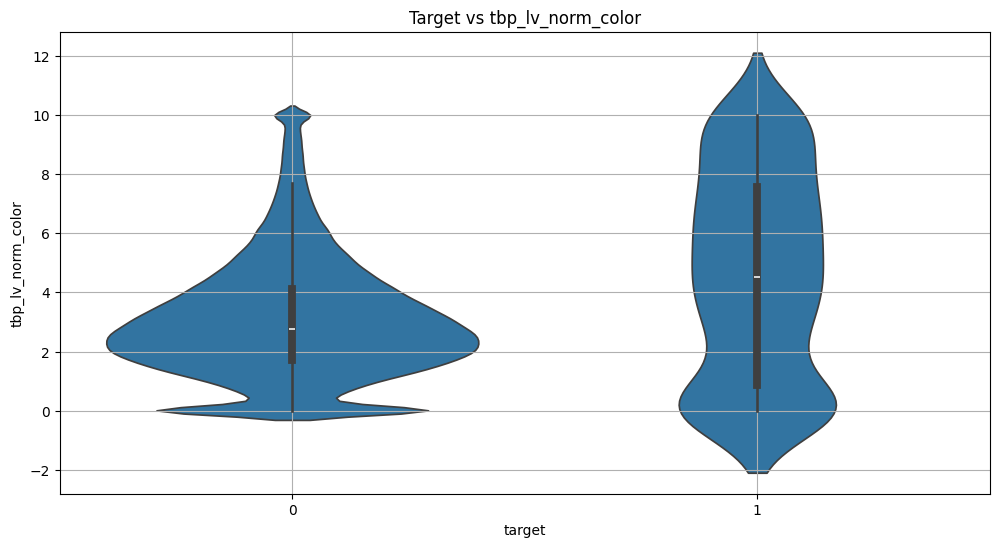

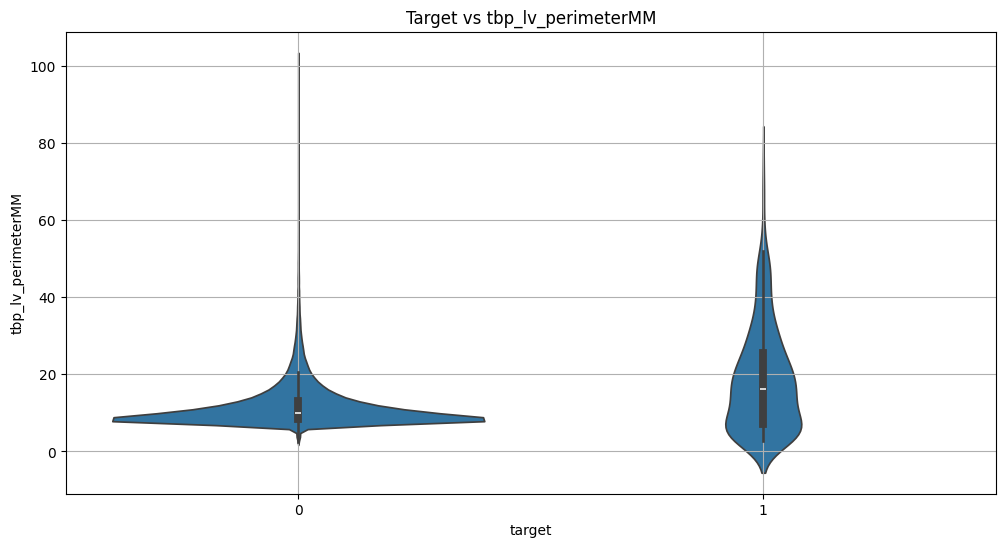

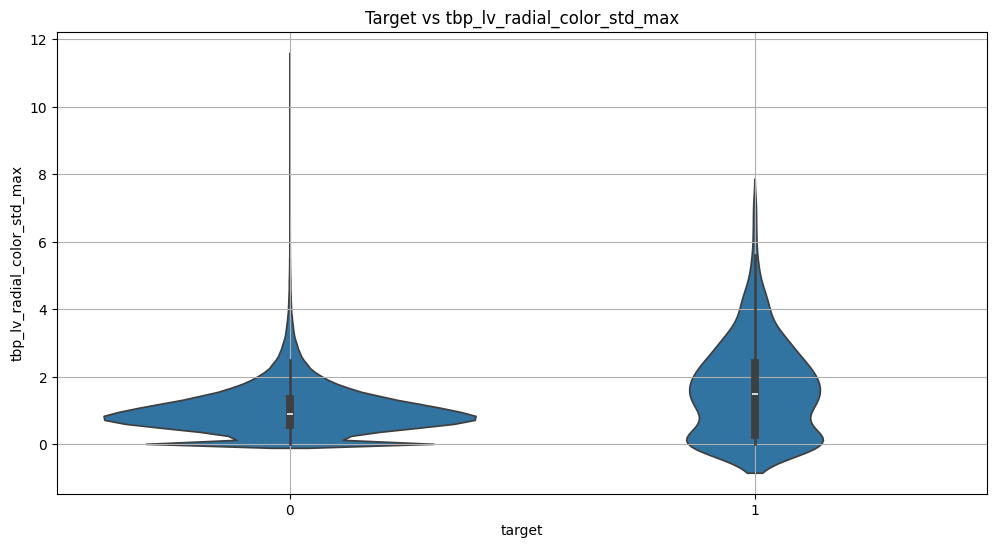

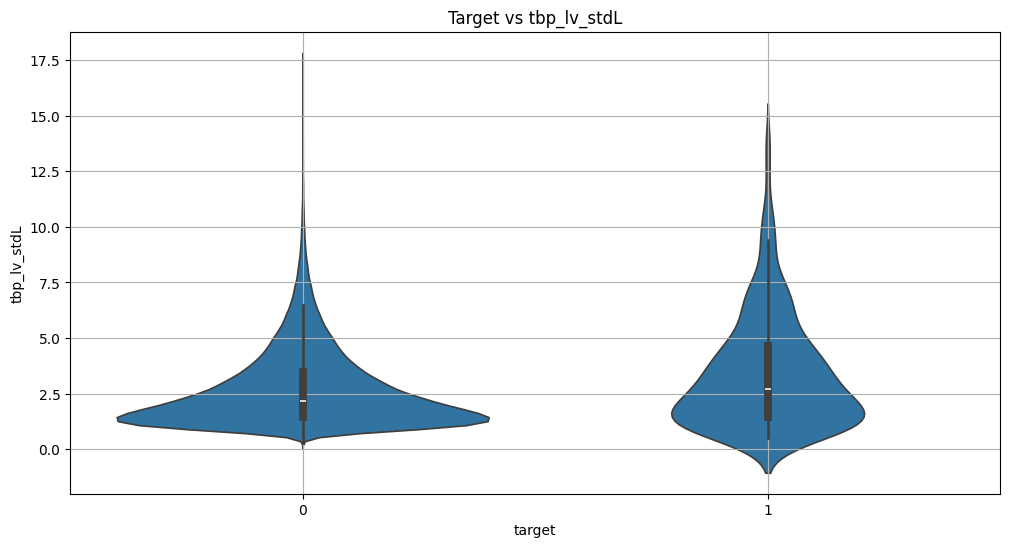

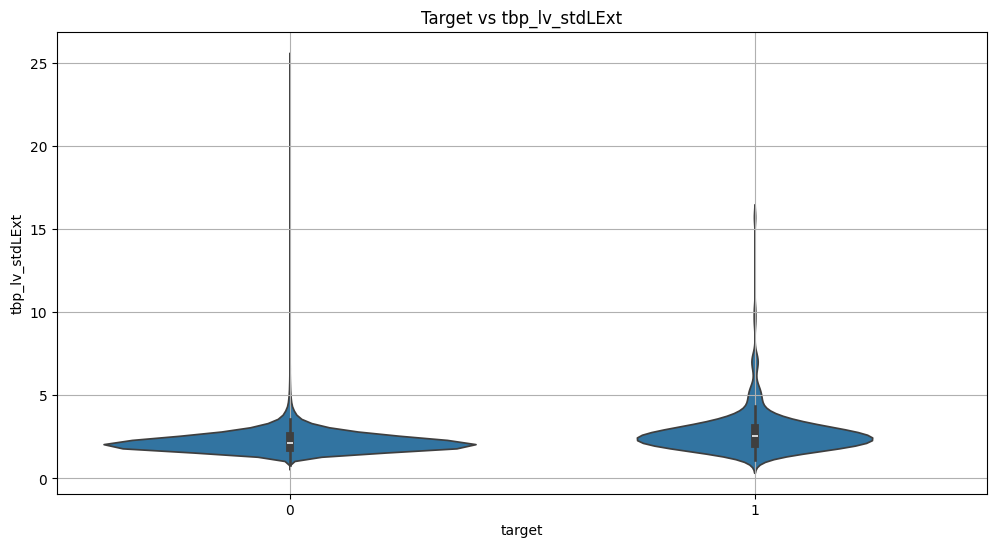

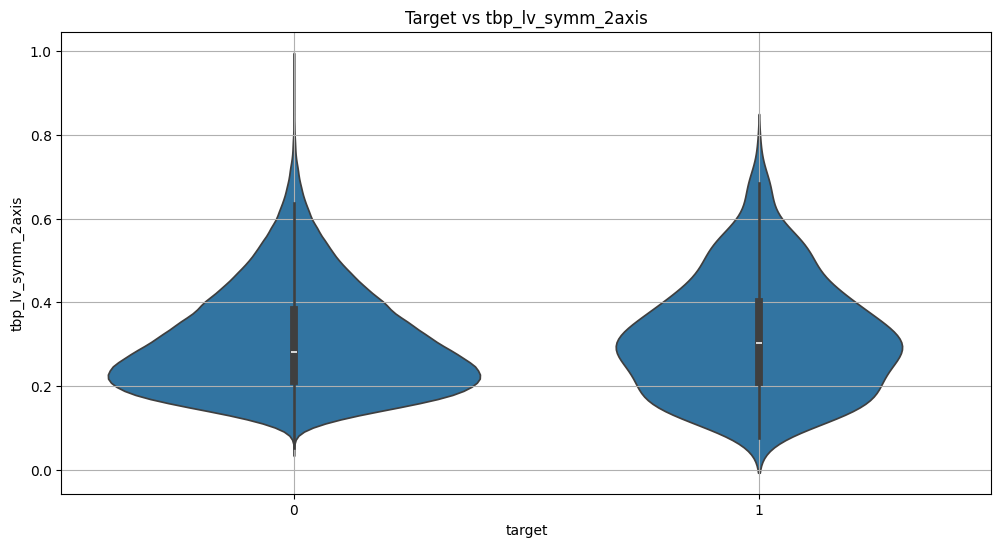

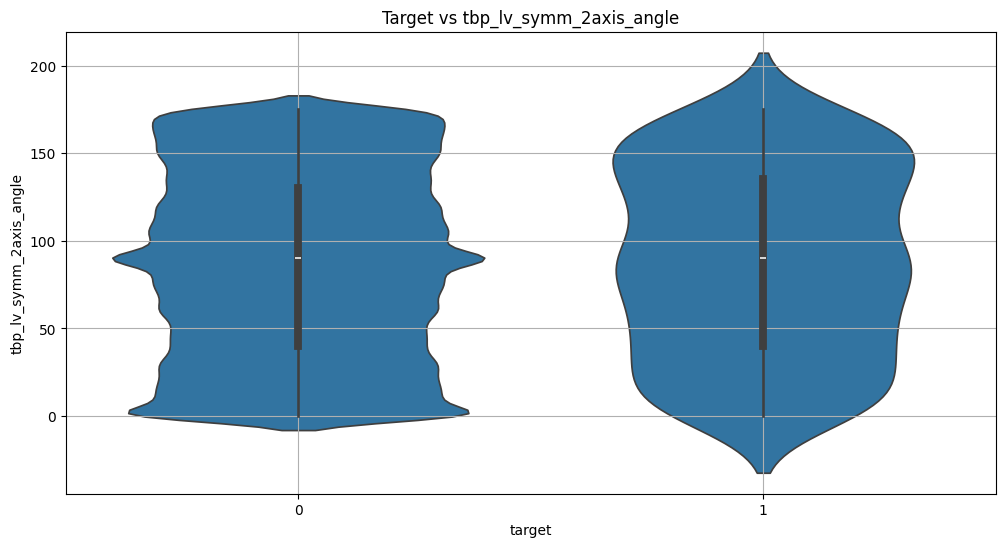

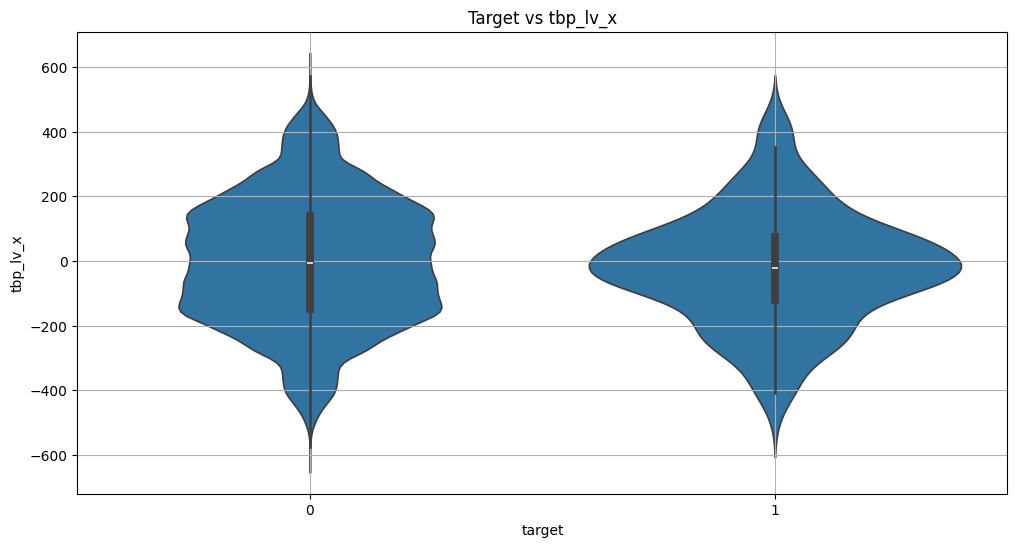

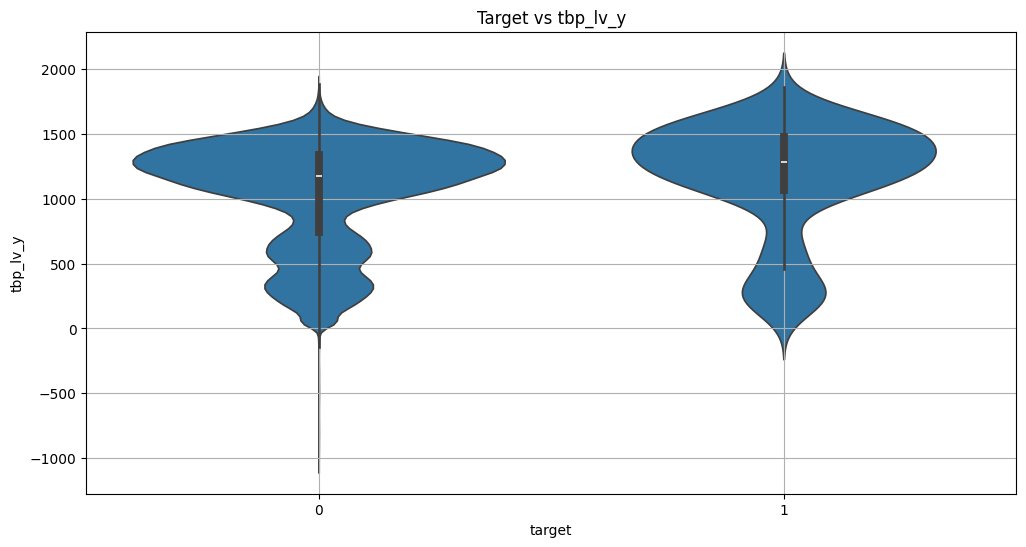

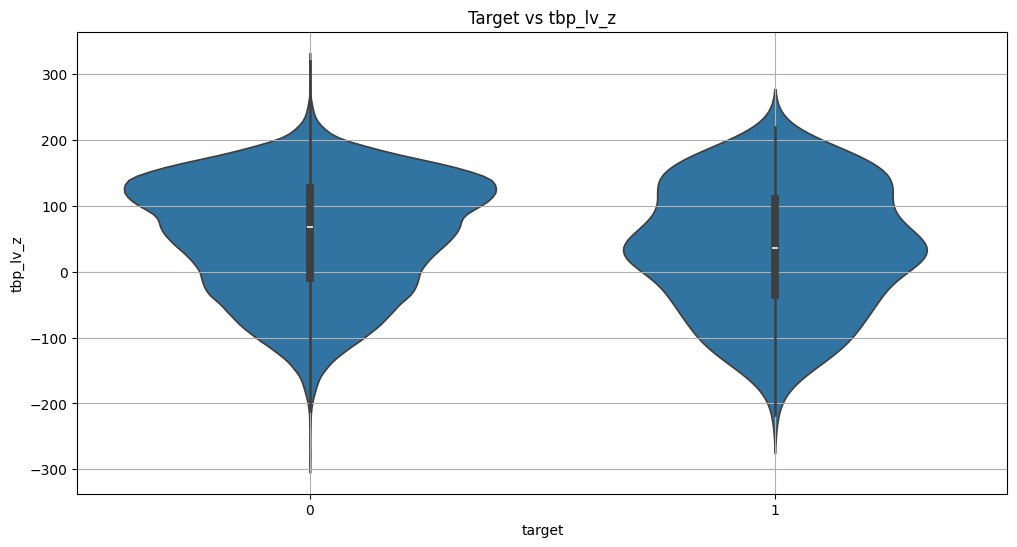

In [ ]:
for f in features_num:
  my_title = 'Target vs ' + f
  plt.figure(figsize = (12,6))
  sns.violinplot(x = df_train[target], y = df_train[f])
  plt.title(my_title)
  plt.grid()
  plt.show()
  print()

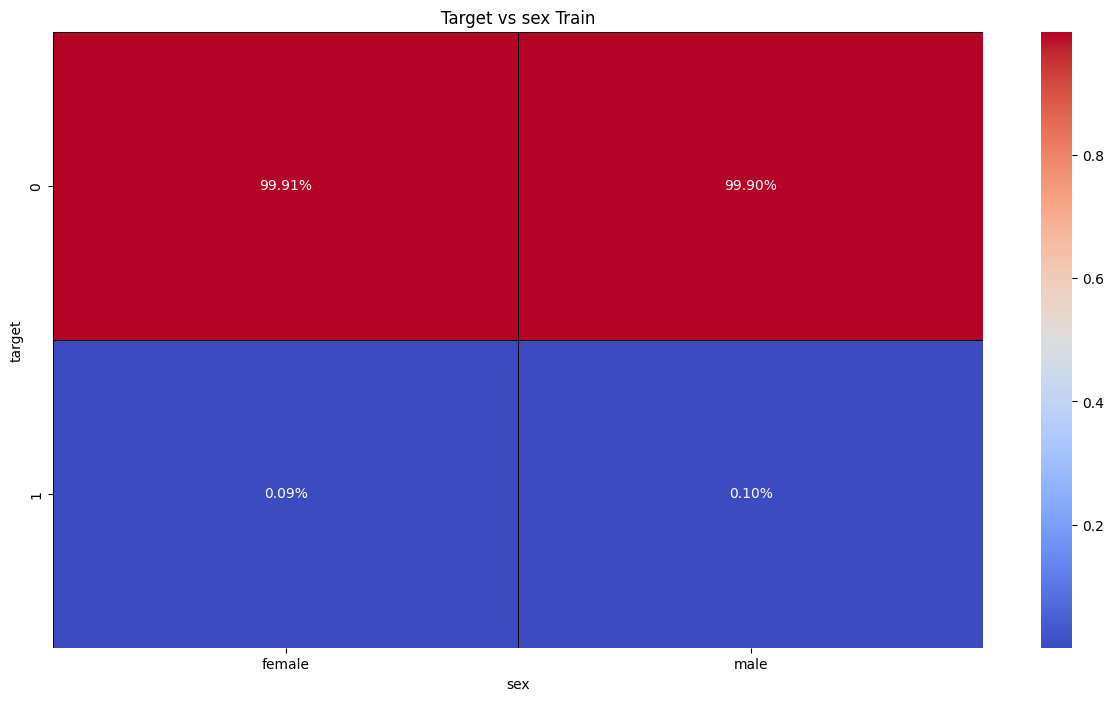

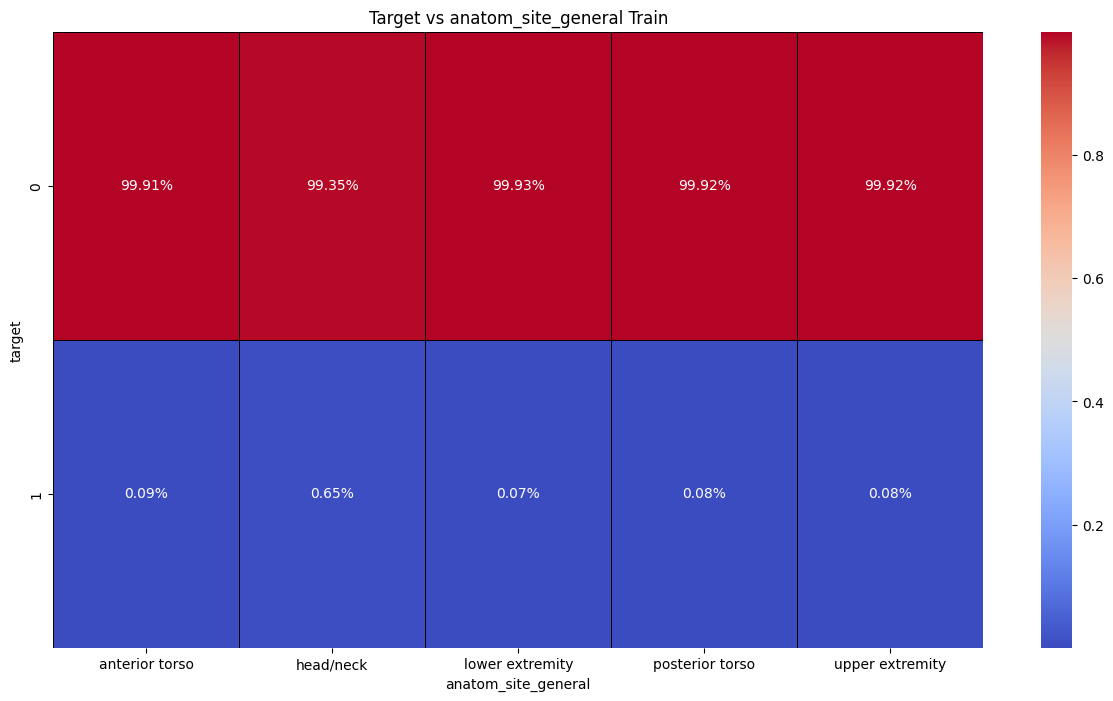

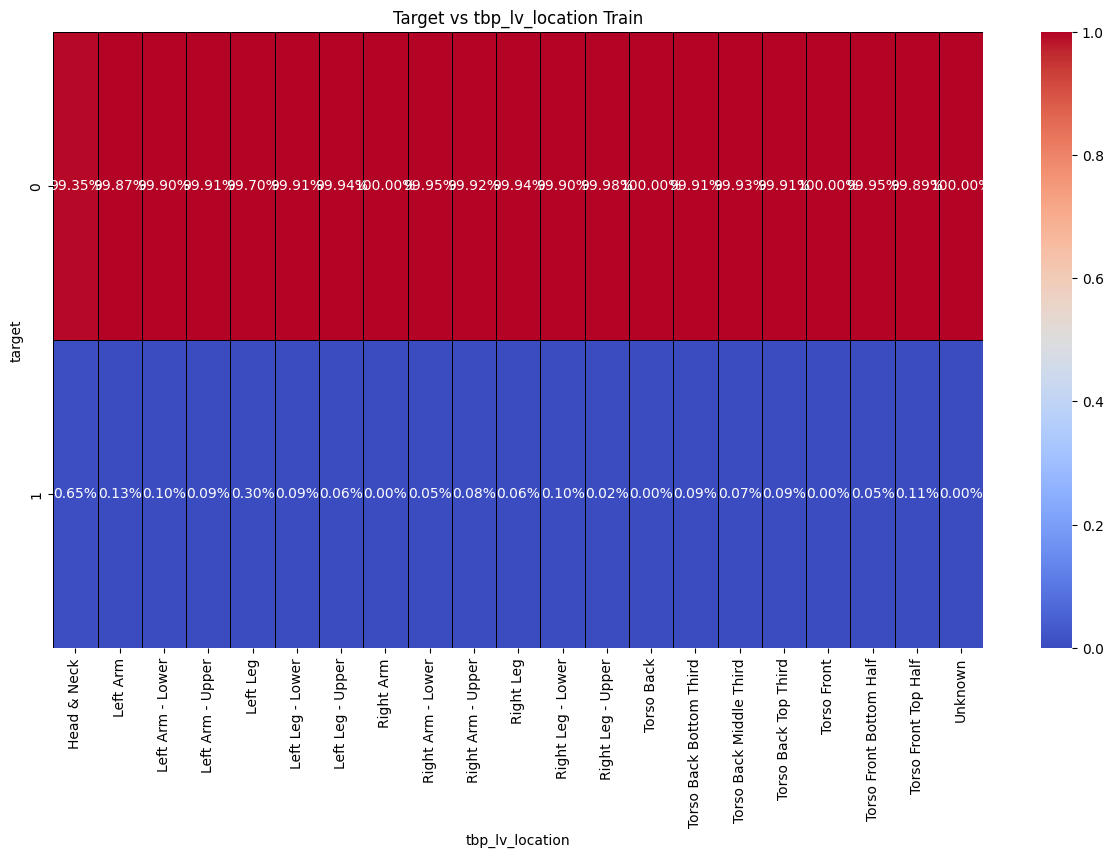

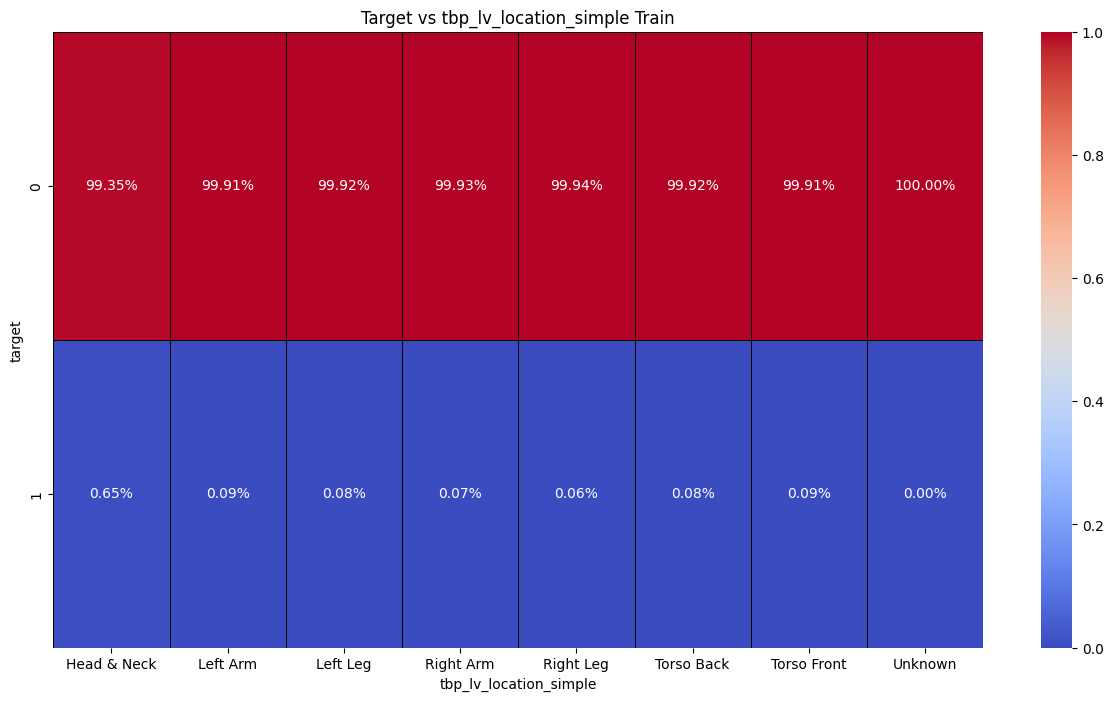

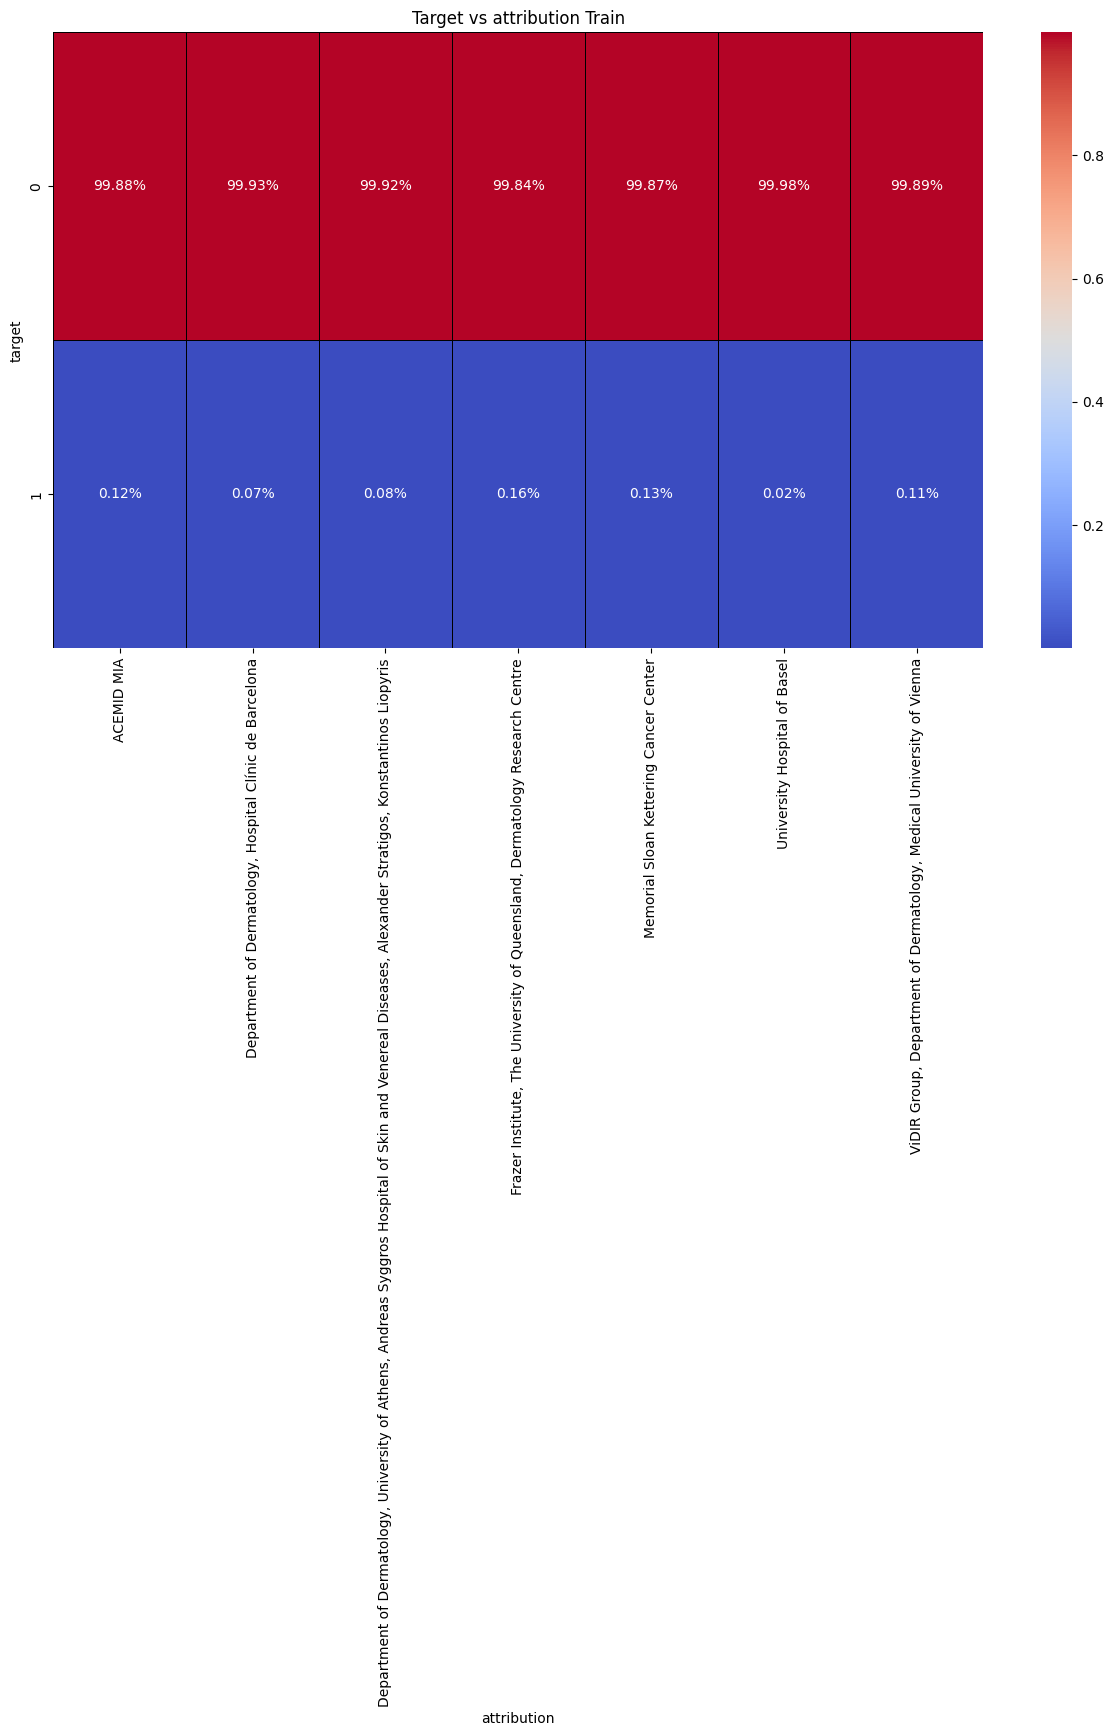

In [ ]:
for f in features_cat:
  ctab = pd.crosstab(df_train[target], df_train[f])
  ctab_normalize = ctab/ctab.sum()
  plt.figure(figsize = (15,8))
  sns.heatmap(ctab_normalize, annot = True, cmap = 'coolwarm', fmt = '.2%', linewidths = .5, linecolor = 'black')
  plt.title('Target vs ' + f + ' Train')
  plt.show()

# Baseline Model

In [ ]:
h2o.init(max_mem_size = '16G', nthreads = 4)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwejypyjj
  JVM stdout: /tmp/tmpwejypyjj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwejypyjj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.3
H2O_cluster_version_age:    28 days, 1 hour and 1 minute
H2O_cluster_name:           H2O_from_python_unknownUser_7iwp45
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    16 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [ ]:
# upload data in H2O environment
train_hex = h2o.H2OFrame(df_train)
test_hex = h2o.H2OFrame(df_test)

# force categorical target
train_hex[target] = train_hex[target].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# define features
features = features_num + features_cat

In [ ]:
# define model
gbm_model = H2OGradientBoostingEstimator(nfolds=3,
                                         ntrees=50,
                                         learn_rate=0.1,
                                         sample_rate=1.0,
                                         col_sample_rate=0.5,
                                         max_depth=3,
                                         min_rows=10,
                                         score_each_iteration=True,
                                         stopping_metric='auc',
                                         stopping_rounds=5,
                                         seed=my_random_seed)

# and train model
gbm_model.train(features, target, training_frame = train_hex);

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [ ]:
gbm_model.summary()

Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    21                 21                          2897                   3            3            3             4             8             6.38095

In [ ]:
gbm_model.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 
                         mean          sd             cv_1_valid    cv_2_valid    cv_3_valid
-----------------------  ------------  -------------  ------------  ------------  ------------
accuracy                 0.99774647    0.0005813633   0.9979387     0.9970933     0.9982074
aic                      nan           0.0            nan           nan           nan
auc                      0.76086557    0.12418        0.84157366    0.8231532     0.6178698
err                      0.0022535427  0.0005813633   0.002061334   0.0029066703  0.0017926233
err_count                301.0         75.90125       277.0         386.0         240.0
f0point5                 0.10199301    0.023341317    0.1029601     0.078183174   0.124835745
f1                       0.11279379    0.020872556    0.103559874   0.098130845   0.13669065
f2                       0.12898137    0.023555182    0.104166664   0.13174404    0.15103339
lift_top_group           15.2591       12.603283      19.949604     24.844568     0.9831263
loglikelihood            nan           0.0            nan           nan           nan
---                      ---           ---            ---           ---           ---
mcc                      0.11574074    0.01902988     0.10253296    0.10713601    0.13755326
mean_per_class_accuracy  0.5722425     0.017825719    0.5517661     0.5842956     0.5806658
mean_per_class_error     0.42775753    0.017825719    0.44823393    0.41570443    0.4193342
mse                      0.0010682931  0.00014963618  0.0012367577  0.0009508081  0.0010173136
pr_auc                   0.035559595   0.008372866    0.026752654   0.036508612   0.043417517
precision                0.09647633    0.025139038    0.102564104   0.06885246    0.11801242
r2                       -0.09336515   0.06899917     -0.08747519   -0.02749976   -0.1651205
recall                   0.14590001    0.036030404    0.104575165   0.17073171    0.16239317
rmse                     0.032632697   0.0022583534   0.035167567   0.030835176   0.031895354
specificity              0.9985849     0.00062838657  0.998957      0.9978594     0.99893844
[22 rows x 6 columns]

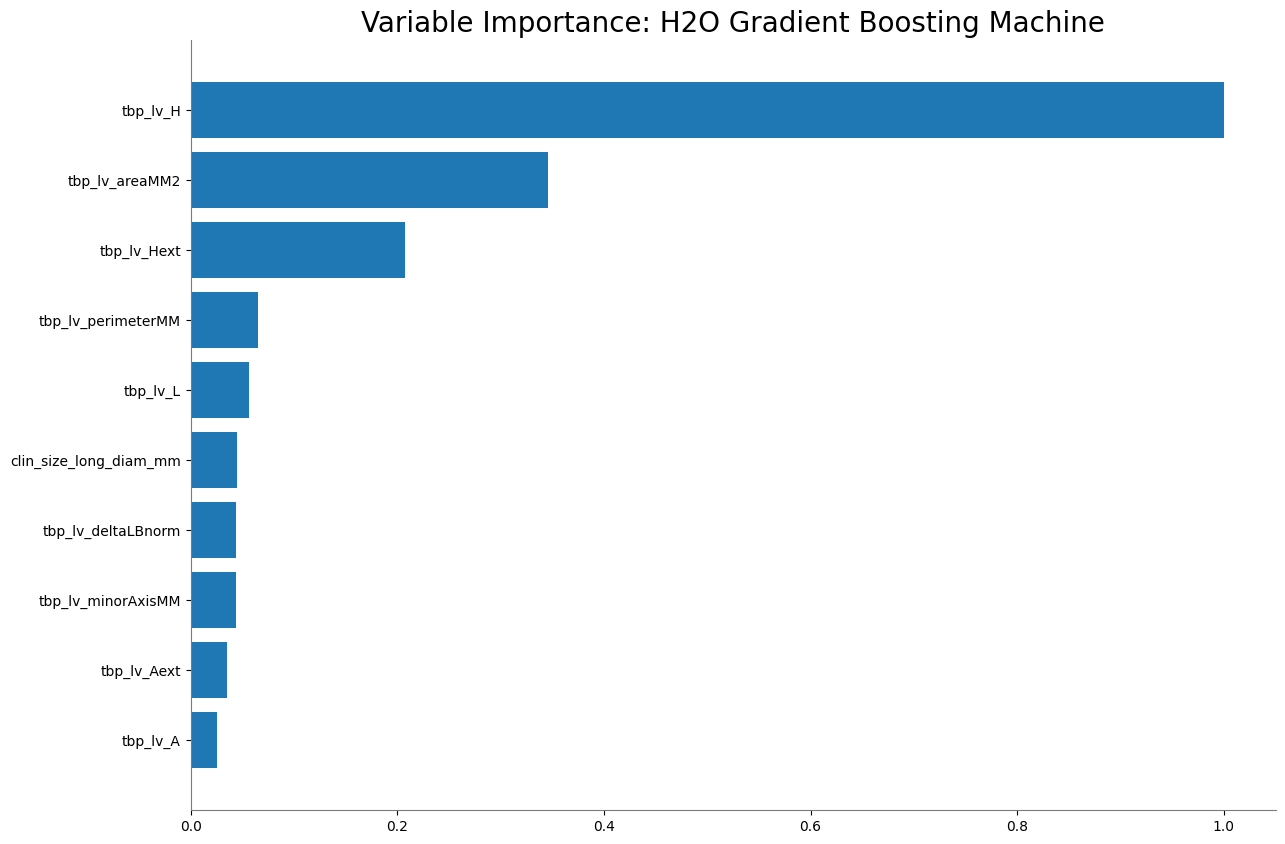

<Figure size 640x480 with 0 Axes>

In [ ]:
gbm_model.varimp_plot()

In [ ]:
gbm_model.varimp(20)

variable  relative_importance  scaled_importance  \
0                      tbp_lv_H           495.305267           1.000000   
1                tbp_lv_areaMM2           171.369522           0.345988   
2                   tbp_lv_Hext           102.796921           0.207543   
3            tbp_lv_perimeterMM            32.456776           0.065529   
4                      tbp_lv_L            28.118799           0.056771   
5        clin_size_long_diam_mm            22.157734           0.044736   
6            tbp_lv_deltaLBnorm            21.834169           0.044082   
7            tbp_lv_minorAxisMM            21.618740           0.043647   
8                   tbp_lv_Aext            17.546618           0.035426   
9                      tbp_lv_A            12.606878           0.025453   
10                  tbp_lv_Bext             9.709657           0.019603   
11                     tbp_lv_C             5.999456           0.012113   
12                     tbp_lv_B             2.596403           0.005242   
13                tbp_lv_deltaA             2.159969           0.004361   
14                  tbp_lv_Cext             1.446353           0.002920   
15                  tbp_lv_Lext             1.080732           0.002182   
16            tbp_lv_norm_color             0.868935           0.001754   
17              tbp_lv_location             0.696886           0.001407   
18               tbp_lv_deltaLB             0.368042           0.000743   
19  tbp_lv_radial_color_std_max             0.353001           0.000713   
20                   age_approx             0.000000           0.000000   
21                          sex             0.000000           0.000000   
22          anatom_site_general             0.000000           0.000000   
23      tbp_lv_area_perim_ratio             0.000000           0.000000   
24        tbp_lv_color_std_mean             0.000000           0.000000   
25                tbp_lv_deltaB             0.000000           0.000000   
26                tbp_lv_deltaL             0.000000           0.000000   
27          tbp_lv_eccentricity             0.000000           0.000000   
28       tbp_lv_location_simple             0.000000           0.000000   
29       tbp_lv_nevi_confidence             0.000000           0.000000   
30           tbp_lv_norm_border             0.000000           0.000000   
31                  tbp_lv_stdL             0.000000           0.000000   
32               tbp_lv_stdLExt             0.000000           0.000000   
33            tbp_lv_symm_2axis             0.000000           0.000000   
34      tbp_lv_symm_2axis_angle             0.000000           0.000000   
35                     tbp_lv_x             0.000000           0.000000   
36                     tbp_lv_y             0.000000           0.000000   
37                     tbp_lv_z             0.000000           0.000000   
38                  attribution             0.000000           0.000000   

    percentage  
0     0.520776  
1     0.180182  
2     0.108083  
3     0.034126  
4     0.029565  
5     0.023297  
6     0.022957  
7     0.022730  
8     0.018449  
9     0.013255  
10    0.010209  
11    0.006308  
12    0.002730  
13    0.002271  
14    0.001521  
15    0.001136  
16    0.000914  
17    0.000733  
18    0.000387  
19    0.000371  
20    0.000000  
21    0.000000  
22    0.000000  
23    0.000000  
24    0.000000  
25    0.000000  
26    0.000000  
27    0.000000  
28    0.000000  
29    0.000000  
30    0.000000  
31    0.000000  
32    0.000000  
33    0.000000  
34    0.000000  
35    0.000000  
36    0.000000  
37    0.000000  
38    0.000000

In [ ]:
pred_test1 = gbm_model.predict(test_hex)
pred_test1 = pred_test1.as_data_frame()
pred_test1

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'attribution' has levels not trained on: ["FNQH Cairns"]
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


predict        p0        p1
0        0  0.999368  0.000632
1        0  0.999370  0.000630
2        0  0.999368  0.000632

In [ ]:
pred_test1.p1

0    0.000632
1    0.000630
2    0.000632
Name: p1, dtype: float64

In [ ]:
df_sub['target'] = pred_test1.p1
df_sub.head()

isic_id    target
0  ISIC_0015657  0.000632
1  ISIC_0015729  0.000630
2  ISIC_0015740  0.000632

In [ ]:
df_sub.to_csv('/content/drive/MyDrive/kaggle_skinCancer/submission.csv', index = False)

In [ ]:
! kaggle competitions submit -c 'isic-2024-challenge' -f /content/drive/MyDrive/kaggle_skinCancer/submission.csv -m 'submission'

100% 120/120 [00:00<00:00, 168B/s]
400 - Bad Request - Submission not allowed:  This competition only accepts Submissions from Notebooks.
